In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from scipy.stats import randint
from scipy.spatial.distance import cdist, euclidean, minkowski
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from datetime import datetime, timedelta
import xgboost as xgb
import xarray as xr
import cdsapi
from tqdm import tqdm
import warnings
import pickle
import os
import matplotlib.cm as cm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)

In [2]:
# Output directory
output_dir = './output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [3]:
drifter_data = xr.open_dataset('./data/NOAA_drifter_2005.nc', decode_times=False)
drifter_data

<xarray.Dataset>
Dimensions:  (drifter: 31, time: 1412)
Coordinates:
  * drifter  (drifter) float64 1.0 2.0 3.0 4.0 5.0 ... 27.0 28.0 29.0 30.0 31.0
  * time     (time) float64 0.0 0.25 0.5 0.75 1.0 ... 352.0 352.2 352.5 352.8
Data variables:
    lons     (drifter, time) float64 ...
    lats     (drifter, time) float64 ...
    times    (drifter, time) float64 ...

In [4]:
# Extract the units attribute from the 'times' variable in the original undecoded dataset
time_units = drifter_data['times'].attrs['units']

# Extract the reference date (base time) from the units string
base_time = time_units.split("since")[1].strip()

base_time

'2005-Jan-1; times=1 corresponds to 2005-Jan-2'

In [5]:
# Define the reference date
ref_date = "2005-01-01"

# Flatten the 'times' variable to make it 1D
flattened_times = drifter_data['times'].values.flatten()

# Safely decode the flattened times
decoded_times_safe = []
for time_value in flattened_times:
    try:
        decoded_time = pd.to_datetime(time_value, origin=ref_date, unit='D')
        decoded_times_safe.append(decoded_time)
    except pd.errors.OutOfBoundsDatetime:
        decoded_times_safe.append(pd.NaT)

# Convert the list to a numpy array and reshape it to the original shape
decoded_times_array = np.array(decoded_times_safe).reshape(drifter_data['times'].shape)

# Assign the decoded times with explicit dimensions
drifter_data_total = drifter_data.assign_coords(times=(drifter_data['times'].dims, decoded_times_array))

# Convert the xarray datasets to pandas dataframes
drifter_data_total_df = drifter_data_total.to_dataframe().reset_index()
drifter_data_total_df

drifter    time        lons       lats               times
0          1.0    0.00  129.311005  34.950001 2005-02-21 06:00:00
1          1.0    0.25  129.401993  35.020000 2005-02-21 12:00:00
2          1.0    0.50  129.514008  35.061001 2005-02-21 18:00:00
3          1.0    0.75  129.524002  35.032001 2005-02-22 00:00:00
4          1.0    1.00  129.626007  35.083000 2005-02-22 06:00:00
...        ...     ...         ...        ...                 ...
43767     31.0  351.75         NaN        NaN                 NaT
43768     31.0  352.00         NaN        NaN                 NaT
43769     31.0  352.25         NaN        NaN                 NaT
43770     31.0  352.50         NaN        NaN                 NaT
43771     31.0  352.75         NaN        NaN                 NaT

[43772 rows x 5 columns]

In [6]:
# Drop the 'time' column from the drifter_data_total_df dataframe
drifter_df = drifter_data_total_df.drop(columns='time')
drifter_df.rename(columns={'times': 'time'}, inplace=True)
drifter_df['time'] = pd.to_datetime(drifter_df['time'])

drifter_df.head(10)

drifter        lons       lats                time
0      1.0  129.311005  34.950001 2005-02-21 06:00:00
1      1.0  129.401993  35.020000 2005-02-21 12:00:00
2      1.0  129.514008  35.061001 2005-02-21 18:00:00
3      1.0  129.524002  35.032001 2005-02-22 00:00:00
4      1.0  129.626007  35.083000 2005-02-22 06:00:00
5      1.0  129.712997  35.058998 2005-02-22 12:00:00
6      1.0  129.830994  35.000000 2005-02-22 18:00:00
7      1.0  129.807999  34.889999 2005-02-23 00:00:00
8      1.0  129.847000  34.910999 2005-02-23 06:00:00
9      1.0  129.860992  34.879002 2005-02-23 12:00:00

In [7]:
drifter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43772 entries, 0 to 43771
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   drifter  43772 non-null  float64       
 1   lons     15845 non-null  float64       
 2   lats     15845 non-null  float64       
 3   time     15845 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.3 MB


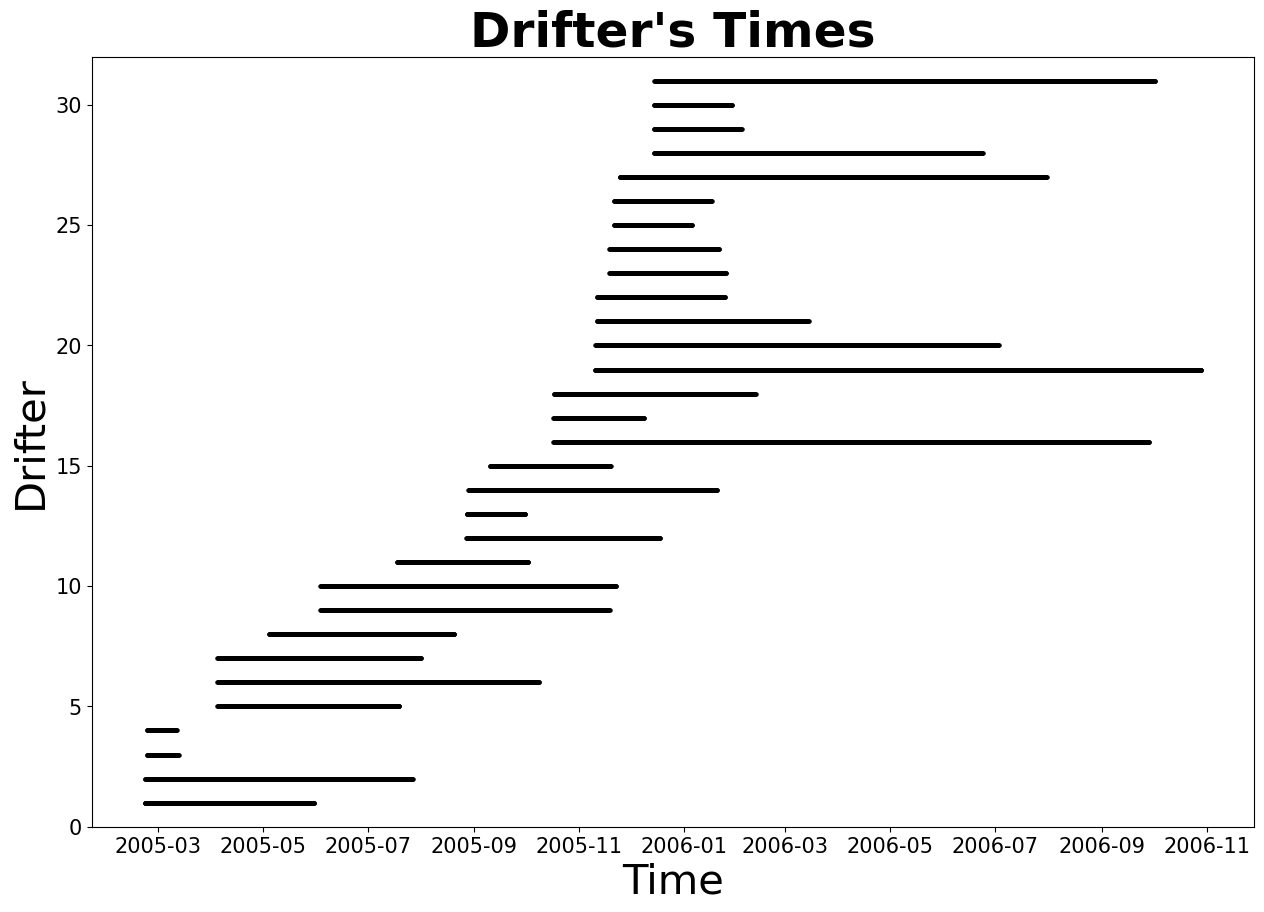

In [8]:
unique_drifters = drifter_df['drifter'].unique()

#Group data frames by drifter number
grouped = drifter_df.groupby('drifter')

#Draw a graph color-coded according to drifter values
plt.figure(figsize=(15,10))

for idx, drifter in enumerate(unique_drifters):
    subset = drifter_df[drifter_df['drifter'] == drifter]
    plt.scatter(subset['time'], subset['drifter'], s=5, color='black')

plt.title("Drifter's Times",fontsize=35, weight='bold')
plt.xlabel("Time", fontsize=30)
plt.ylabel("Drifter", fontsize=30)
plt.ylim([0, 32])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#save file
save_path = output_dir + "/Drifter's_Times.png"
plt.savefig(save_path, dpi=300)

plt.show()

In [9]:
drop_drifter_df = drifter_df.dropna()
drop_drifter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15845 entries, 0 to 43525
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   drifter  15845 non-null  float64       
 1   lons     15845 non-null  float64       
 2   lats     15845 non-null  float64       
 3   time     15845 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3)
memory usage: 618.9 KB


<Figure size 1500x1000 with 0 Axes>

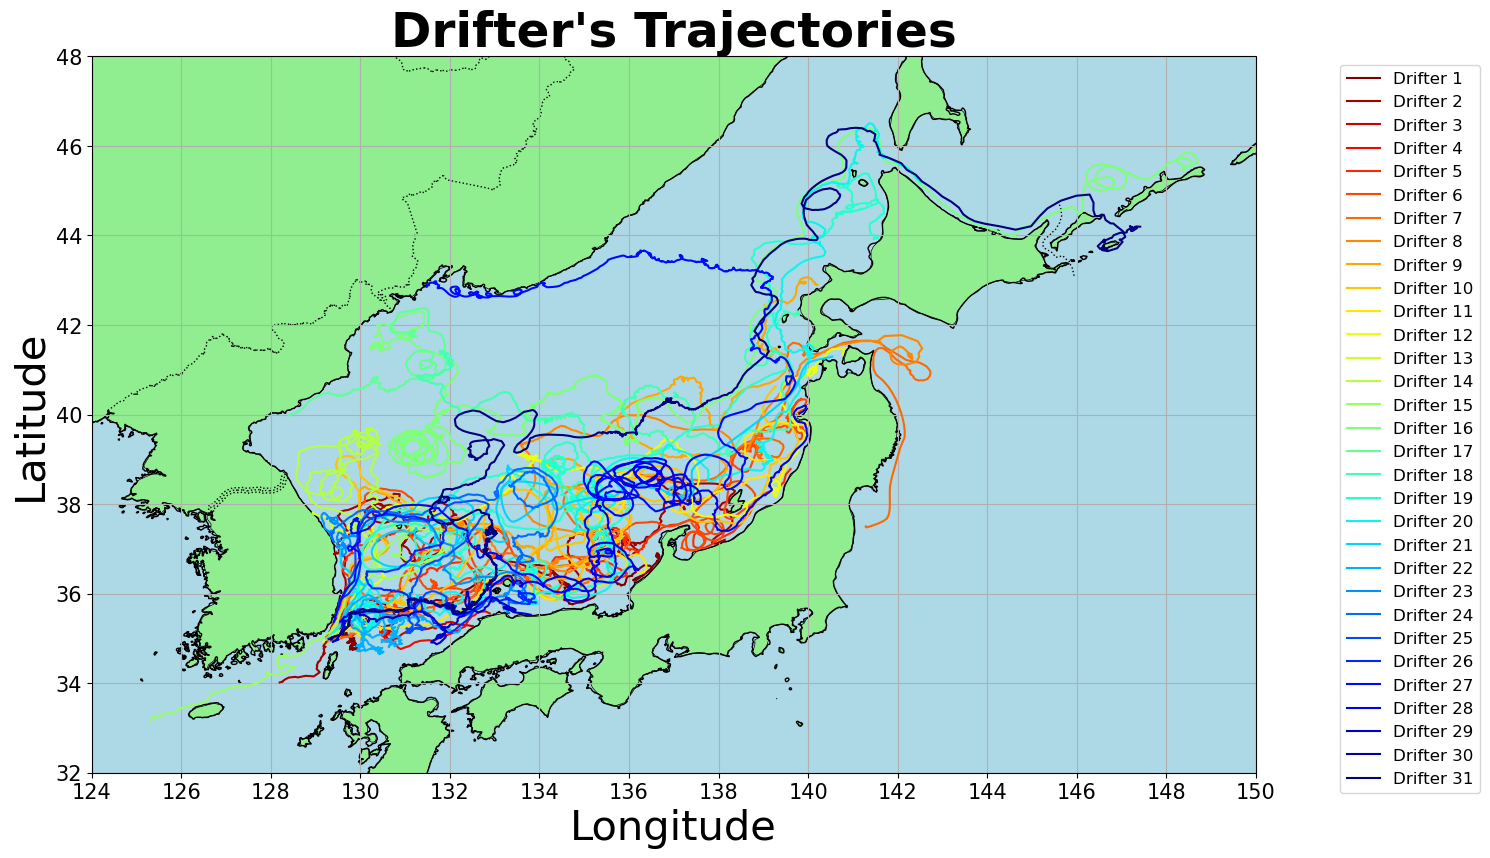

In [10]:
# Setting up colormap for rainbow representation
cmap = plt.cm.jet
colors = cmap(np.linspace(1, 0, len(unique_drifters)))

plt.figure(figsize=(15, 10))

# Setting up the plot
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Adding land, coastlines, and borders to the map
# Setting the color of land to green and the color of ocean to light blue
land = cfeature.LAND.with_scale('50m')
ax.add_feature(land, edgecolor='black', facecolor='lightgreen')

ocean = cfeature.OCEAN.with_scale('50m')
ax.add_feature(ocean, facecolor='lightblue')

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Displaying the trajectories of each drifter on the map
for unique_drifters, color in zip(unique_drifters, colors):
    subset = drop_drifter_df[drop_drifter_df["drifter"] == unique_drifters]
    ax.plot(subset["lons"], subset["lats"], label=f"Drifter {int(unique_drifters)}", color=color, transform=ccrs.Geodetic())

plt.title("Drifter's Trajectories", fontsize=35, weight='bold')
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1), fontsize=12)

plt.xlabel('Longitude', fontsize=30)
plt.ylabel('Latitude', fontsize=30)

# Setting the xticks and yticks
# Calculating the minimum and maximum latitudes and longitudes of the entire trajectory
min_lat, max_lat = drop_drifter_df['lats'].min()-1, drop_drifter_df['lats'].max()+1
min_lon, max_lon = drop_drifter_df['lons'].min()-1, drop_drifter_df['lons'].max()+1
ax.set_xticks(np.arange(round(min_lon), round(max_lon) + 1, 2))  # Example: Setting x-ticks at 2-degree intervals
ax.set_yticks(np.arange(round(min_lat), round(max_lat) + 1, 2))  # Example: Setting y-ticks at 2-degree intervals
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.grid(True)
plt.tight_layout()

# Saving the file
save_path = output_dir + "/Drifter's_Trajectories.png"
plt.savefig(save_path, dpi=300)

plt.show()


## 1-2. API Calls for Downloading Ocean Current and Wind Data
---
The code commented below is a one-time execution code used to make API calls to retrieve ocean current and wind data for drifter trajectories.

For specified data item #2, surface ocean current data (https://data.marine.copernicus.eu/product/MULTIOBS_GLO_PHY_REP_015_004/download?dataset=dataset-uv-rep-hourly_201912), and for specified data item #3, surface (10m) wind data (ERA5) (https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=form), you need to register as a member on both websites before running the code.

For specified data item #2, surface ocean current data, you need to input your USERNAME and PASSWORD, obtained through registration, to initiate the MOTU API call.
(MOTU API reference: https://help.marine.copernicus.eu/en/articles/4796533-what-are-the-motu-apis)

For specified data item #3, surface wind data, after registering, you need to install the CDS API key and CDS API client to use the CDS API. Installation methods may vary depending on your computer's operating system, so please refer to the respective guides for Windows, macOS, or Linux users.
> For Windows users, please read "How to install and use CDS API on Windows."
> For macOS users, please read "How to install and use CDS API on macOS."
> For Linux users, follow these steps:
> - Install the CDS API key.
> - Install the CDS API client.
> - Use the CDS API client for data access.
(CDS API reference: https://cds.climate.copernicus.eu/api-how-to)


---

**_When you run this code, it will download surface ocean current and surface wind data files for each drifter number, corresponding to the time and area, into a folder named "data" located below the folder where the code is saved. The files will be named "download_current_{i}.0.nc" and "download_wind_{i}.0.nc" (where 'i' ranges from 1 to 31)._**


In [11]:
# # Calling the ocean current data API

# # Create a list to store the results
# results_list = []

# # Loop through each drifter group
# for name, group in grouped:
#     min_lat = group['lats'].min()
#     max_lat = group['lats'].max()
    
#     min_lon = group['lons'].min()
#     max_lon = group['lons'].max()
    
#     start_time = group['time'].min()
#     end_time = group['time'].max()
    
#     results_list.append({
#         'drifter': name,
#         'min_lat': min_lat,
#         'max_lat': max_lat,
#         'min_lon': min_lon,
#         'max_lon': max_lon,
#         'start_time': start_time,
#         'end_time': end_time
#     })

# # Convert the list of dictionaries to a DataFrame
# results_df_direct = pd.DataFrame(results_list)

# # Save to a new CSV
# results_df_direct.to_csv("./data/index_drifter.csv", index=False)

# # User credentials
# USERNAME = input("Enter your username: ")
# PASSWORD = getpass.getpass("Enter your password: ")

# # Define parameters
# INPUT_FILE = "./data/index_drifter.csv"
# df = pd.read_csv(INPUT_FILE)

# # Loop through rows of dataframe with tqdm for progress
# for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing"):
#     # Get parameters
#     min_lat = row['min_lat'] - 0.25
#     max_lat = row['max_lat'] + 0.25
#     min_lon = row['min_lon'] - 0.25
#     max_lon = row['max_lon'] + 0.25
#     start_time = row['start_time']
#     end_time = row['end_time']
#     depth_min = 0
#     depth_max = 15

#     # Generate motuclient command line
#     ! python -m motuclient --motu https://my.cmems-du.eu/motu-web/Motu --service-id MULTIOBS_GLO_PHY_REP_015_004-TDS --product-id dataset-uv-rep-hourly --longitude-min {min_lon} --longitude-max {max_lon} --latitude-min {min_lat} --latitude-max {max_lat} --date-min '{start_time}' --date-max '{end_time}' --depth-min {depth_min} --depth-max {depth_max} --variable uo --variable vo --out-name ./data/download_current_{index+1}.0.nc --user {USERNAME} --pwd {PASSWORD}


In [12]:
# # Calling the wind data API

# key_value = input("Please enter your key value: ")
# home_folder = os.path.expanduser('~')

# with open(f"{home_folder}/.cdsapirc", "w") as file:
#     file.write("url: https://cds.climate.copernicus.eu/api/v2\n")
#     file.write(f"key: {key_value}\n")

# c = cdsapi.Client()

# for drifter_num, group in tqdm(grouped, desc="Downloading Data"):
#     # Finding minimum and maximum latitude and longitude values for each group
#     min_lat, max_lat = group['lats'].min() - 0.25, group['lats'].max() + 0.25
#     min_lon, max_lon = group['lons'].min() - 0.25, group['lons'].max() + 0.25

#     # Extracting dates for each group
#     unique_dates = group['time'].dt.date.unique()
#     years = list(set([date.year for date in unique_dates]))
#     months = list(set([date.month for date in unique_dates]))
#     days = list(set([date.day for date in unique_dates]))
    
#     years = [int(year) for year in years if str(year) != 'nan']
#     months = [int(month) for month in months if str(month) != 'nan']
#     days = [int(day) for day in days if str(day) != 'nan']

#     # Using cdsapi to search for and download data
#     c.retrieve(
#         'reanalysis-era5-single-levels',
#         {
#             'product_type': 'reanalysis',
#             'variable': ['10m_u_component_of_wind', '10m_v_component_of_wind'],
#             'year': years,
#             'month': months,
#             'day': days,
#             'time': ['00:00', '06:00', '12:00', '18:00'],
#             'area': [max_lat, min_lon, min_lat, max_lon],
#             'format': 'netcdf',
#         },
#         f'./data/download_wind_{drifter_num}.nc'  # Using a different filename for each drifter number
#     )

In [13]:
def process_data(file_name):
    # Load the .nc file using xarray
    data = xr.open_dataset(file_name)
    
    # Convert the xarray Dataset to a pandas DataFrame
    df = data.to_dataframe()
    
    # Extract the MultiIndex values
    df['longitude'] = df.index.get_level_values('longitude')
    df['latitude'] = df.index.get_level_values('latitude')
    df['time'] = df.index.get_level_values('time')
    
    # Check if 'depth' exists in the MultiIndex and extract if it does
    if 'depth' in df.index.names:
        df['depth'] = df.index.get_level_values('depth')
    
    # Reset the index
    return df.reset_index(drop=True)

In [14]:
# Loop through numbers from 1 to 31
for i in range(1, 32):
    wind_file = f"data/download_wind_{i}.0.nc"
    current_file = f"data/download_current_{i}.0.nc"
    
    globals()[f'wind_{i}'] = process_data(wind_file)
    globals()[f'current_{i}'] = process_data(current_file)

In [15]:
# Creating dataframes for each group
for name, group in grouped:
    new_df = group.dropna()
    new_df = new_df.reset_index(drop=True)  # Resetting the index and dropping the original index
    globals()[f"drifter_{int(name)}"] = new_df


In [16]:
def display_dataframe_info(df, data_type):
#     for i, df in data_dict.items():
        print(f"========== {data_type} Data for Drifter {i} ==========")
        print(df.info())  # Display basic information about the dataframe
        print("\nNumber of missing values in each column:")
        print(df.isnull().sum())  # Display count of missing values for each column
        print("\n")


for i in range (1,32):
    # Display info for wind and current data
    current = globals()[f"current_{i}"]
    wind = globals()[f"wind_{i}"]
    drifter = globals()[f"drifter_{i}"]

    display_dataframe_info(current, "Current")
    display_dataframe_info(wind, "Wind")
    display_dataframe_info(drifter, "Current")


========== Current Data for Drifter 1 ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556864 entries, 0 to 556863
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   vo         354704 non-null  float32       
 1   uo         354704 non-null  float32       
 2   longitude  556864 non-null  float32       
 3   latitude   556864 non-null  float32       
 4   time       556864 non-null  datetime64[ns]
 5   depth      556864 non-null  int16         
dtypes: datetime64[ns](1), float32(4), int16(1)
memory usage: 13.8 MB
None

Number of missing values in each column:
vo           202160
uo           202160
longitude         0
latitude          0
time              0
depth             0
dtype: int64


========== Wind Data for Drifter 1 ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168960 entries, 0 to 168959
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
-

vo           440968
uo           440968
longitude         0
latitude          0
time              0
depth             0
dtype: int64


========== Wind Data for Drifter 5 ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386496 entries, 0 to 386495
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   u10        386496 non-null  float32       
 1   v10        386496 non-null  float32       
 2   longitude  386496 non-null  float32       
 3   latitude   386496 non-null  float32       
 4   time       386496 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float32(4)
memory usage: 8.8 MB
None

Number of missing values in each column:
u10          0
v10          0
longitude    0
latitude     0
time         0
dtype: int64


========== Current Data for Drifter 5 ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 4 columns):
 #   Column   Non-Null C

vo           823446
uo           823446
longitude         0
latitude          0
time              0
depth             0
dtype: int64


========== Wind Data for Drifter 10 ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823500 entries, 0 to 823499
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   u10        823500 non-null  float32       
 1   v10        823500 non-null  float32       
 2   longitude  823500 non-null  float32       
 3   latitude   823500 non-null  float32       
 4   time       823500 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float32(4)
memory usage: 18.8 MB
None

Number of missing values in each column:
u10          0
v10          0
longitude    0
latitude     0
time         0
dtype: int64


========== Current Data for Drifter 10 ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 4 columns):
 #   Column   Non-Nul

vo           4009758
uo           4009758
longitude          0
latitude           0
time               0
depth              0
dtype: int64


========== Wind Data for Drifter 16 ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7545280 entries, 0 to 7545279
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   u10        float32       
 1   v10        float32       
 2   longitude  float32       
 3   latitude   float32       
 4   time       datetime64[ns]
dtypes: datetime64[ns](1), float32(4)
memory usage: 172.7 MB
None

Number of missing values in each column:
u10          0
v10          0
longitude    0
latitude     0
time         0
dtype: int64


========== Current Data for Drifter 16 ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1387 entries, 0 to 1386
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   drifter  1387 non-null   float64  

u10          0
v10          0
longitude    0
latitude     0
time         0
dtype: int64


========== Current Data for Drifter 20 ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 939 entries, 0 to 938
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   drifter  939 non-null    float64       
 1   lons     939 non-null    float64       
 2   lats     939 non-null    float64       
 3   time     939 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3)
memory usage: 29.5 KB
None

Number of missing values in each column:
drifter    0
lons       0
lats       0
time       0
dtype: int64


========== Current Data for Drifter 21 ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2451708 entries, 0 to 2451707
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   vo         float32       
 1   uo         float32       
 2   longitude  float32   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6301152 entries, 0 to 6301151
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   vo         float32       
 1   uo         float32       
 2   longitude  float32       
 3   latitude   float32       
 4   time       datetime64[ns]
 5   depth      int16         
dtypes: datetime64[ns](1), float32(4), int16(1)
memory usage: 156.2 MB
None

Number of missing values in each column:
vo           1519596
uo           1519596
longitude          0
latitude           0
time               0
depth              0
dtype: int64


========== Wind Data for Drifter 27 ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3459456 entries, 0 to 3459455
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   u10        float32       
 1   v10        float32       
 2   longitude  float32       
 3   latitude   float32       
 4   time       datetime64[ns]
dtype

vo           5160834
uo           5160834
longitude          0
latitude           0
time               0
depth              0
dtype: int64


========== Wind Data for Drifter 31 ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9648000 entries, 0 to 9647999
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   u10        float32       
 1   v10        float32       
 2   longitude  float32       
 3   latitude   float32       
 4   time       datetime64[ns]
dtypes: datetime64[ns](1), float32(4)
memory usage: 220.8 MB
None

Number of missing values in each column:
u10          0
v10          0
longitude    0
latitude     0
time         0
dtype: int64


========== Current Data for Drifter 31 ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   drifter  1166 non-null   float64  

In [17]:
for i in range(1, 32):
    df_name = f'current_{i}'
    df = globals()[df_name]
    df = df.rename(columns={'uo': 'u', 'vo': 'v'})
    globals()[df_name] = df
    
for i in range(1, 32):
    df_name = f'wind_{i}'
    df = globals()[df_name]
    df = df.rename(columns={'u10': 'u', 'v10': 'v'})
    globals()[df_name] = df

<Figure size 1500x1000 with 0 Axes>

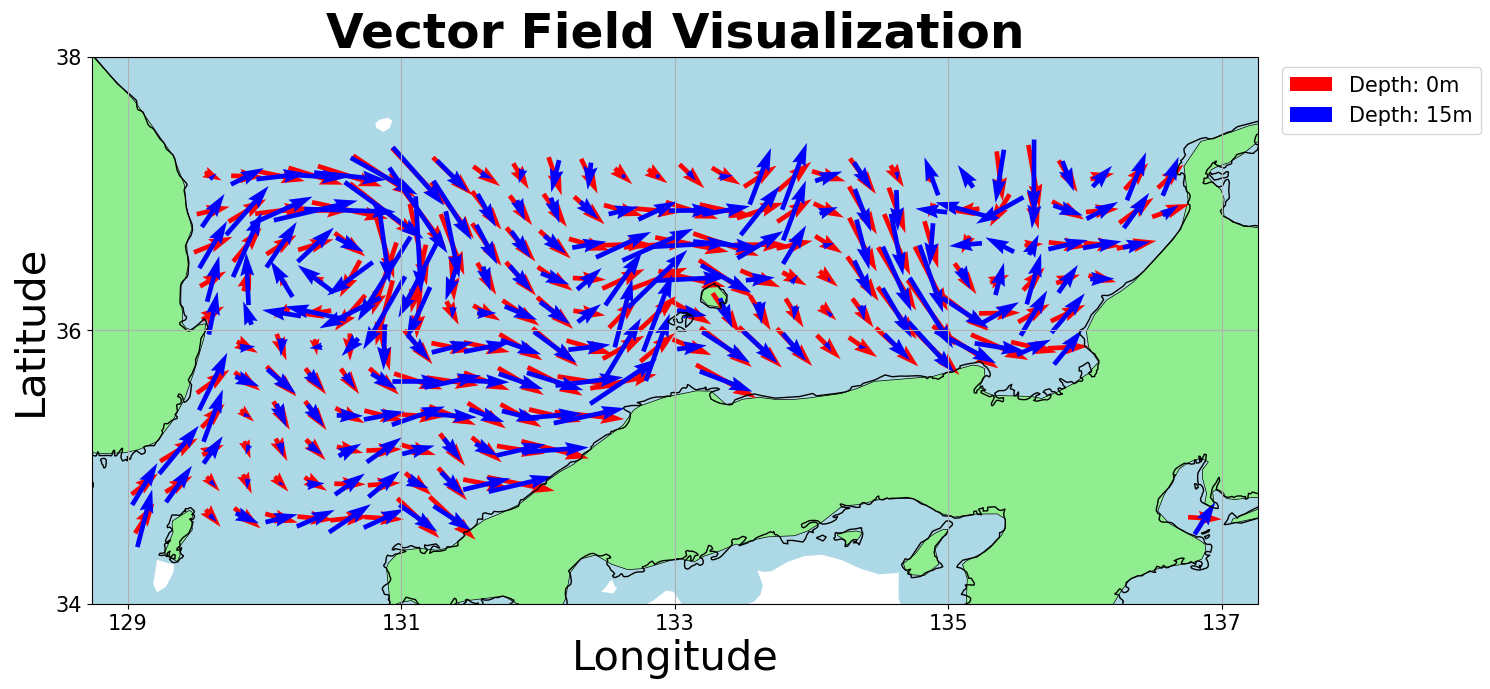

In [18]:
plt.figure(figsize=(15, 10))

# Setting up the plot
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Adding land, coastlines, and borders to the map
# Setting the color of land to green and the color of ocean to light blue
land = cfeature.LAND.with_scale('50m')
ax.add_feature(land, edgecolor='black', facecolor='lightgreen')

ocean = cfeature.OCEAN.with_scale('50m')
ax.add_feature(ocean, facecolor='lightblue')

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Assigning colors for each depth
colors = {0: 'red', 15: 'blue'}

for depth in [0, 15]:
    temp = current_1[current_1['time'] == '2005-02-21 06:00:00']
    temp = temp[temp['depth'] == depth]

    # Removing NaN values
    temp = temp.dropna(subset=['u', 'v'])

    # Extracting latitude, longitude, u, and v values from the dataframe
    lats = temp['latitude'].values
    lons = temp['longitude'].values
    u = temp['u'].values
    v = temp['v'].values
    
    plt.quiver(lons, lats, u, v, pivot='middle', color=colors[depth], label=f'Depth: {depth}m')

plt.title("Vector Field Visualization", fontsize=35, weight='bold')
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1), fontsize=15)
plt.xlabel('Longitude', fontsize=30)
plt.ylabel('Latitude', fontsize=30)

# Setting the xticks and yticks
# Calculating the minimum and maximum latitudes and longitudes of the entire trajectory
min_lat, max_lat = current_1['latitude'].min()-0.5, current_1['latitude'].max()+0.5
min_lon, max_lon = current_1['longitude'].min()-0.5, current_1['longitude'].max()+0.5
ax.set_xticks(np.arange(round(min_lon), round(max_lon) + 0.5, 2))  # Example: Setting x-ticks at 2-degree intervals
ax.set_yticks(np.arange(round(min_lat), round(max_lat) + 0.5, 2))  # Example: Setting y-ticks at 2-degree intervals
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.grid(True)
plt.tight_layout()

# Saving the file
save_path = output_dir + "/Vector_Field_Visualization.png"
plt.savefig(save_path, dpi=300)

plt.show()


In [19]:
def get_neighboring_points(lon, lat, df, visualize=False):
    '''
    Given a longitude and latitude, this function finds the four surrounding points in the dataset.
    It returns these points in counter-clockwise order starting from the bottom-left.
    If visualize is True, it plots the result along with the dataset.
    '''
    
    assert df['latitude'].isna().sum() == 0
    assert df['longitude'].isna().sum() == 0
    
    # Finding unique latitudes and longitudes
    unique_lats = sorted(df['latitude'].unique())
    unique_lons = sorted(df['longitude'].unique())
    
    # Finding the indices of the latitudes and longitudes just less than the given lat and lon
    lat_idx = np.searchsorted(unique_lats, lat) - 1
    lon_idx = np.searchsorted(unique_lons, lon) - 1
    
    # Checking the boundaries and adjusting if necessary
    lat_idx = max(0, min(lat_idx, len(unique_lats) - 2))
    lon_idx = max(0, min(lon_idx, len(unique_lons) - 2))
    
    # Getting the four neighboring points
    bottom_left = (unique_lons[lon_idx], unique_lats[lat_idx])
    bottom_right = (unique_lons[lon_idx + 1], unique_lats[lat_idx])
    top_left = (unique_lons[lon_idx], unique_lats[lat_idx + 1])
    top_right = (unique_lons[lon_idx + 1], unique_lats[lat_idx + 1])
    
    neighbors = [bottom_left, bottom_right, top_right, top_left] # In counter-clockwise order
    
    if visualize:
        
        plt.figure(figsize=(15, 10))

        # Setting up the plot
        fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

        # Adding land, coastlines, and borders to the map
        land = cfeature.LAND.with_scale('50m')
        ax.add_feature(land, edgecolor='black', facecolor='lightgreen')

        ocean = cfeature.OCEAN.with_scale('50m')
        ax.add_feature(ocean, facecolor='lightblue')

        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        
        for point in neighbors:
            plt.scatter(point[0], point[1], s=25, color='green')
        
        plt.scatter(df['longitude'], df['latitude'], s=50, label='Dataset Points', color='blue')
        plt.scatter(lon, lat, s=100, label='Given Point', color='red', marker='x')
        
        plt.title("Given Point Visualization", fontsize=35, weight='bold')
        plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1), fontsize=15)
        plt.xlabel("Longitude", fontsize=30)
        plt.ylabel("Latitude", fontsize=30)

        # Setting the xticks and yticks
        # Calculating the minimum and maximum latitudes and longitudes of the entire trajectory
        min_lat, max_lat = df['latitude'].min()-0.5, df['latitude'].max()+0.5
        min_lon, max_lon = df['longitude'].min()-0.5, df['longitude'].max()+0.5
        ax.set_xticks(np.arange(round(min_lon), round(max_lon) + 0.5, 2))
        ax.set_yticks(np.arange(round(min_lat), round(max_lat) + 0.5, 2))
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)

        plt.grid(True)
        plt.tight_layout()

        # Saving the file
        save_path = output_dir + "/Given_Point_Visualization.png"
        plt.savefig(save_path, dpi=300)

        plt.show()
    
    return neighbors


In [20]:
def find_nearest_point_value(lon, lat, df, column):
    """
    Find the value of the nearest non-NaN point in the dataset for the given longitude and latitude.
    """
    # Calculate the distance to each point in the dataset
    distances = np.sqrt((df['longitude'] - lon) ** 2 + (df['latitude'] - lat) ** 2)
    
    # Sort distances and get corresponding indices
    sorted_indices = distances.sort_values().index
    
    # Iterate over the sorted indices
    for idx in sorted_indices:
        value = df.loc[idx, column]
        if not np.isnan(value):
            return value
    
    # If all values are NaN, return NaN
    return np.nan


In [21]:
def bilinear_interpolation(x, y, points):
    ''' 
    Perform bilinear interpolation for a given x, y, and set of points.
    Points is a list of four tuples containing (x, y, value) in the order:
    bottom-left, bottom-right, top-right, top-left.
    '''
    x1, y1, q11 = points[0]  # bottom-left
    x2, y2, q21 = points[1]  # bottom-right
    x3, y3, q22 = points[2]  # top-right
    x4, y4, q12 = points[3]  # top-left
    
    # Bilinear interpolation formula
    interpolated_value = (q11 * (x2 - x) * (y3 - y) +
                          q21 * (x - x1) * (y3 - y) +
                          q12 * (x2 - x) * (y - y1) +
                          q22 * (x - x1) * (y - y1)) / ((x2 - x1) * (y3 - y1))
    
    return interpolated_value

Processing drifters: 100%|█████████████████████████████████████████████████████████████| 31/31 [24:53<00:00, 48.18s/it]


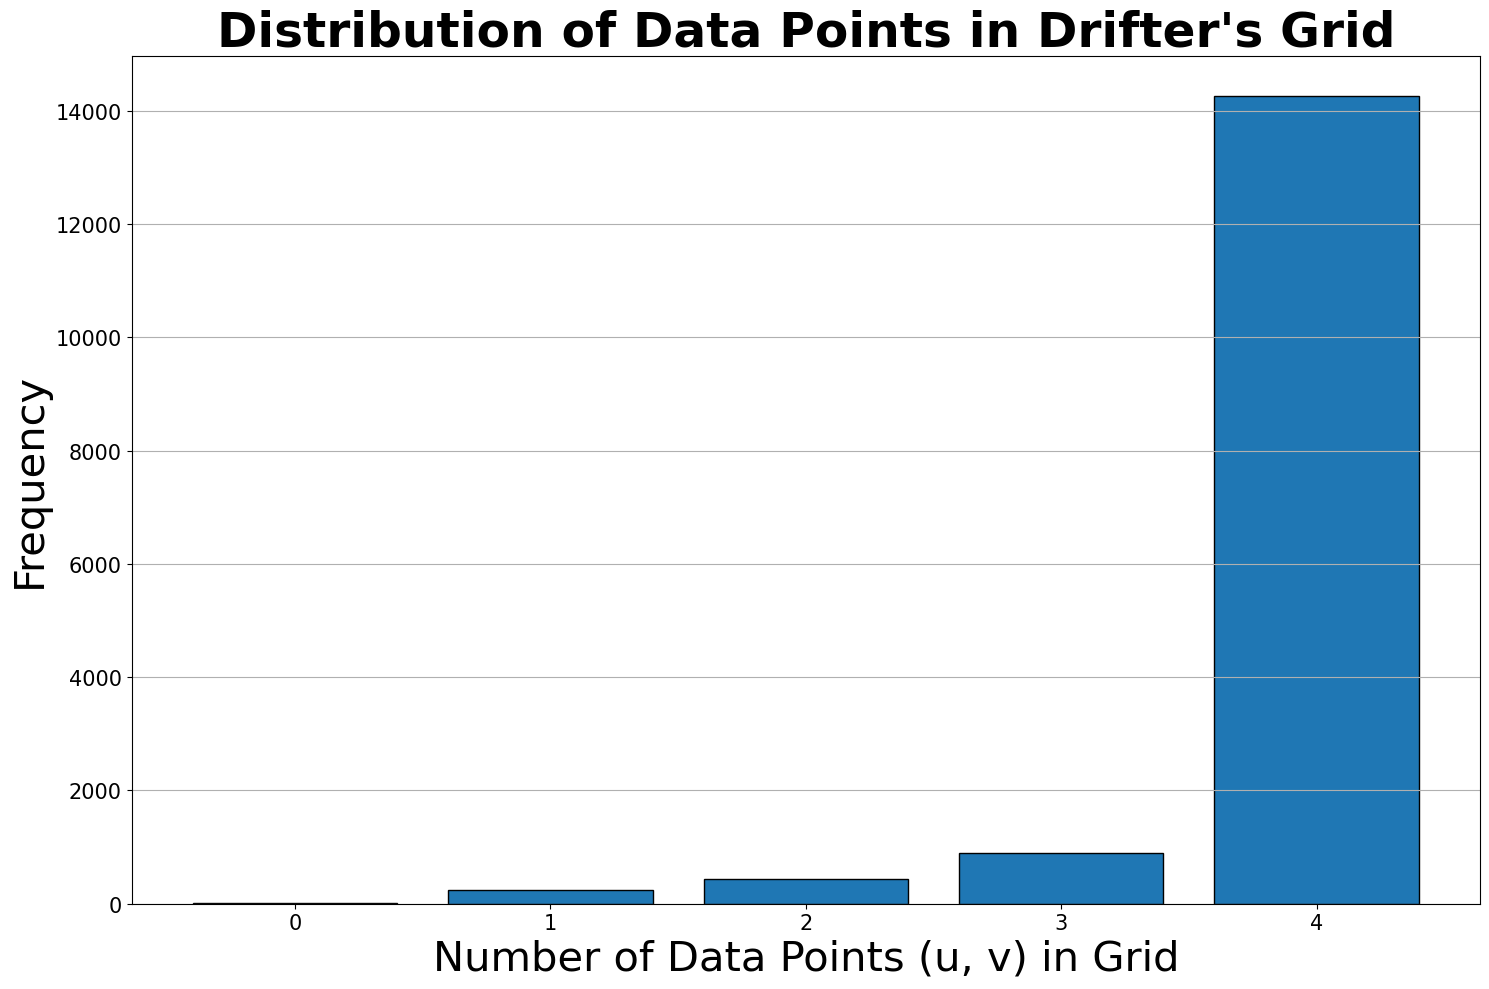

In [22]:
# Function to find the center of a 0.25 degree grid
def find_nearest_grid_point(lat, lon):
    return round(lat * 4) / 4, round(lon * 4) / 4

# List to store the count of uo, vo data points in the grid for each location of the drifter
data_points_count = []

# Using tqdm to show the progress of the for loop
for i in tqdm(range(1, 32), desc="Processing drifters"):
    drifter_df = globals()[f'drifter_{i}']
    current_df = globals()[f'current_{i}']

    for _, row in drifter_df.iterrows():
        lat, lon = row['lats'], row['lons']
        nearest_lat, nearest_lon = find_nearest_grid_point(lat, lon)

        grid_points = [(nearest_lat + 0.125, nearest_lon - 0.125),
                       (nearest_lat + 0.125, nearest_lon + 0.125),
                       (nearest_lat - 0.125, nearest_lon - 0.125),
                       (nearest_lat - 0.125, nearest_lon + 0.125)]

        count = 0
        for point in grid_points:
            subset = current_df[(current_df['latitude'] == point[0]) & (current_df['longitude'] == point[1])]
            if not subset['u'].isna().all() and not subset['v'].isna().all():
                count += 1

        data_points_count.append(count)

# Visualizing the distribution of data points count
plt.figure(figsize=(15, 10))
plt.hist(data_points_count, bins=np.arange(6)-0.5, edgecolor='black', align='mid', rwidth=0.8)

plt.title("Distribution of Data Points in Drifter's Grid", fontsize=35, weight='bold')
plt.xlabel("Number of Data Points (u, v) in Grid", fontsize=30)
plt.ylabel("Frequency", fontsize=30)
plt.xticks(range(5), fontsize=15)
plt.yticks(fontsize=15)

plt.grid(axis='y')
plt.tight_layout()

# Saving the file
save_path = output_dir + "/Distribution_of_Data_Points.png"
plt.savefig(save_path, dpi=300)

plt.show()


<Figure size 1500x1000 with 0 Axes>

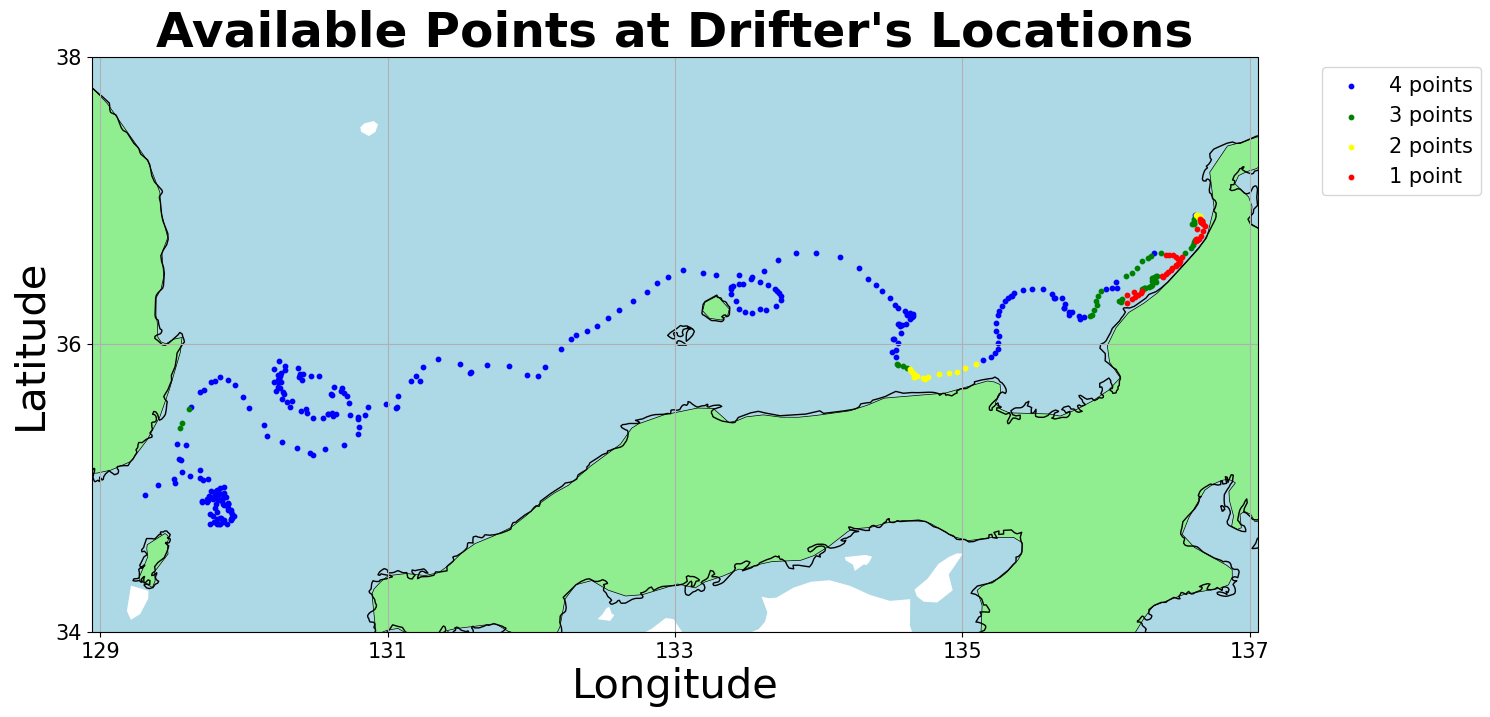

In [23]:
# Removing rows with NaN values in the current data
current_1_cleaned = current_1.dropna(subset=['u', 'v']).reset_index(drop=True)

# List to store the count of uo, vo data points in the grid for each location of the drifter
data_points_count_cleaned = []
locations_4 = []  # Locations with 4 data points
locations_3 = []  # Locations with 3 data points
locations_2 = []  # Locations with 2 data points
locations_1 = []  # Locations with 1 data point

for _, row in drifter_1.iterrows():
    lat, lon = row['lats'], row['lons']
    nearest_lat, nearest_lon = find_nearest_grid_point(lat, lon)
    
    # Finding the 4 grid points within the grid
    grid_points = [(nearest_lat + 0.125, nearest_lon - 0.125),
                   (nearest_lat + 0.125, nearest_lon + 0.125),
                   (nearest_lat - 0.125, nearest_lon - 0.125),
                   (nearest_lat - 0.125, nearest_lon + 0.125)]
    
    count = 0
    for point in grid_points:
        subset = current_1_cleaned[(current_1_cleaned['longitude'] == point[1]) & (current_1_cleaned['latitude'] == point[0])]
        # Increase the count if both u and v data are available at the grid point
        if not subset.empty:
            count += 1
            
    data_points_count_cleaned.append(count)
    
    # Storing location information according to each case
    if count == 4:
        locations_4.append((lon, lat))
    elif count == 3:
        locations_3.append((lon, lat))
    elif count == 2:
        locations_2.append((lon, lat))
    elif count == 1:
        locations_1.append((lon, lat))


plt.figure(figsize=(15, 10))
    
# Setting up the plot
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Adding land, coastlines, and borders to the map
land = cfeature.LAND.with_scale('50m')
ax.add_feature(land, edgecolor='black', facecolor='lightgreen')

ocean = cfeature.OCEAN.with_scale('50m')
ax.add_feature(ocean, facecolor='lightblue')

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

if locations_4:
    ax.scatter(*zip(*locations_4), color='blue', s=10, label='4 points')
if locations_3:
    ax.scatter(*zip(*locations_3), color='green', s=10, label='3 points')
if locations_2:
    ax.scatter(*zip(*locations_2), color='yellow', s=10, label='2 points')
if locations_1:
    ax.scatter(*zip(*locations_1), color='red', s=10, label='1 point')


plt.title("Available Points at Drifter's Locations", fontsize=35, weight='bold')
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1), fontsize=15)
plt.xlabel('Longitude', fontsize=30)
plt.ylabel('Latitude', fontsize=30)

# Setting xticks and yticks
# Calculating the minimum and maximum latitudes and longitudes of the entire trajectory
min_lat, max_lat = current_1['latitude'].min()-0.5, current_1['latitude'].max()+0.5
min_lon, max_lon = current_1['longitude'].min()-0.5, current_1['longitude'].max()+0.5
ax.set_xticks(np.arange(round(min_lon), round(max_lon) + 0.5, 2))
ax.set_yticks(np.arange(round(min_lat), round(max_lat) + 0.5, 2))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.grid(True)
plt.tight_layout()

# Saving the file
save_path = output_dir + "/Available_Points.png"
plt.savefig(save_path, dpi=300)

plt.show()


<Figure size 1500x1000 with 0 Axes>

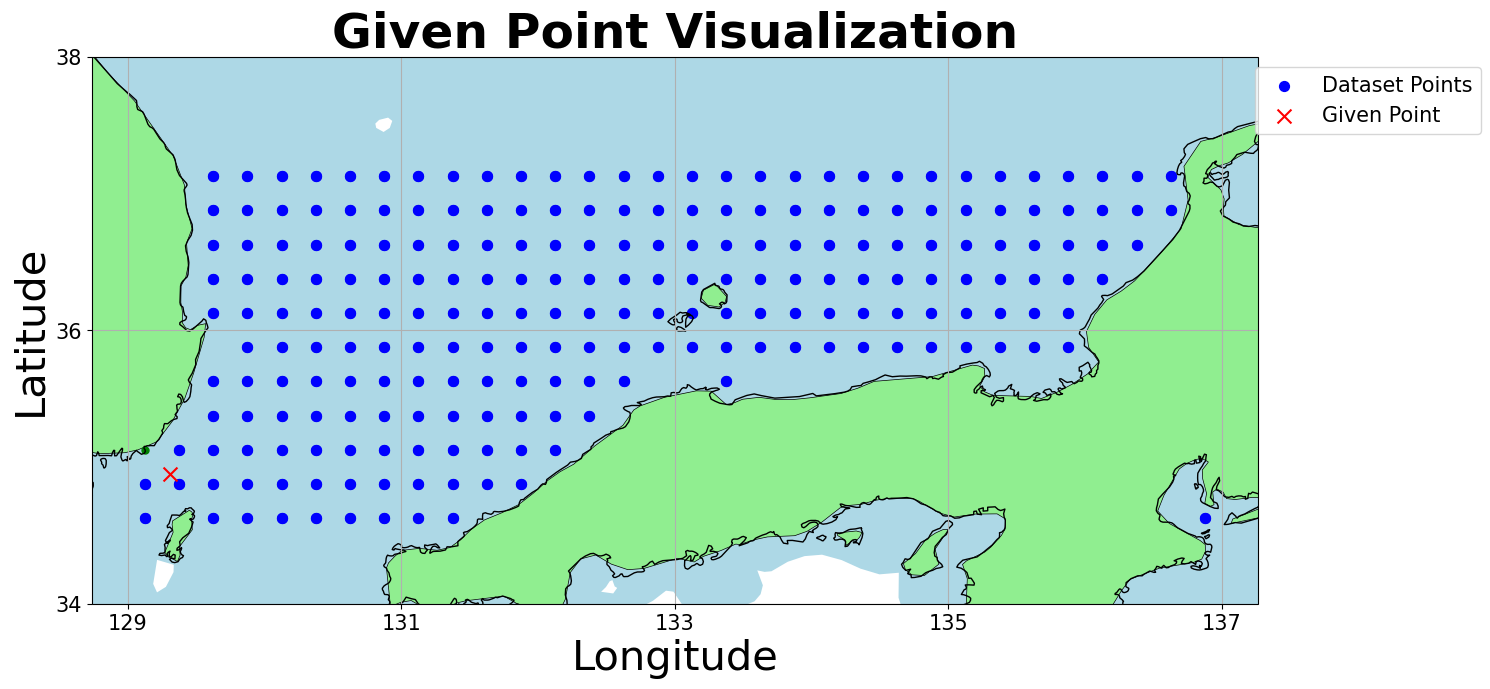

[(129.125, 34.875), (129.375, 34.875), (129.375, 35.125), (129.125, 35.125)]


In [24]:
for index, row in drifter_1.iterrows():
    lon, lat, time = row['lons'], row['lats'], row['time']
    
    # Extract the data for the given time
    drop_current_1 = current_1.dropna()
    time_data = drop_current_1[drop_current_1['time'] == time]
    
    # Get the four surrounding points for the given lat and lon
    points = get_neighboring_points(lon, lat, time_data, True)
    print(points)
    break

In [25]:
def get_interpolated_values(lon, lat, time_data, u_column, v_column):
    points = get_neighboring_points(lon, lat, time_data)
    
    values_u = [row.values[0] if not row.empty else np.nan for row in [time_data[(time_data['longitude'] == point[0]) & (time_data['latitude'] == point[1])][u_column] for point in points]]
    values_v = [row.values[0] if not row.empty else np.nan for row in [time_data[(time_data['longitude'] == point[0]) & (time_data['latitude'] == point[1])][v_column] for point in points]]

    u_interpolated, v_interpolated = None, None

    if all(not np.isnan(value) for sublist in [values_u, values_v] for value in sublist):
        u_interpolated = bilinear_interpolation(lon, lat, [(point[0], point[1], value) for point, value in zip(points, values_u)])
        v_interpolated = bilinear_interpolation(lon, lat, [(point[0], point[1], value) for point, value in zip(points, values_v)])
    else:
        u_interpolated = find_nearest_point_value(lon, lat, time_data, u_column)
        v_interpolated = find_nearest_point_value(lon, lat, time_data, v_column)

    return u_interpolated, v_interpolated



In [26]:

def interpolate_drifter_data(input_df, drifter_df):
    interpolated_dfs = []  # To collect separate dataframes based on depth

    has_depth = 'depth' in input_df.columns

    for idx, row in drifter_df.iterrows():
        lon, lat, time = row['lons'], row['lats'], row['time']

        if has_depth:
            for depth in input_df['depth'].unique():
                time_data = input_df[(input_df['depth'] == depth) & (input_df['time'] == time)]
                u_interpolated, v_interpolated = get_interpolated_values(lon, lat, time_data, 'u', 'v')
                row[f'current_u{depth}_interpolated'] = u_interpolated
                row[f'current_v{depth}_interpolated'] = v_interpolated
            interpolated_dfs.append(row)
        else:
            time_data = input_df[input_df['time'] == time]
            u_interpolated, v_interpolated = get_interpolated_values(lon, lat, time_data, 'u', 'v')
            row['wind_u_interpolated'] = u_interpolated
            row['wind_v_interpolated'] = v_interpolated
            interpolated_dfs.append(row)

    return pd.DataFrame(interpolated_dfs)

In [27]:
# Applying the function:

for i in tqdm(range(1, 32), desc="Processing datasets"):
    input_df = eval(f'current_{i}')
    drifter_df = eval(f'drifter_{i}')
    
    interpolated_df = interpolate_drifter_data(input_df, drifter_df)
    
    globals()[f'merged_drifter_{i}'] = interpolated_df


Processing datasets: 100%|█████████████████████████████████████████████████████████████| 31/31 [36:17<00:00, 70.24s/it]


In [28]:
for i in tqdm(range(1, 32), desc="Processing datasets"):
    input_df = eval(f'wind_{i}')
    drifter_df = eval(f'merged_drifter_{i}')
    
    interpolated_df = interpolate_drifter_data(input_df, drifter_df)
    
    globals()[f'merged_drifter_{i}'] = interpolated_df

Processing datasets: 100%|█████████████████████████████████████████████████████████████| 31/31 [04:39<00:00,  9.01s/it]


In [29]:
# Creating a list of merged_drifter_i dataframes using list comprehension
dataframes_to_concat = [globals()[f'merged_drifter_{i}'] for i in range(1, 32)]

# Merging the dataframes
all_merged_drifter = pd.concat(dataframes_to_concat)


In [30]:
# Print DataFrame information
info_output = all_merged_drifter.info()

# Check for null or NaN values
null_values = all_merged_drifter.isnull().sum()

info_output, null_values


<class 'pandas.core.frame.DataFrame'>
Index: 15845 entries, 0 to 1165
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   drifter                   15845 non-null  float64       
 1   lons                      15845 non-null  float64       
 2   lats                      15845 non-null  float64       
 3   time                      15845 non-null  datetime64[ns]
 4   current_u0_interpolated   15845 non-null  float64       
 5   current_v0_interpolated   15845 non-null  float64       
 6   current_u15_interpolated  15845 non-null  float64       
 7   current_v15_interpolated  15845 non-null  float64       
 8   wind_u_interpolated       15845 non-null  float64       
 9   wind_v_interpolated       15845 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 1.3 MB


(None,
 drifter                     0
 lons                        0
 lats                        0
 time                        0
 current_u0_interpolated     0
 current_v0_interpolated     0
 current_u15_interpolated    0
 current_v15_interpolated    0
 wind_u_interpolated         0
 wind_v_interpolated         0
 dtype: int64)

In [31]:
# Save the DataFrame to a CSV file
all_merged_drifter.to_csv("./data/final_drifter.csv", index=False)


In [32]:
final_drifter = pd.read_csv("./data/final_drifter.csv")
final_drifter

drifter        lons       lats                 time  \
0          1.0  129.311005  34.950001  2005-02-21 06:00:00   
1          1.0  129.401993  35.020000  2005-02-21 12:00:00   
2          1.0  129.514008  35.061001  2005-02-21 18:00:00   
3          1.0  129.524002  35.032001  2005-02-22 00:00:00   
4          1.0  129.626007  35.083000  2005-02-22 06:00:00   
...        ...         ...        ...                  ...   
15840     31.0  147.348999  44.167999  2006-10-01 00:00:00   
15841     31.0  147.307007  44.138000  2006-10-01 06:00:00   
15842     31.0  147.250000  44.146999  2006-10-01 12:00:00   
15843     31.0  147.322998  44.201000  2006-10-01 18:00:00   
15844     31.0  147.417007  44.195999  2006-10-02 00:00:00   

       current_u0_interpolated  current_v0_interpolated  \
0                     0.145958                 0.086236   
1                     0.133808                 0.110518   
2                     0.108248                 0.074440   
3                     0.113265                 0.134209   
4                     0.260204                 0.179209   
...                        ...                      ...   
15840                 0.076689                -0.076521   
15841                 0.085218                -0.078659   
15842                 0.084132                -0.061532   
15843                 0.067537                -0.049813   
15844                 0.058046                -0.041454   

       current_u15_interpolated  current_v15_interpolated  \
0                      0.096571                  0.135889   
1                      0.106014                  0.160538   
2                      0.081384                  0.123742   
3                      0.080813                  0.131827   
4                      0.137799                  0.108007   
...                         ...                       ...   
15840                  0.055621                 -0.080749   
15841                  0.061210                 -0.081402   
15842                  0.065086                 -0.069302   
15843                  0.056426                 -0.066027   
15844                  0.058718                 -0.070479   

       wind_u_interpolated  wind_v_interpolated  
0                 6.490678            -0.313593  
1                 4.163806            -1.399033  
2                 4.106759            -1.669003  
3                 1.312693             0.401304  
4                 5.700327             8.951523  
...                    ...                  ...  
15840             3.390951             1.204701  
15841             2.472012             1.755346  
15842             1.961223             3.142489  
15843             0.383844             3.807814  
15844            -1.343823             4.117646  

[15845 rows x 10 columns]

# trajectory_clustering

In [33]:
# Load the data
final_drifter = pd.read_csv('./data/final_drifter.csv')
final_drifter.head()


drifter        lons       lats                 time  \
0      1.0  129.311005  34.950001  2005-02-21 06:00:00   
1      1.0  129.401993  35.020000  2005-02-21 12:00:00   
2      1.0  129.514008  35.061001  2005-02-21 18:00:00   
3      1.0  129.524002  35.032001  2005-02-22 00:00:00   
4      1.0  129.626007  35.083000  2005-02-22 06:00:00   

   current_u0_interpolated  current_v0_interpolated  current_u15_interpolated  \
0                 0.145958                 0.086236                  0.096571   
1                 0.133808                 0.110518                  0.106014   
2                 0.108248                 0.074440                  0.081384   
3                 0.113265                 0.134209                  0.080813   
4                 0.260204                 0.179209                  0.137799   

   current_v15_interpolated  wind_u_interpolated  wind_v_interpolated  
0                  0.135889             6.490678            -0.313593  
1                  0.160538             4.163806            -1.399033  
2                  0.123742             4.106759            -1.669003  
3                  0.131827             1.312693             0.401304  
4                  0.108007             5.700327             8.951523

In [34]:
# Downsample by selecting every 10th data point
drifter_ds = final_drifter.groupby('drifter').apply(lambda group: group.iloc[::10]).reset_index(drop=True)
drifter_ds.head()


drifter        lons       lats                 time  \
0      1.0  129.311005  34.950001  2005-02-21 06:00:00   
1      1.0  129.891006  34.889000  2005-02-23 18:00:00   
2      1.0  129.843002  34.791000  2005-02-26 06:00:00   
3      1.0  129.929001  34.805000  2005-02-28 18:00:00   
4      1.0  129.854996  34.932999  2005-03-03 06:00:00   

   current_u0_interpolated  current_v0_interpolated  current_u15_interpolated  \
0                 0.145958                 0.086236                  0.096571   
1                -0.098040                -0.007209                 -0.045276   
2                 0.011700                -0.114575                 -0.010776   
3                 0.006856                -0.149750                 -0.006787   
4                -0.018923                -0.078005                 -0.017593   

   current_v15_interpolated  wind_u_interpolated  wind_v_interpolated  
0                  0.135889             6.490678            -0.313593  
1                  0.019127            -4.076176            -6.229690  
2                 -0.019674             3.477082            -4.936436  
3                 -0.026409             2.394022            -6.673293  
4                 -0.003446            -0.266787            -5.885399

In [35]:
# Implementing DTW (Dynamic Time Warping)
def dtw(x, y, dist=euclidean):
    n = len(x)
    m = len(y)
    dtw_matrix = np.zeros((n+1, m+1))
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0

    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = dist(x[i-1], y[j-1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1])
            
    return dtw_matrix[n, m]

# Dynamic Time Warping (DTW):
# Pros: DTW warps the time axis to find the optimal alignment between two time series, which can be useful for trajectory data that may stretch or compress over time. In other words, even if the drifters move at different speeds, their patterns can be compared.
# Cons: It has high computational complexity. It can be slow for long time series data.


In [36]:
# Extracting time series data for each drifter
paths = drifter_ds.groupby('drifter').apply(lambda group: group[['lons', 'lats']].values).to_list()
num_drifters = len(paths)

# Initializing the DTW distance matrix
distance_matrix = np.zeros((num_drifters, num_drifters))

# Calculating DTW distances
for i in range(num_drifters):
    for j in range(num_drifters):
        if i <= j:
            distance = dtw(paths[i], paths[j], dist=minkowski)
            distance_matrix[i, j] = distance_matrix[j, i] = distance

distance_matrix[:5, :5]  # Displaying the first 5x5 portion to verify


array([[  0.        ,  82.26135052,  82.30510711,  67.98558386,
         38.36266251],
       [ 82.26135052,   0.        , 176.23797547, 161.52272249,
         38.66296625],
       [ 82.30510711, 176.23797547,   0.        ,   1.91309448,
        120.58856004],
       [ 67.98558386, 161.52272249,   1.91309448,   0.        ,
        103.38350356],
       [ 38.36266251,  38.66296625, 120.58856004, 103.38350356,
          0.        ]])

C:\Users\ckgks\AppData\Local\Temp\ipykernel_15972\2723442736.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method="ward")


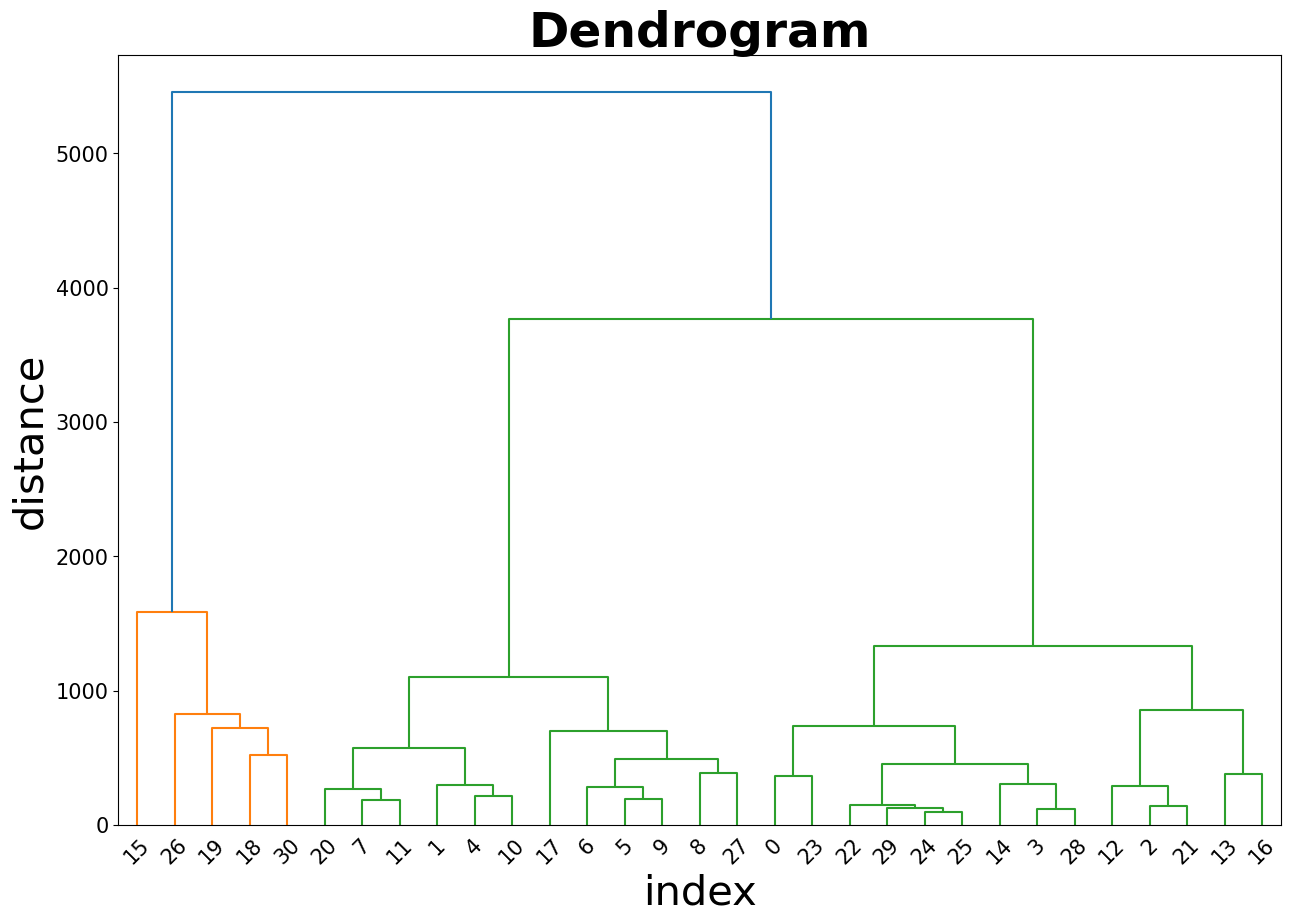

In [37]:
# Generating a linkage matrix for hierarchical clustering
linkage_matrix = linkage(distance_matrix, method="ward")

# Drawing the dendrogram
plt.figure(figsize=(15, 10))
dendrogram(linkage_matrix)
plt.title('Dendrogram', fontsize=35, weight='bold')
plt.xlabel('index', fontsize=30)
plt.ylabel('distance', fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()


In [38]:
# Setting the number of clusters to 3 and performing clustering
cluster_assignment = fcluster(linkage_matrix, 3, criterion='maxclust')

# Verifying the cluster assignment results for each drifter
cluster_result = pd.DataFrame({'drifter': drifter_ds['drifter'].unique(), 'cluster': cluster_assignment})
cluster_result

cluster_result.transpose()


0    1    2    3    4    5    6    7    8     9   ...    21    22  \
drifter  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  ...  22.0  23.0   
cluster  3.0  2.0  3.0  3.0  2.0  2.0  2.0  2.0  2.0   2.0  ...   3.0   3.0   

           23    24    25    26    27    28    29    30  
drifter  24.0  25.0  26.0  27.0  28.0  29.0  30.0  31.0  
cluster   3.0   3.0   3.0   1.0   2.0   3.0   3.0   1.0  

[2 rows x 31 columns]

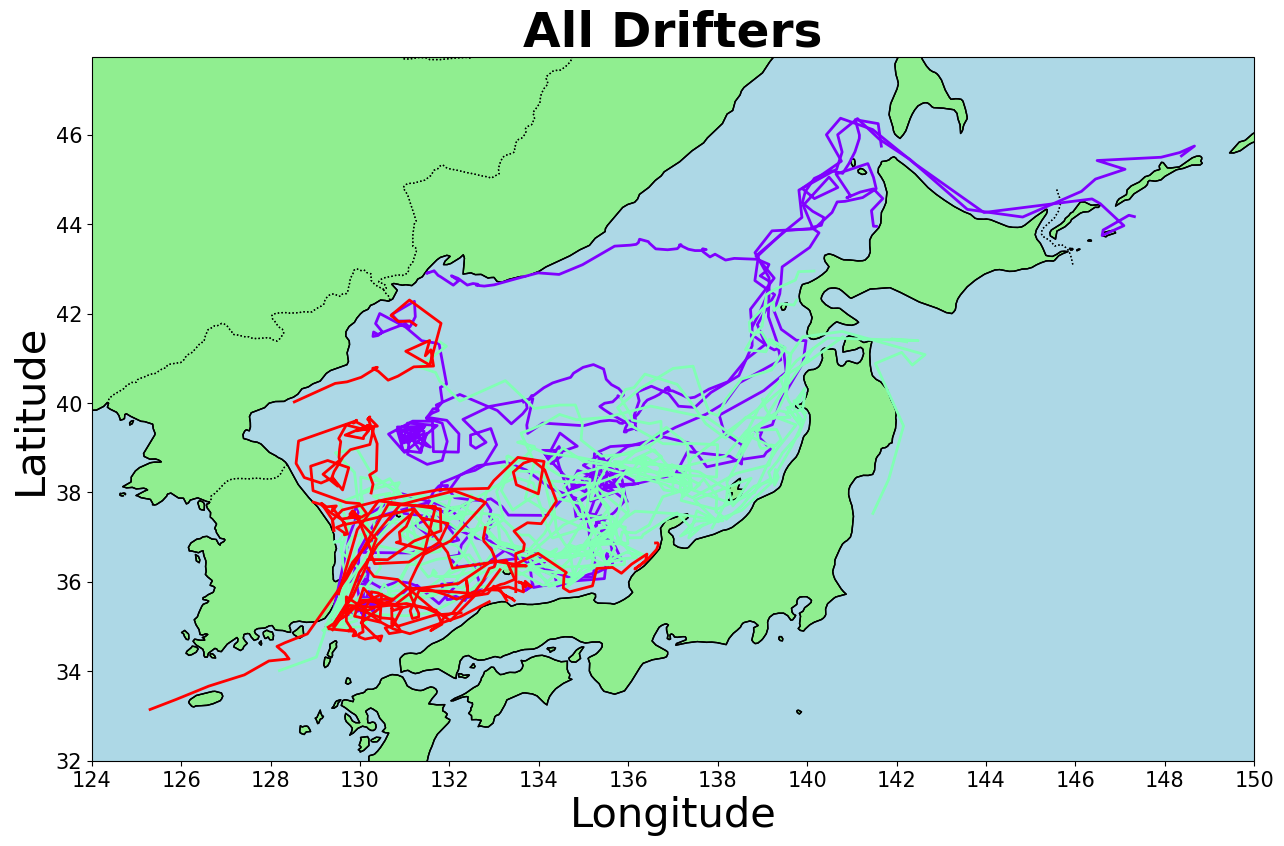

In [39]:
# Calculating the minimum and maximum latitudes and longitudes for the entire trajectory
min_lat, max_lat = drifter_ds['lats'].min() - 1, drifter_ds['lats'].max() + 1
min_lon, max_lon = drifter_ds['lons'].min() - 1, drifter_ds['lons'].max() + 1

# Drawing the paths of all drifters
def plot_paths_with_cartopy(cluster_data, cluster_colors):
    """Function to draw drifter paths on a map using cartopy"""
    plt.figure(figsize=(15, 10))
    
    # Setting up the map
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([min_lon, max_lon, min_lat, max_lat])
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.set_title('All Drifters', fontsize=35, weight='bold')
    
    land = cfeature.LAND.with_scale('50m')
    ax.add_feature(land, edgecolor='black', facecolor='lightgreen')

    ocean = cfeature.OCEAN.with_scale('50m')
    ax.add_feature(ocean, facecolor='lightblue')

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    plt.xlabel('Longitude', fontsize=30)
    plt.ylabel('Latitude', fontsize=30)

    # Setting xticks and yticks
    ax.set_xticks(np.arange(round(min_lon), round(max_lon) + 1, 2))  # Example: Set x ticks at 5 degree intervals
    ax.set_yticks(np.arange(round(min_lat), round(max_lat) + 1, 2))  # Example: Set y ticks at 5 degree intervals
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    # Drawing the paths
    for cluster_id, color in enumerate(cluster_colors):
        cluster = cluster_data[cluster_data['drifter'].isin(cluster_result[cluster_result['cluster'] == cluster_id + 1]['drifter'])]
        for _, group in cluster.groupby('drifter'):
            path = group[['lons', 'lats']].values
            ax.plot(path[:, 0], path[:, 1], color=color, linewidth=2)
    
    # Saving the figure to a PNG file
    plt.savefig("./output/All_clusters.png", dpi=300, bbox_inches="tight")
    plt.show()
    
num_clusters = len(np.unique(cluster_result['cluster']))
colors = cm.rainbow(np.linspace(0, 1, num_clusters))

# Map showing all clusters
plot_paths_with_cartopy(drifter_ds, colors)


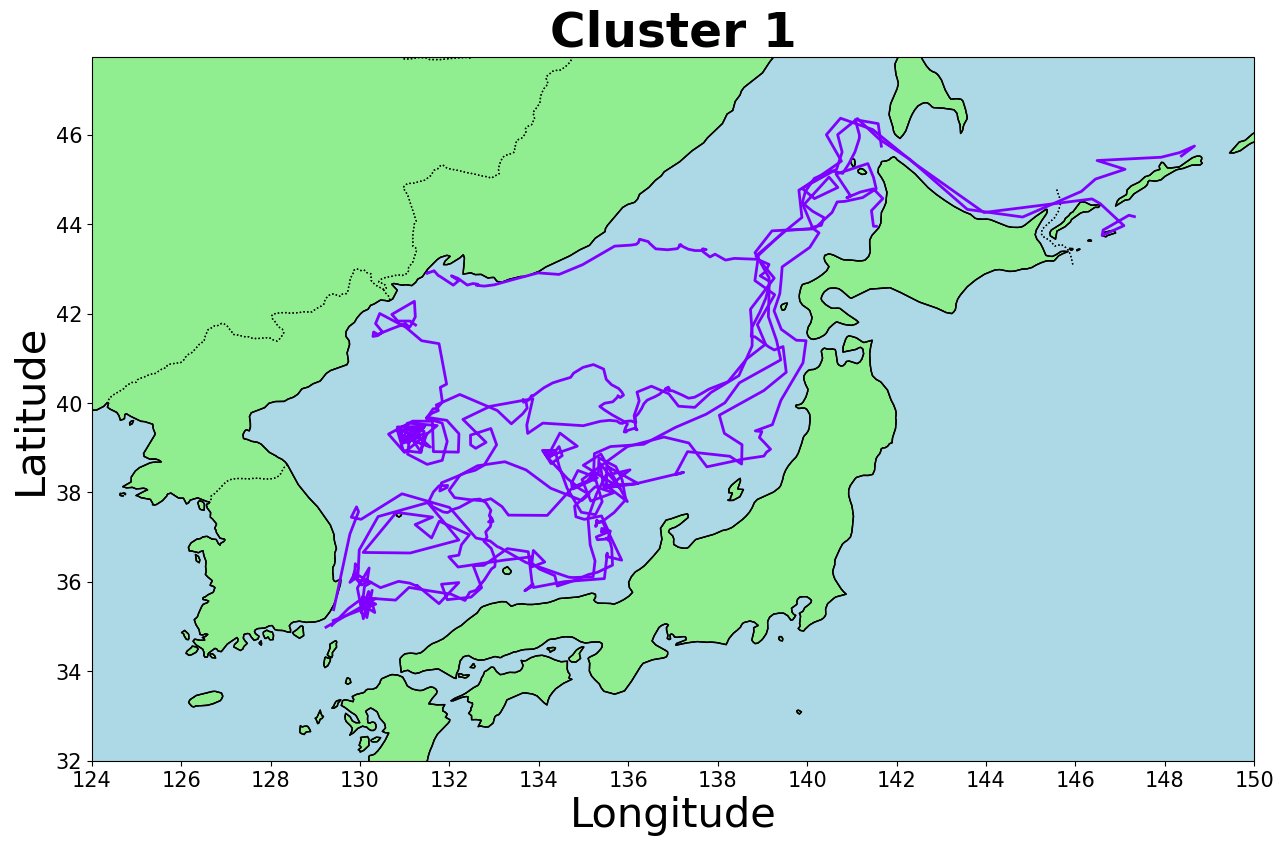

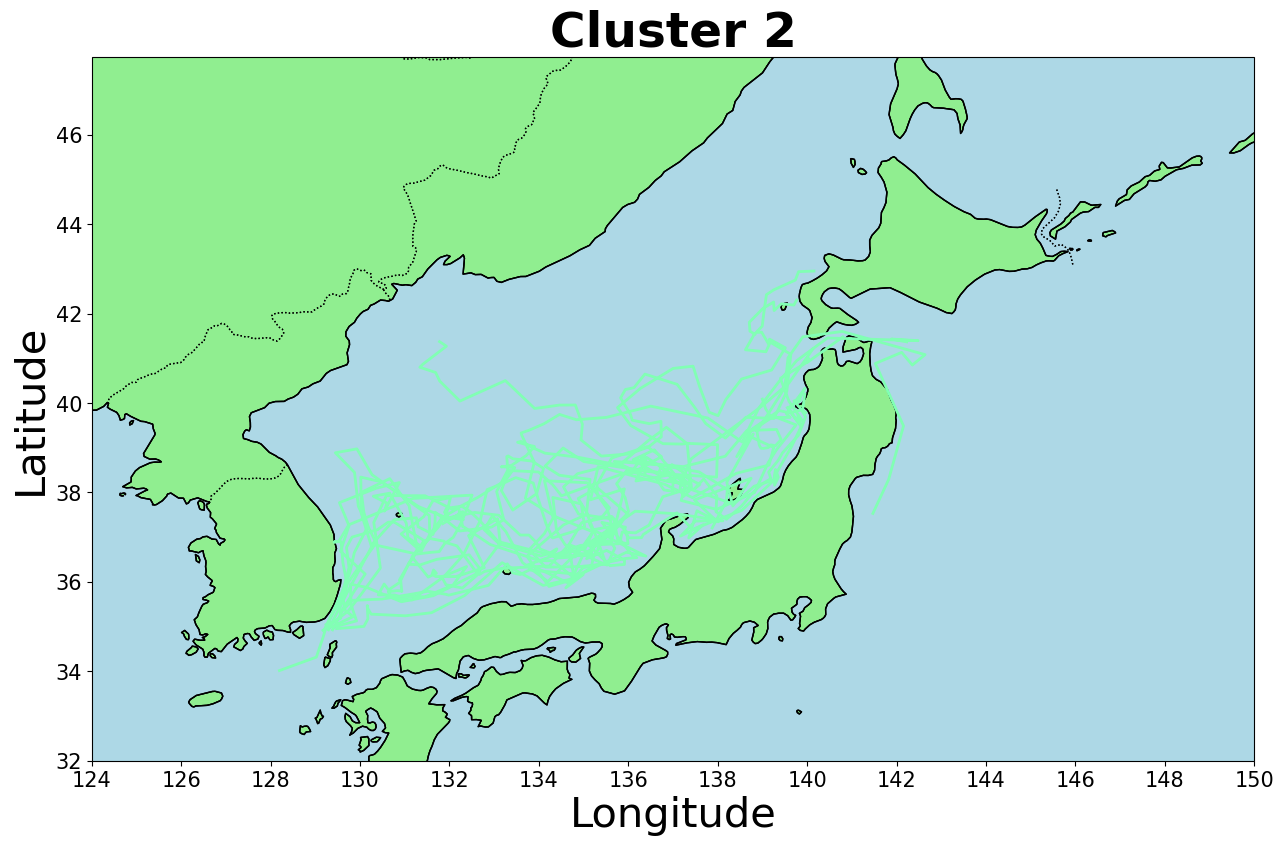

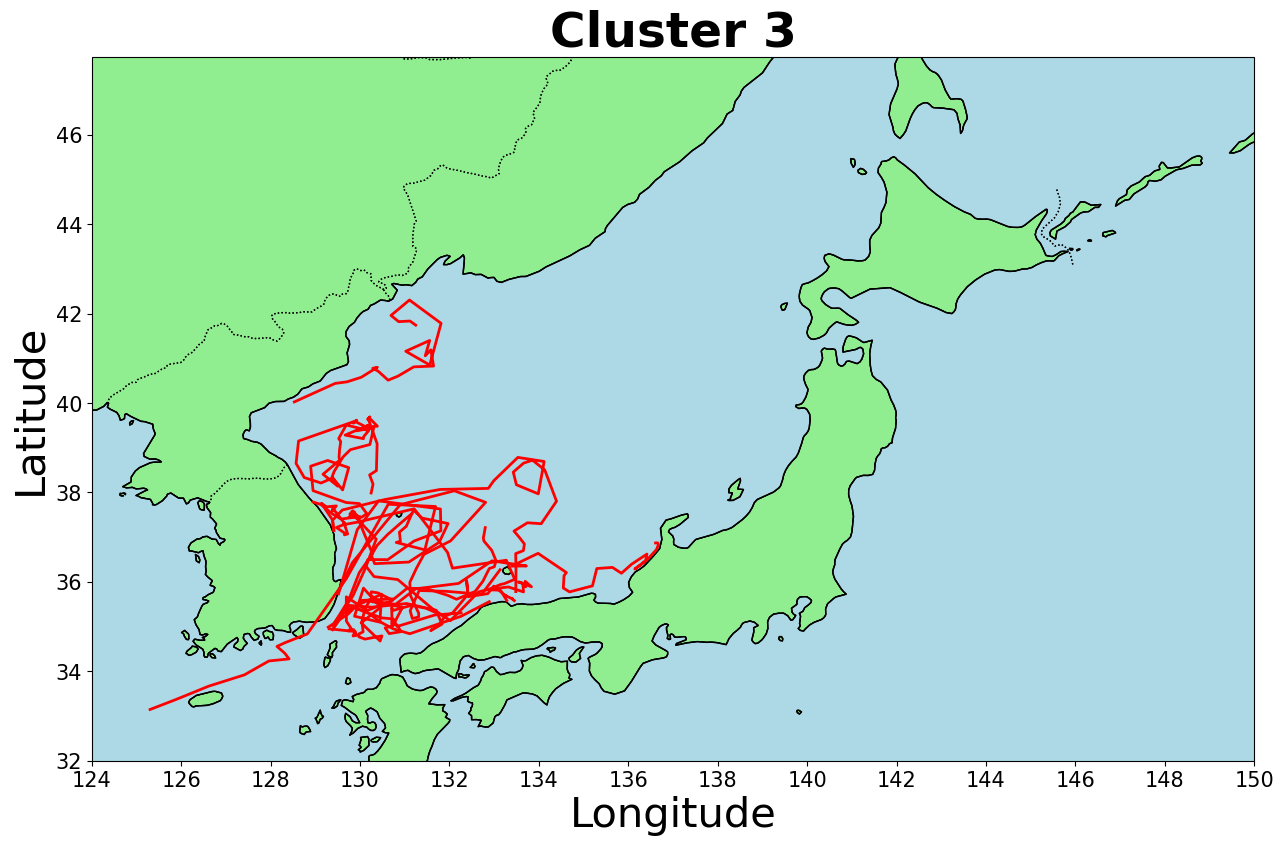

In [40]:
# Drawing trajectories for each cluster
def plot_cluster_with_cartopy(cluster_data, color, title):
    """Function to draw drifter paths on a map using cartopy"""
    fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Setting the map range (using the minimum and maximum latitudes and longitudes of the entire trajectory)
    ax.set_extent([min_lon, max_lon, min_lat, max_lat])
    
    # Basic map settings
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    
    land = cfeature.LAND.with_scale('50m')
    ax.add_feature(land, edgecolor='black', facecolor='lightgreen')

    ocean = cfeature.OCEAN.with_scale('50m')
    ax.add_feature(ocean, facecolor='lightblue')

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    # Drawing the trajectories
    for _, group in cluster_data.groupby('drifter'):
        path = group[['lons', 'lats']].values
        ax.plot(path[:, 0], path[:, 1], color=color, linewidth=2)

    ax.set_title(title, fontsize=35, weight='bold')
    
    plt.xlabel('Longitude', fontsize=30)
    plt.ylabel('Latitude', fontsize=30)

    # Setting xticks and yticks
    ax.set_xticks(np.arange(round(min_lon), round(max_lon) + 1, 2))  # Example: Set x ticks at 5 degree intervals
    ax.set_yticks(np.arange(round(min_lat), round(max_lat) + 1, 2))  # Example: Set y ticks at 5 degree intervals
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    
    # Saving the figure to a PNG file
    plt.savefig(f'./output/cluster_{cluster_id + 1}.png', dpi=300, bbox_inches="tight")
    plt.show()

# Drawing maps for each cluster
for cluster_id, color in enumerate(colors):
    cluster_data = drifter_ds[drifter_ds['drifter'].isin(cluster_result[cluster_result['cluster'] == cluster_id + 1]['drifter'])]
    plot_cluster_with_cartopy(cluster_data, color, f'Cluster {cluster_id + 1}')


In [42]:
def plot_drifter_path(drifter_data, cluster_id, colors, title, extent, save_path):
    """Function to draw drifter paths on a map using cartopy"""
    fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Setting the map range
    ax.set_extent(extent)
    
    # Basic map settings
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    
    land = cfeature.LAND.with_scale('50m')
    ax.add_feature(land, edgecolor='black', facecolor='lightgreen')

    ocean = cfeature.OCEAN.with_scale('50m')
    ax.add_feature(ocean, facecolor='lightblue')

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    # Drawing the trajectory
    path = drifter_data[['lons', 'lats']].values
    ax.plot(path[:, 0], path[:, 1], color=colors[cluster_id - 1], linewidth=2)

    ax.set_title(title, fontsize=15)
    plt.savefig(save_path)
    plt.close()

# Finding the minimum and maximum longitudes and latitudes of the entire drifter data to set the map range
min_lon, max_lon = drifter_ds['lons'].min(), drifter_ds['lons'].max()
min_lat, max_lat = drifter_ds['lats'].min(), drifter_ds['lats'].max()
extent = [min_lon, max_lon, min_lat, max_lat]

# Specifying colors for each cluster
num_clusters = cluster_result['cluster'].max()
colors = plt.cm.viridis(np.linspace(0, 1, num_clusters))

# Drawing maps for each drifter and saving them as files
for drifter_id in drifter_ds['drifter'].unique():
    drifter_data = drifter_ds[drifter_ds['drifter'] == drifter_id]
    cluster_id = cluster_result.loc[cluster_result['drifter'] == drifter_id, 'cluster'].values[0]
    save_path = f"./output/drifter_{drifter_id}.png"
    plot_drifter_path(drifter_data, cluster_id, colors, f'Drifter {drifter_id}', extent, save_path)


In [43]:
# Calculating the number of data points for each cluster
cluster_counts = drifter_ds.groupby('drifter').size()
cluster_representatives = []

# Finding the drifter with the longest trajectory in each cluster
for cluster_id in np.unique(cluster_result['cluster']):
    cluster_drifters = cluster_result[cluster_result['cluster'] == cluster_id]['drifter']
    longest_drifter = cluster_counts.loc[cluster_drifters].idxmax()
    cluster_representatives.append(longest_drifter)

cluster_representatives


[19.0, 28.0, 14.0]

In [44]:
cluster_counts = final_drifter.groupby('drifter').size()

# Converting cluster_counts to DataFrame
cluster_counts_df = cluster_counts.reset_index()

# Explicitly setting the name of the drifter column 
cluster_counts_df.columns = ['drifter', 'drifter_count']

# Merging the two DataFrames
merged_df = pd.merge(cluster_result, cluster_counts_df, left_on='drifter', right_on='drifter')

cluster_point = []
for i in range(1, 4):
    cluster_point.append(merged_df[merged_df['cluster'] == i])
    
cluster_point


[    drifter  cluster  drifter_count
 15     16.0        1           1387
 18     19.0        1           1412
 19     20.0        1            939
 26     27.0        1            995
 30     31.0        1           1166,
     drifter  cluster  drifter_count
 1       2.0        2            624
 4       5.0        2            425
 5       6.0        2            750
 6       7.0        2            475
 7       8.0        2            433
 8       9.0        2            674
 9      10.0        2            689
 10     11.0        2            307
 11     12.0        2            453
 17     18.0        2            471
 20     21.0        2            494
 27     28.0        2            766,
     drifter  cluster  drifter_count
 0       1.0        3            396
 2       3.0        3             75
 3       4.0        3             71
 12     13.0        3            138
 13     14.0        3            580
 14     15.0        3            283
 16     17.0        3            212

In [45]:
# Load current and wind data for each drifter
current_files = [
    f'./data/download_current_{int(cluster_representatives[0])}.0.nc',
    f'./data/download_current_{int(cluster_representatives[1])}.0.nc',
    f'./data/download_current_{int(cluster_representatives[2])}.0.nc'
]

wind_files = [
    f'./data/download_wind_{int(cluster_representatives[0])}.0.nc',
    f'./data/download_wind_{int(cluster_representatives[1])}.0.nc',
    f'./data/download_wind_{int(cluster_representatives[2])}.0.nc'
]

current_cluster = [xr.open_dataset(file) for file in current_files]
wind_cluster = [xr.open_dataset(file) for file in wind_files]

drifter_cluster = final_drifter[final_drifter['drifter'].isin(cluster_representatives)]

drifter_cluster.tail()

drifter        lons       lats                 time  \
14286     28.0  139.957001  40.189999  2006-06-22 18:00:00   
14287     28.0  139.953995  40.169998  2006-06-23 00:00:00   
14288     28.0  139.938995  40.129002  2006-06-23 06:00:00   
14289     28.0  139.889999  40.070999  2006-06-23 12:00:00   
14290     28.0  139.807999  40.028000  2006-06-23 18:00:00   

       current_u0_interpolated  current_v0_interpolated  \
14286                 0.074261                 0.083083   
14287                 0.090472                 0.102104   
14288                 0.057179                 0.000317   
14289                -0.063116                 0.074784   
14290                -0.043685                 0.044255   

       current_u15_interpolated  current_v15_interpolated  \
14286                  0.039343                  0.061657   
14287                  0.050518                  0.064017   
14288                  0.024898                  0.037086   
14289                 -0.057371                  0.082772   
14290                 -0.056704                  0.071725   

       wind_u_interpolated  wind_v_interpolated  
14286             2.342167             0.713594  
14287             0.315369             1.877360  
14288             2.442650            -0.268301  
14289            -0.300685            -2.219285  
14290             1.059748            -2.871384

In [46]:
drifter_cluster

drifter        lons       lats                 time  \
5510      14.0  129.440994  35.106998  2005-08-28 12:00:00   
5511      14.0  129.539001  35.169998  2005-08-28 18:00:00   
5512      14.0  129.636993  35.207001  2005-08-29 00:00:00   
5513      14.0  129.651993  35.241001  2005-08-29 06:00:00   
5514      14.0  129.692001  35.320000  2005-08-29 12:00:00   
...        ...         ...        ...                  ...   
14286     28.0  139.957001  40.189999  2006-06-22 18:00:00   
14287     28.0  139.953995  40.169998  2006-06-23 00:00:00   
14288     28.0  139.938995  40.129002  2006-06-23 06:00:00   
14289     28.0  139.889999  40.070999  2006-06-23 12:00:00   
14290     28.0  139.807999  40.028000  2006-06-23 18:00:00   

       current_u0_interpolated  current_v0_interpolated  \
5510                  0.203564                 0.248648   
5511                  0.079275                 0.145359   
5512                  0.083413                 0.168728   
5513                  0.123676                 0.255671   
5514                  0.173903                 0.202267   
...                        ...                      ...   
14286                 0.074261                 0.083083   
14287                 0.090472                 0.102104   
14288                 0.057179                 0.000317   
14289                -0.063116                 0.074784   
14290                -0.043685                 0.044255   

       current_u15_interpolated  current_v15_interpolated  \
5510                   0.142418                  0.245463   
5511                   0.074146                  0.168727   
5512                   0.098128                  0.194323   
5513                   0.120787                  0.211187   
5514                   0.129494                  0.180307   
...                         ...                       ...   
14286                  0.039343                  0.061657   
14287                  0.050518                  0.064017   
14288                  0.024898                  0.037086   
14289                 -0.057371                  0.082772   
14290                 -0.056704                  0.071725   

       wind_u_interpolated  wind_v_interpolated  
5510              4.410545             2.543318  
5511              1.787170            -1.342627  
5512              0.097143            -2.097386  
5513              0.089876             2.866415  
5514              1.589811             3.677380  
...                    ...                  ...  
14286             2.342167             0.713594  
14287             0.315369             1.877360  
14288             2.442650            -0.268301  
14289            -0.300685            -2.219285  
14290             1.059748            -2.871384  

[2758 rows x 10 columns]

C:\Users\ckgks\AppData\Local\Temp\ipykernel_15972\1329038602.py:55: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 1500x1000 with 0 Axes>

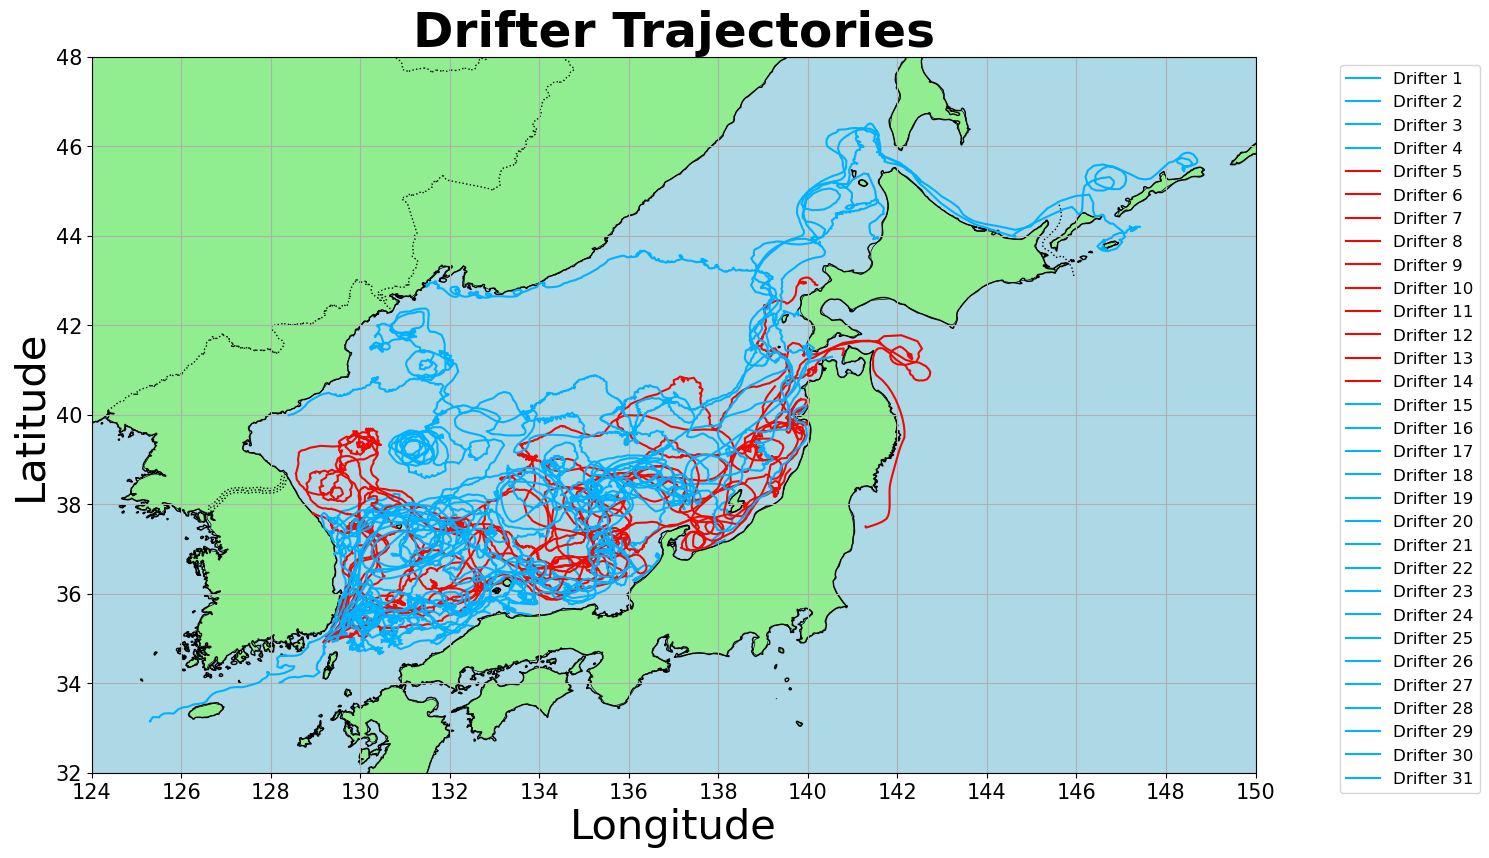

In [47]:
unique_drifters = final_drifter['drifter'].unique()

# Set up a colormap for rainbow representation
cmap = plt.cm.jet

# Define a function to return colors based on the time
def get_color_by_season(time):
    # Write logic to return colors based on time intervals
    if '2005-03-01 00:00:00' <= time <= '2005-09-01 00:00:00':
        return cmap(0.9)  # Red
    elif '2006-03-01 00:00:00' <= time <= '2006-09-01 00:00:00':
        return cmap(0.9)  # Red
    else:
        return cmap(0.3)  # Blue

plt.figure(figsize=(15, 10))

# Plot settings
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add land, coastline, and borders to the map
land = cfeature.LAND.with_scale('50m')
ax.add_feature(land, edgecolor='black', facecolor='lightgreen')

ocean = cfeature.OCEAN.with_scale('50m')
ax.add_feature(ocean, facecolor='lightblue')

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot individual drifter trajectories on the map
for unique_drifter in unique_drifters:
    subset = final_drifter[final_drifter["drifter"] == unique_drifter]
    color = get_color_by_season(subset["time"].iloc[0])  # Set color based on the time of the first data point
    ax.plot(subset["lons"], subset["lats"], label=f"Drifter {int(unique_drifter)}", color=color, transform=ccrs.Geodetic())

plt.title("Drifter Trajectories", fontsize=35, weight='bold')
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1), fontsize=12)

plt.xlabel('Longitude', fontsize=30)
plt.ylabel('Latitude', fontsize=30)

min_lat, max_lat = final_drifter['lats'].min()-1, final_drifter['lats'].max()+1
min_lon, max_lon = final_drifter['lons'].min()-1, final_drifter['lons'].max()+1

ax.set_xticks(np.arange(round(min_lon), round(max_lon) + 1, 2)) 
ax.set_yticks(np.arange(round(min_lat), round(max_lat) + 1, 2))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.grid(True)
plt.tight_layout()

plt.grid(True)
plt.tight_layout()

plt.show()


In [48]:
# Convert the 'time' column to datetime
final_drifter['time'] = pd.to_datetime(final_drifter['time'])

# Check the data types to confirm the conversion
final_drifter.dtypes


drifter                            float64
lons                               float64
lats                               float64
time                        datetime64[ns]
current_u0_interpolated            float64
current_v0_interpolated            float64
current_u15_interpolated           float64
current_v15_interpolated           float64
wind_u_interpolated                float64
wind_v_interpolated                float64
dtype: object

C:\Users\ckgks\AppData\Local\Temp\ipykernel_15972\3202064049.py:56: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


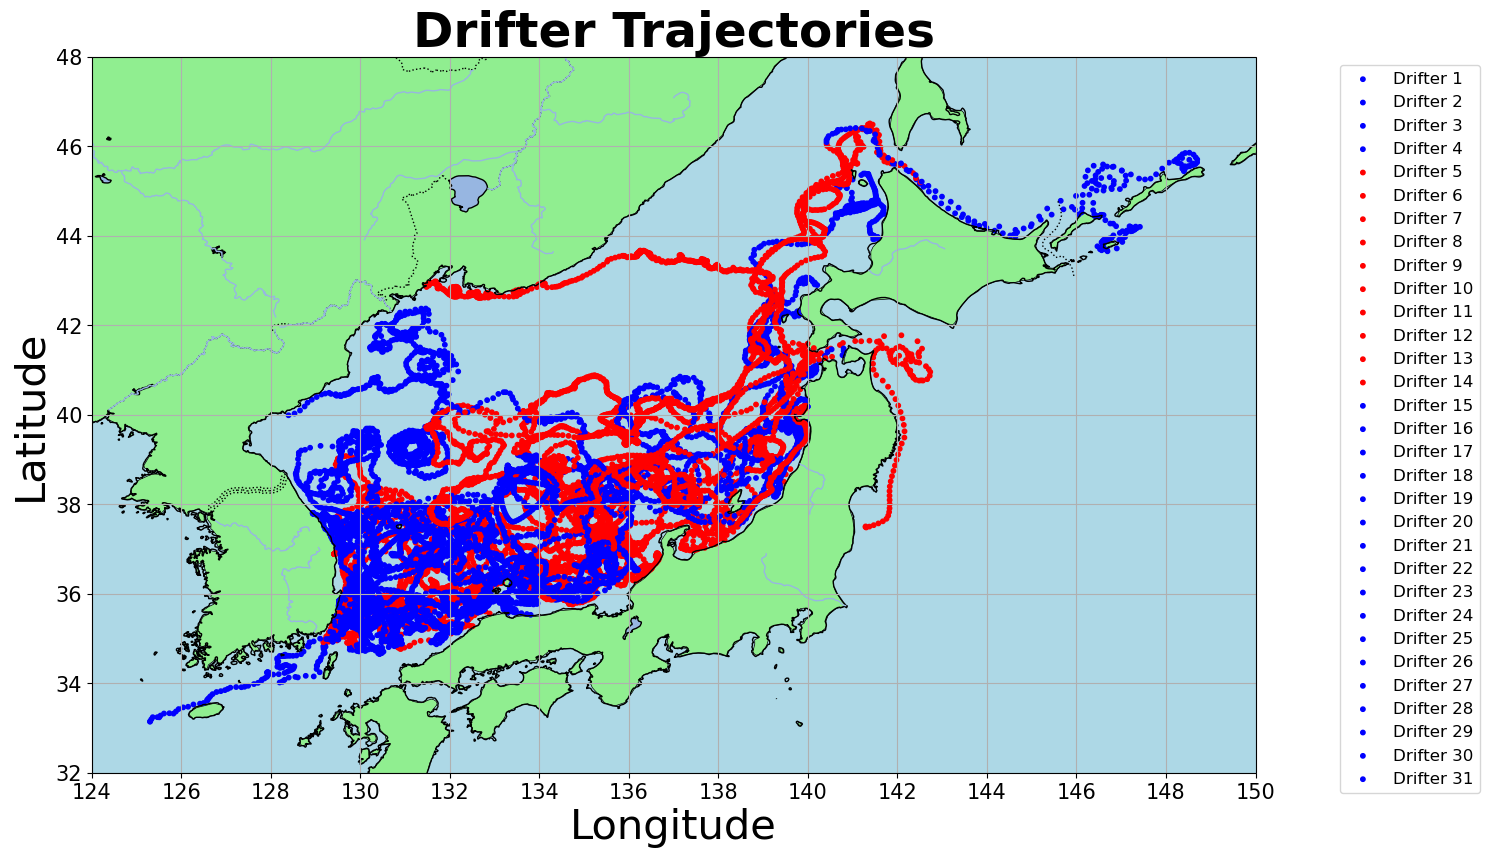

In [49]:
# Set the time range for red color
time_ranges = [(datetime(2005, 3, 1), datetime(2005, 9, 1)), 
               (datetime(2006, 3, 1), datetime(2006, 9, 1))]

# Define a function to determine the color of each point based on the time
def get_color(time):
    for start, end in time_ranges:
        if start <= time <= end:
            return 'red'
    return 'blue'

# Create a new column for colors
final_drifter['color'] = final_drifter['time'].apply(get_color)


# Function to add map features
def add_map_features(ax):
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, edgecolor='black')
    ax.add_feature(cfeature.RIVERS)
    land = cfeature.LAND.with_scale('50m')
    ax.add_feature(land, edgecolor='black', facecolor='lightgreen')
    ocean = cfeature.OCEAN.with_scale('50m')
    ax.add_feature(ocean, facecolor='lightblue')

# Plotting all drifter trajectories on a map
plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
add_map_features(ax)

for drifter_id in final_drifter['drifter'].unique():
    drifter_data = final_drifter[final_drifter['drifter'] == drifter_id]
    plt.scatter(drifter_data['lons'], drifter_data['lats'], c=drifter_data['color'], s=10, marker='o', label=f'Drifter {int(drifter_id)}', transform=ccrs.Geodetic())

plt.title("Drifter Trajectories", fontsize=35, weight='bold')
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1), fontsize=12)

plt.xlabel('Longitude', fontsize=30)
plt.ylabel('Latitude', fontsize=30)

min_lat, max_lat = final_drifter['lats'].min()-1, final_drifter['lats'].max()+1
min_lon, max_lon = final_drifter['lons'].min()-1, final_drifter['lons'].max()+1

ax.set_xticks(np.arange(round(min_lon), round(max_lon) + 1, 2))
ax.set_yticks(np.arange(round(min_lat), round(max_lat) + 1, 2))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


plt.grid(True)
plt.tight_layout()

plt.grid(True)
plt.tight_layout()

plt.show()


C:\Users\ckgks\AppData\Local\Temp\ipykernel_15972\171239035.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


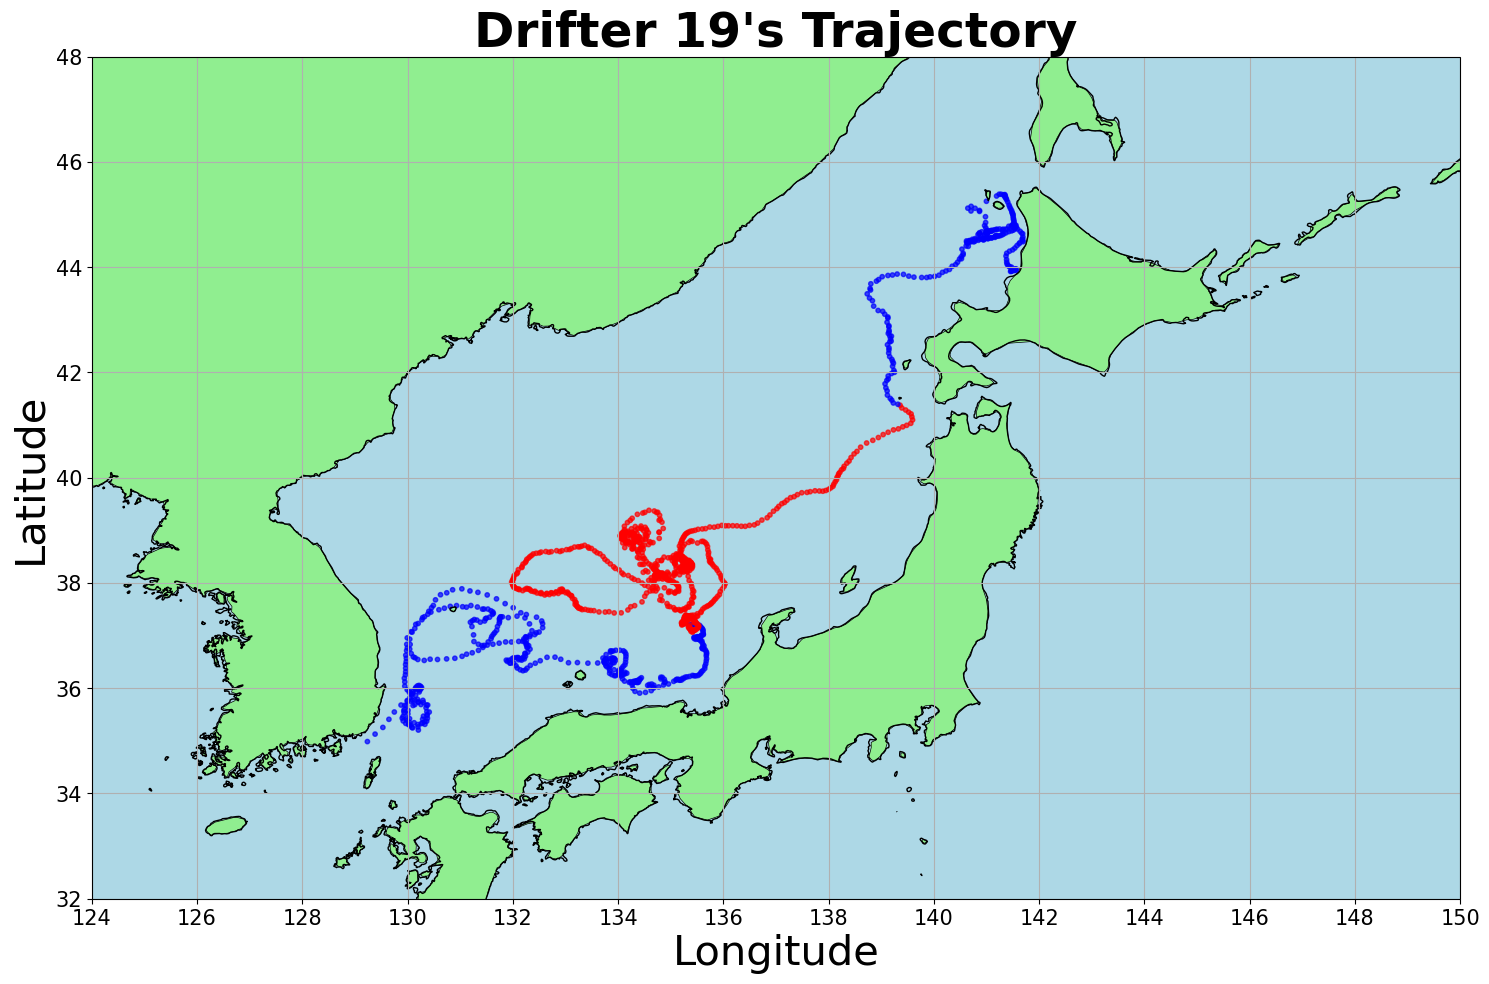

C:\Users\ckgks\AppData\Local\Temp\ipykernel_15972\171239035.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


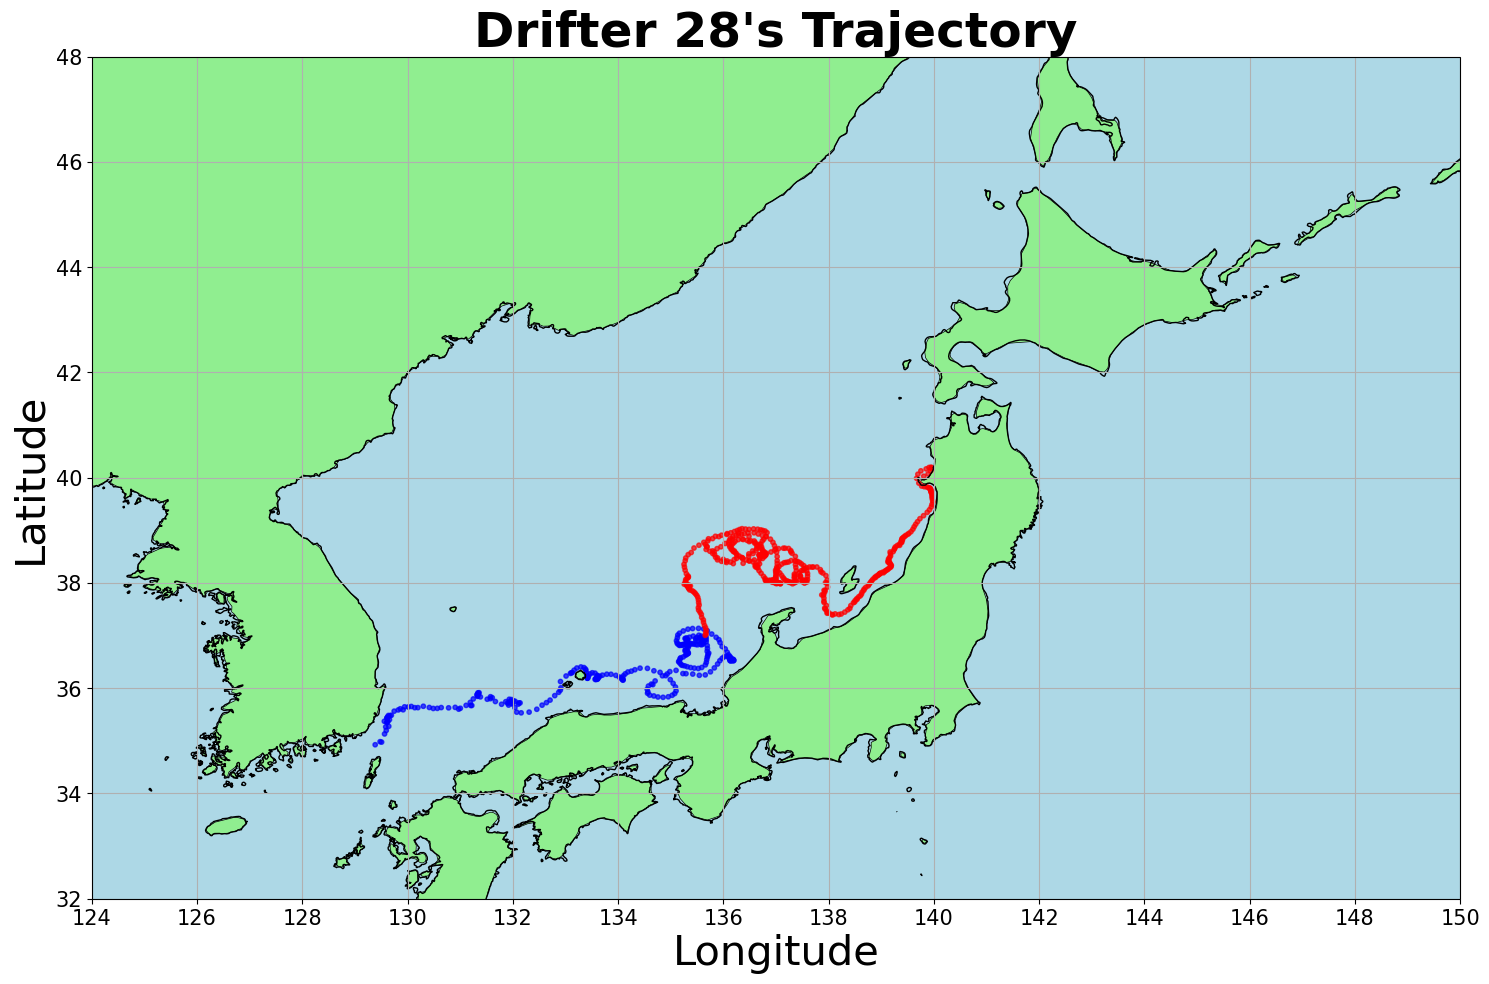

C:\Users\ckgks\AppData\Local\Temp\ipykernel_15972\171239035.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


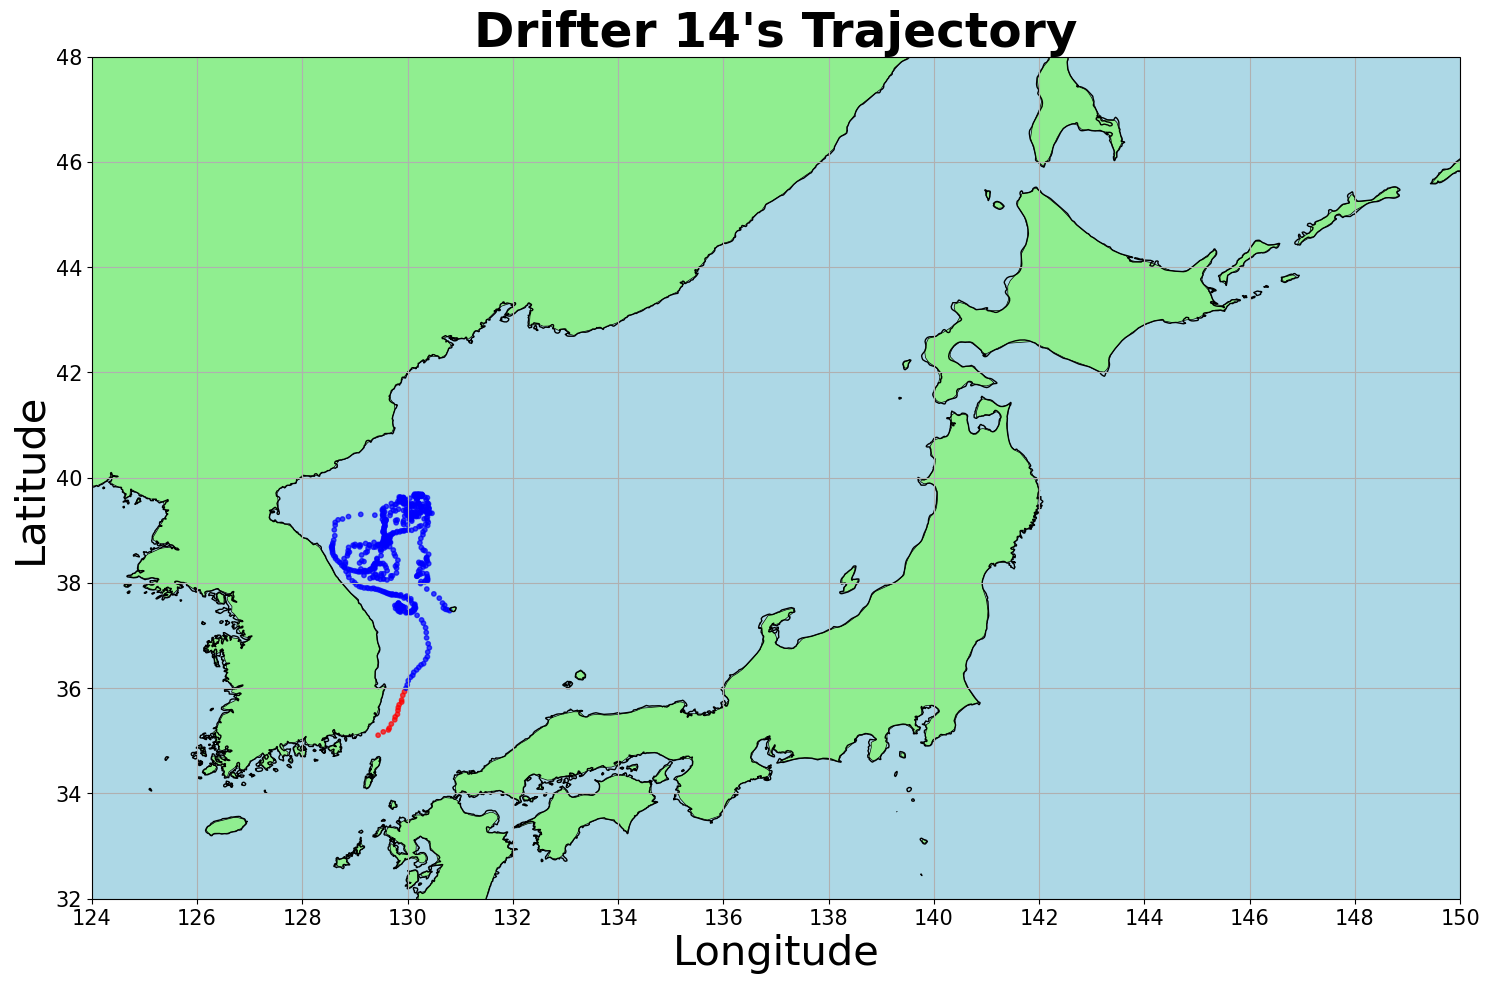

In [50]:
# Function to plot drifter trajectories on a map using cartopy with adjusted map extent
def plot_drifter_trajectories_cartopy_adjusted_extent(final_drifter, drifter_id):
    # Get data for the selected drifter
    drifter_data = final_drifter[final_drifter['drifter'] == drifter_id]
    
    # Calculate the map extent (with some padding)
    padding = 2  # degrees
    lon_min, lon_max = drifter_data['lons'].min() - padding, drifter_data['lons'].max() + padding
    lat_min, lat_max = drifter_data['lats'].min() - padding, drifter_data['lats'].max() + padding
    
    # Create a cartopy map
    plt.figure(figsize=(15, 10))
    
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    land = cfeature.LAND.with_scale('50m')
    ax.add_feature(land, edgecolor='black', facecolor='lightgreen')
    ocean = cfeature.OCEAN.with_scale('50m')
    ax.add_feature(ocean, facecolor='lightblue')
    
    # Add the drifter trajectory to the map
    sc = plt.scatter(drifter_data['lons'], drifter_data['lats'], c=drifter_data['color'], s=10, marker='o', alpha=0.7, transform=ccrs.Geodetic())
    

    plt.title(f"Drifter {drifter_id}'s Trajectory", fontsize=35, weight='bold')

    plt.xlabel('Longitude', fontsize=30)
    plt.ylabel('Latitude', fontsize=30)

    min_lat, max_lat = final_drifter['lats'].min()-1, final_drifter['lats'].max()+1
    min_lon, max_lon = final_drifter['lons'].min()-1, final_drifter['lons'].max()+1

    ax.set_xticks(np.arange(round(min_lon), round(max_lon) + 1, 2))
    ax.set_yticks(np.arange(round(min_lat), round(max_lat) + 1, 2))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)


    plt.grid(True)
    plt.tight_layout()

    plt.grid(True)
    plt.tight_layout()

    plt.show()


# Plotting the trajectories of the selected drifters on a map using cartopy with adjusted map extent
for drifter_id in cluster_representatives:
    plot_drifter_trajectories_cartopy_adjusted_extent(final_drifter, round(drifter_id))


# Model_selection_optimization

In [51]:
data = pd.read_csv('./data/final_drifter.csv')

In [52]:
# Calculating the difference in lons and lats for each drifter group using the shift operation
data['delta_lons'] = data.groupby('drifter')['lons'].shift(-1) - data['lons']
data['delta_lats'] = data.groupby('drifter')['lats'].shift(-1) - data['lats']

# Finding and deleting the last row's index of each drifter group
last_idx = data.groupby('drifter').tail(1).index
data = data.drop(last_idx)

# Resetting the DataFrame index
data.reset_index(drop=True, inplace=True)

data


drifter        lons       lats                 time  \
0          1.0  129.311005  34.950001  2005-02-21 06:00:00   
1          1.0  129.401993  35.020000  2005-02-21 12:00:00   
2          1.0  129.514008  35.061001  2005-02-21 18:00:00   
3          1.0  129.524002  35.032001  2005-02-22 00:00:00   
4          1.0  129.626007  35.083000  2005-02-22 06:00:00   
...        ...         ...        ...                  ...   
15809     31.0  147.319000  44.168999  2006-09-30 18:00:00   
15810     31.0  147.348999  44.167999  2006-10-01 00:00:00   
15811     31.0  147.307007  44.138000  2006-10-01 06:00:00   
15812     31.0  147.250000  44.146999  2006-10-01 12:00:00   
15813     31.0  147.322998  44.201000  2006-10-01 18:00:00   

       current_u0_interpolated  current_v0_interpolated  \
0                     0.145958                 0.086236   
1                     0.133808                 0.110518   
2                     0.108248                 0.074440   
3                     0.113265                 0.134209   
4                     0.260204                 0.179209   
...                        ...                      ...   
15809                 0.060938                -0.069109   
15810                 0.076689                -0.076521   
15811                 0.085218                -0.078659   
15812                 0.084132                -0.061532   
15813                 0.067537                -0.049813   

       current_u15_interpolated  current_v15_interpolated  \
0                      0.096571                  0.135889   
1                      0.106014                  0.160538   
2                      0.081384                  0.123742   
3                      0.080813                  0.131827   
4                      0.137799                  0.108007   
...                         ...                       ...   
15809                  0.041596                 -0.078894   
15810                  0.055621                 -0.080749   
15811                  0.061210                 -0.081402   
15812                  0.065086                 -0.069302   
15813                  0.056426                 -0.066027   

       wind_u_interpolated  wind_v_interpolated  delta_lons  delta_lats  
0                 6.490678            -0.313593    0.090988    0.070000  
1                 4.163806            -1.399033    0.112015    0.041000  
2                 4.106759            -1.669003    0.009995   -0.028999  
3                 1.312693             0.401304    0.102005    0.050999  
4                 5.700327             8.951523    0.086990   -0.024002  
...                    ...                  ...         ...         ...  
15809             2.998513             2.850541    0.029999   -0.000999  
15810             3.390951             1.204701   -0.041992   -0.029999  
15811             2.472012             1.755346   -0.057007    0.008999  
15812             1.961223             3.142489    0.072998    0.054001  
15813             0.383844             3.807814    0.094009   -0.005001  

[15814 rows x 12 columns]

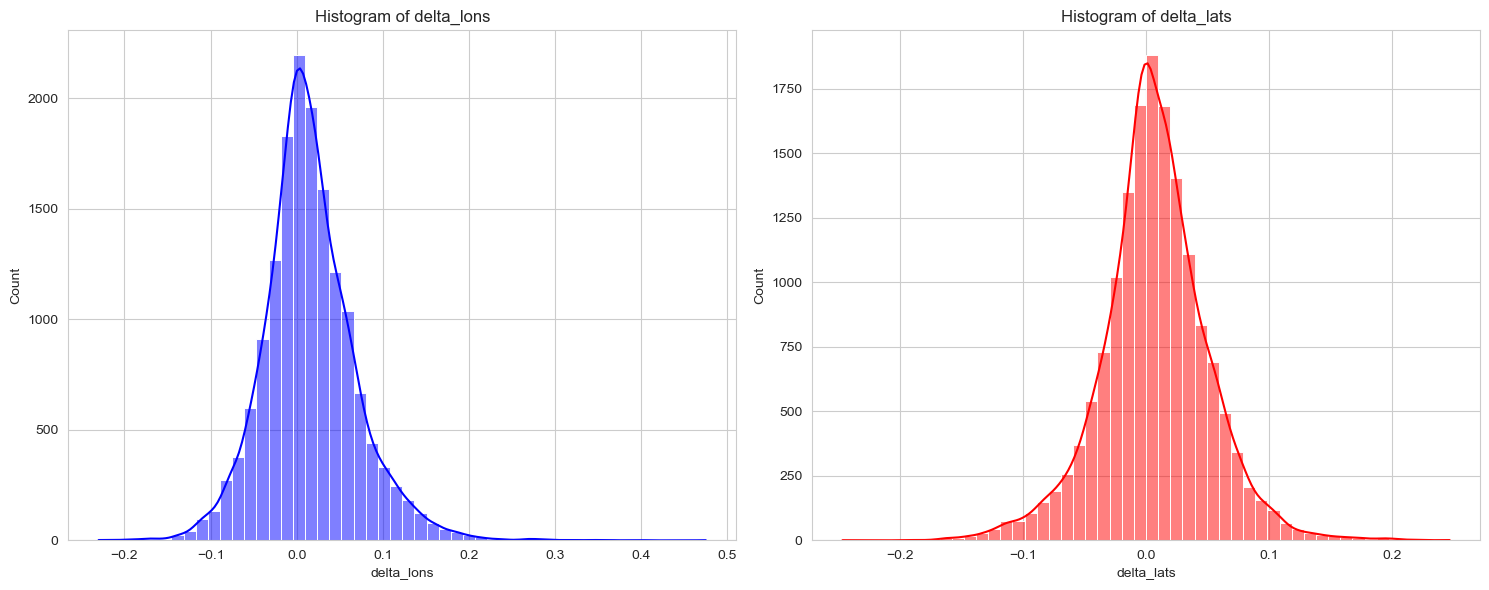

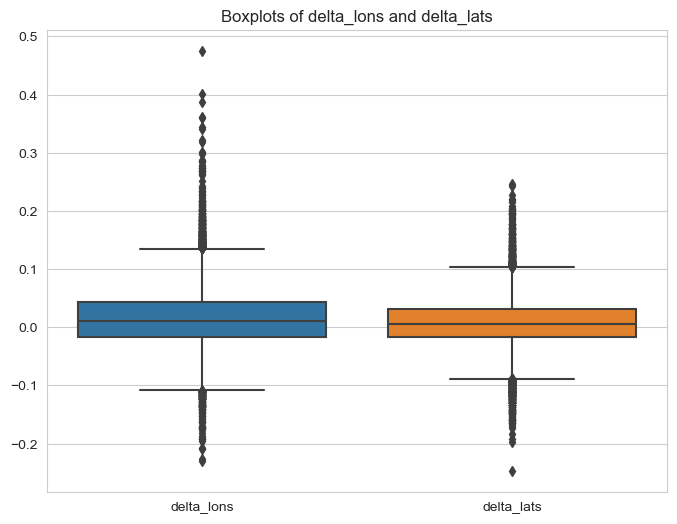

delta_lons    delta_lats
count  15814.000000  15814.000000
mean       0.014679      0.006684
std        0.053495      0.043642
min       -0.230011     -0.247002
25%       -0.016998     -0.016998
50%        0.010010      0.006001
75%        0.043991      0.031002
max        0.475006      0.247002

In [53]:

# Setting style for the plots
sns.set_style('whitegrid')

# Initializing the figure
plt.figure(figsize=(15, 6))

# Plotting histograms for delta_lons and delta_lats
plt.subplot(1, 2, 1)
sns.histplot(data['delta_lons'], bins=50, kde=True, color='blue')
plt.title('Histogram of delta_lons')

plt.subplot(1, 2, 2)
sns.histplot(data['delta_lats'], bins=50, kde=True, color='red')
plt.title('Histogram of delta_lats')

plt.tight_layout()
plt.show()

# Displaying the boxplots for delta_lons and delta_lats
plt.figure(figsize=(8, 6))
sns.boxplot(data=data[['delta_lons', 'delta_lats']])
plt.title('Boxplots of delta_lons and delta_lats')
plt.show()

# Displaying the descriptive statistics
descriptive_stats = data[['delta_lons', 'delta_lats']].describe()

descriptive_stats

In [54]:
# Parsing the 'time' column to datetime format
data['time'] = pd.to_datetime(data['time'])

# Extracting year, month, and day from the 'time' column
data['year'] = data['time'].dt.year
data['month'] = data['time'].dt.month
data['day'] = data['time'].dt.day
data['hour'] = data['time'].dt.hour

In [55]:
data

drifter        lons       lats                time  \
0          1.0  129.311005  34.950001 2005-02-21 06:00:00   
1          1.0  129.401993  35.020000 2005-02-21 12:00:00   
2          1.0  129.514008  35.061001 2005-02-21 18:00:00   
3          1.0  129.524002  35.032001 2005-02-22 00:00:00   
4          1.0  129.626007  35.083000 2005-02-22 06:00:00   
...        ...         ...        ...                 ...   
15809     31.0  147.319000  44.168999 2006-09-30 18:00:00   
15810     31.0  147.348999  44.167999 2006-10-01 00:00:00   
15811     31.0  147.307007  44.138000 2006-10-01 06:00:00   
15812     31.0  147.250000  44.146999 2006-10-01 12:00:00   
15813     31.0  147.322998  44.201000 2006-10-01 18:00:00   

       current_u0_interpolated  current_v0_interpolated  \
0                     0.145958                 0.086236   
1                     0.133808                 0.110518   
2                     0.108248                 0.074440   
3                     0.113265                 0.134209   
4                     0.260204                 0.179209   
...                        ...                      ...   
15809                 0.060938                -0.069109   
15810                 0.076689                -0.076521   
15811                 0.085218                -0.078659   
15812                 0.084132                -0.061532   
15813                 0.067537                -0.049813   

       current_u15_interpolated  current_v15_interpolated  \
0                      0.096571                  0.135889   
1                      0.106014                  0.160538   
2                      0.081384                  0.123742   
3                      0.080813                  0.131827   
4                      0.137799                  0.108007   
...                         ...                       ...   
15809                  0.041596                 -0.078894   
15810                  0.055621                 -0.080749   
15811                  0.061210                 -0.081402   
15812                  0.065086                 -0.069302   
15813                  0.056426                 -0.066027   

       wind_u_interpolated  wind_v_interpolated  delta_lons  delta_lats  year  \
0                 6.490678            -0.313593    0.090988    0.070000  2005   
1                 4.163806            -1.399033    0.112015    0.041000  2005   
2                 4.106759            -1.669003    0.009995   -0.028999  2005   
3                 1.312693             0.401304    0.102005    0.050999  2005   
4                 5.700327             8.951523    0.086990   -0.024002  2005   
...                    ...                  ...         ...         ...   ...   
15809             2.998513             2.850541    0.029999   -0.000999  2006   
15810             3.390951             1.204701   -0.041992   -0.029999  2006   
15811             2.472012             1.755346   -0.057007    0.008999  2006   
15812             1.961223             3.142489    0.072998    0.054001  2006   
15813             0.383844             3.807814    0.094009   -0.005001  2006   

       month  day  hour  
0          2   21     6  
1          2   21    12  
2          2   21    18  
3          2   22     0  
4          2   22     6  
...      ...  ...   ...  
15809      9   30    18  
15810     10    1     0  
15811     10    1     6  
15812     10    1    12  
15813     10    1    18  

[15814 rows x 16 columns]

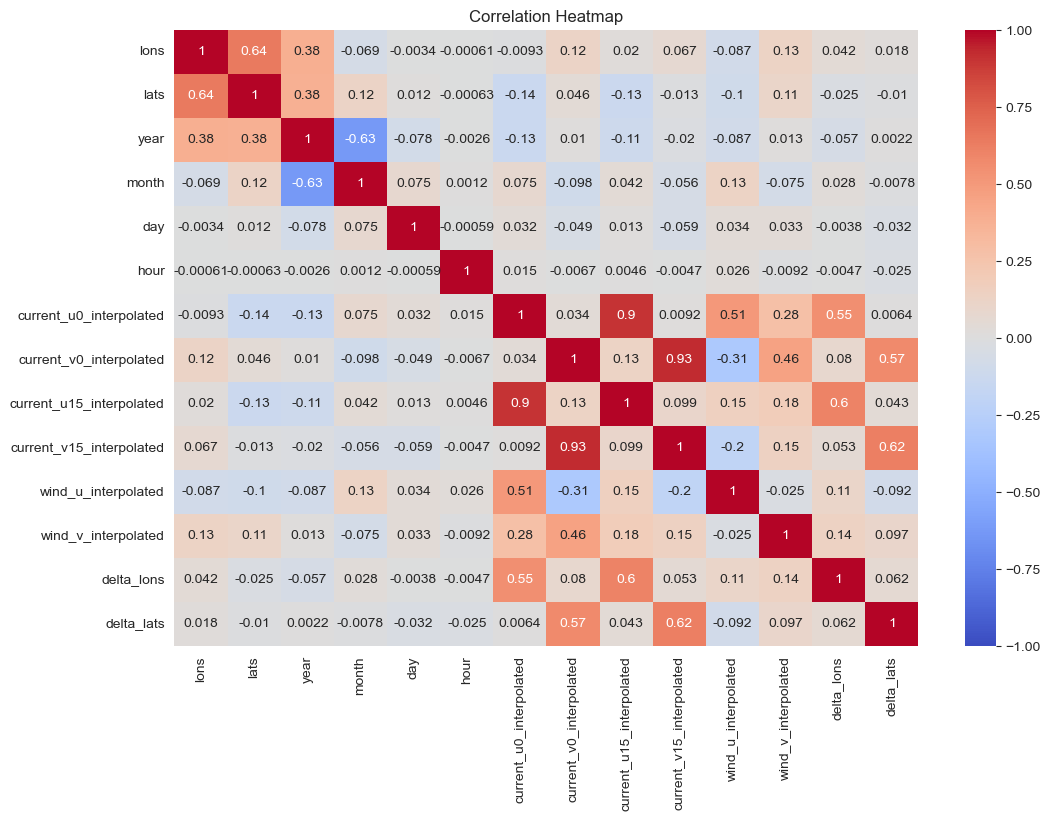

In [56]:
# Calculating the correlation coefficients between the variables of interest
correlation_matrix = data[['lons', 'lats', 'year', 'month', 'day', 'hour', 'current_u0_interpolated', 'current_v0_interpolated', 'current_u15_interpolated', 'current_v15_interpolated', 'wind_u_interpolated', 'wind_v_interpolated', 'delta_lons', 'delta_lats']].corr()

# Representing the correlation coefficients with a Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


In [57]:
# Extracting rows corresponding to drifter ids 5, 14, and 20 as TEST set
test_set = data[data['drifter'].isin([5, 14, 20])]

# Removing these rows from the original data to get the rest of the dataset
train_set = data[~data['drifter'].isin([5, 14, 20])]

test_set.shape, train_set.shape

((1941, 16), (13873, 16))

In [58]:
train_set, val_set = train_test_split(train_set, test_size=0.2, random_state=42)

test_set.shape, train_set.shape, val_set.shape

((1941, 16), (11098, 16), (2775, 16))

In [59]:
# Defining the predictor variables and target variables
predictor_vars = ['lons', 'lats', 'year', 'month', 'day', 'hour', 'current_u0_interpolated', 'current_v0_interpolated', 'wind_u_interpolated', 'wind_v_interpolated']
target_vars = ['delta_lons', 'delta_lats']


# Separating predictors and targets for train set
X_train = train_set[predictor_vars]
y_train = train_set[target_vars]

# Separating predictors and targets for validation set
X_val = val_set[predictor_vars]
y_val = val_set[target_vars]

# Separating predictors and targets for test set
X_test = test_set[predictor_vars]
y_test = test_set[target_vars]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((11098, 10), (11098, 2), (2775, 10), (2775, 2), (1941, 10), (1941, 2))

In [60]:
# Scaling the data
scaler_X = StandardScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)


# Linear Regression

In [61]:


# For delta_lons
linear_lons = LinearRegression().fit(X_train_scaled, y_train['delta_lons'])
predictions_lons_linear = linear_lons.predict(X_val_scaled)

# For delta_lats
linear_lats = LinearRegression().fit(X_train_scaled, y_train['delta_lats'])
predictions_lats_linear = linear_lats.predict(X_val_scaled)


# Linear Regression Performance Metrics
performance_metrics_linear = {
    "Metrics": ["RMSE", "MAE"],
    "delta_lons_Linear": [
        mean_squared_error(y_val['delta_lons'], predictions_lons_linear, squared=False),
        mean_absolute_error(y_val['delta_lons'], predictions_lons_linear)
    ],
    "delta_lats_Linear": [
        mean_squared_error(y_val['delta_lats'], predictions_lats_linear, squared=False),
        mean_absolute_error(y_val['delta_lats'], predictions_lats_linear)
    ]
}
performance_df_linear = pd.DataFrame(performance_metrics_linear)
performance_df_linear

Metrics  delta_lons_Linear  delta_lats_Linear
0    RMSE           0.043200           0.034997
1     MAE           0.032089           0.026042

# RandomForest Regression

In [62]:

# For delta_lons
rf_lons = RandomForestRegressor(random_state=42).fit(X_train_scaled, y_train['delta_lons'])
predictions_lons_rf = rf_lons.predict(X_val_scaled)

# For delta_lats
rf_lats = RandomForestRegressor(random_state=42).fit(X_train_scaled, y_train['delta_lats'])
predictions_lats_rf = rf_lats.predict(X_val_scaled)

# Random Forest Regressor Performance Metrics
performance_metrics_rf = {
    "Metrics": ["RMSE", "MAE"],
    "delta_lons_RF": [
        mean_squared_error(y_val['delta_lons'], predictions_lons_rf, squared=False),
        mean_absolute_error(y_val['delta_lons'], predictions_lons_rf)
    ],
    "delta_lats_RF": [
        mean_squared_error(y_val['delta_lats'], predictions_lats_rf, squared=False),
        mean_absolute_error(y_val['delta_lats'], predictions_lats_rf)
    ]
}
performance_df_rf = pd.DataFrame(performance_metrics_rf)
performance_df_rf



Metrics  delta_lons_RF  delta_lats_RF
0    RMSE       0.038553       0.031767
1     MAE       0.028067       0.022977

# XGBoost Regression

In [63]:

# For delta_lons
xgb_lons = xgb.XGBRegressor(random_state=42).fit(X_train_scaled, y_train['delta_lons'])
predictions_lons_xgb = xgb_lons.predict(X_val_scaled)

# For delta_lats
xgb_lats = xgb.XGBRegressor(random_state=42).fit(X_train_scaled, y_train['delta_lats'])
predictions_lats_xgb = xgb_lats.predict(X_val_scaled)

# XGBoost Regressor Performance Metrics (Using Placeholder values for now)
performance_metrics_xgb = {
    "Metrics": ["RMSE", "MAE"],
    "delta_lons_XGB": [
        mean_squared_error(y_val['delta_lons'], predictions_lons_xgb, squared=False),
        mean_absolute_error(y_val['delta_lons'], predictions_lons_xgb)
    ],  # Placeholder values
    "delta_lats_XGB": [
        mean_squared_error(y_val['delta_lats'], predictions_lats_xgb, squared=False),
        mean_absolute_error(y_val['delta_lats'], predictions_lats_xgb)
    ]   # Placeholder values
}
performance_df_xgb = pd.DataFrame(performance_metrics_xgb)

performance_df_xgb

Metrics  delta_lons_XGB  delta_lats_XGB
0    RMSE        0.037699        0.030417
1     MAE        0.027864        0.022104

# Support Vector Regressor

In [64]:
# Training the SVR model for delta_lons
svr_lons = SVR().fit(X_train_scaled, y_train['delta_lons'])
predictions_lons_svr = svr_lons.predict(X_val_scaled)
rmse_lons_svr = mean_squared_error(y_val['delta_lons'], predictions_lons_svr, squared=False)
mae_lons_svr = mean_absolute_error(y_val['delta_lons'], predictions_lons_svr)

# Training the SVR model for delta_lats
svr_lats = SVR().fit(X_train_scaled, y_train['delta_lats'])
predictions_lats_svr = svr_lats.predict(X_val_scaled)
rmse_lats_svr = mean_squared_error(y_val['delta_lats'], predictions_lats_svr, squared=False)
mae_lats_svr = mean_absolute_error(y_val['delta_lats'], predictions_lats_svr)

# Organizing the performance metrics into a DataFrame
performance_metrics_svr = {
    "Metrics": ["RMSE", "MAE"],
    "delta_lons_SVR": [rmse_lons_svr, mae_lons_svr],
    "delta_lats_SVR": [rmse_lats_svr, mae_lats_svr]
}

performance_df_svr = pd.DataFrame(performance_metrics_svr)
performance_df_svr


Metrics  delta_lons_SVR  delta_lats_SVR
0    RMSE        0.047030        0.040492
1     MAE        0.036369        0.031014

# ANN(Artificial Neural Network)

In [65]:

tf.random.set_seed(42)

# Designing an ANN model for delta_lons
model_lons = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # 1 output: delta_lons
])

# Compiling the model
model_lons.compile(optimizer='adam', loss='mse')

# Training the model
history_lons = model_lons.fit(X_train_scaled, y_train['delta_lons'], epochs=50, validation_data=(X_val_scaled, y_val['delta_lons']))

# Designing an ANN model for delta_lats
model_lats = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # 1 output: delta_lats
])

# Compiling the model
model_lats.compile(optimizer='adam', loss='mse')

# Training the model
history_lats = model_lats.fit(X_train_scaled, y_train['delta_lats'], epochs=50, validation_data=(X_val_scaled, y_val['delta_lats']))


Epoch 1/50
347/347 [==============================] - 3s 3ms/step - loss: 0.0042 - val_loss: 0.0023
Epoch 2/50
347/347 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 3/50
347/347 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 4/50
347/347 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 5/50
347/347 [==============================] - 1s 2ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 6/50
347/347 [==============================] - 1s 2ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 7/50
347/347 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 8/50
347/347 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 9/50
347/347 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 10/50
347/347 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0019

In [66]:
# Predictions for delta_lons
predictions_lons = model_lons.predict(X_val_scaled).flatten()  # Using flatten() to convert to 1D array
rmse_lons_ann = mean_squared_error(y_val['delta_lons'], predictions_lons, squared=False)
mae_lons_ann = mean_absolute_error(y_val['delta_lons'], predictions_lons)

# Predictions for delta_lats
predictions_lats = model_lats.predict(X_val_scaled).flatten()
rmse_lats_ann = mean_squared_error(y_val['delta_lats'], predictions_lats, squared=False)
mae_lats_ann = mean_absolute_error(y_val['delta_lats'], predictions_lats)

# Organizing the performance metrics into a DataFrame
performance_metrics_ann = {
    "Metrics": ["RMSE", "MAE"],
    "delta_lons_ANN": [rmse_lons_ann, mae_lons_ann],
    "delta_lats_ANN": [rmse_lats_ann, mae_lats_ann]
}

performance_df_ann = pd.DataFrame(performance_metrics_ann)
performance_df_ann


87/87 [==============================] - 0s 2ms/step


Metrics  delta_lons_ANN  delta_lats_ANN
0    RMSE        0.041633        0.034103
1     MAE        0.030993        0.024939

# K-NN Regression

In [67]:
# Training a KNN regression model for delta_lons
knn_lons = KNeighborsRegressor().fit(X_train_scaled, y_train['delta_lons'])
predictions_lons_knn = knn_lons.predict(X_val_scaled)
rmse_lons_knn = mean_squared_error(y_val['delta_lons'], predictions_lons_knn, squared=False)
mae_lons_knn = mean_absolute_error(y_val['delta_lons'], predictions_lons_knn)

# Training a KNN regression model for delta_lats
knn_lats = KNeighborsRegressor().fit(X_train_scaled, y_train['delta_lats'])
predictions_lats_knn = knn_lats.predict(X_val_scaled)
rmse_lats_knn = mean_squared_error(y_val['delta_lats'], predictions_lats_knn, squared=False)
mae_lats_knn = mean_absolute_error(y_val['delta_lats'], predictions_lats_knn)

performance_metrics_knn = {
    "Metrics": ["RMSE", "MAE"],
    "delta_lons_KNN": [rmse_lons_knn, mae_lons_knn],
    "delta_lats_KNN": [rmse_lats_knn, mae_lats_knn]
}

performance_df_knn = pd.DataFrame(performance_metrics_knn)
performance_df_knn


Metrics  delta_lons_KNN  delta_lats_KNN
0    RMSE        0.042400        0.034440
1     MAE        0.031263        0.024838

# Bayesian Linear Regression

In [68]:
# Training a Bayesian Regression model for delta_lons
bayes_lons = BayesianRidge().fit(X_train_scaled, y_train['delta_lons'])
predictions_lons_bayes = bayes_lons.predict(X_val_scaled)
rmse_lons_bayes = mean_squared_error(y_val['delta_lons'], predictions_lons_bayes, squared=False)
mae_lons_bayes = mean_absolute_error(y_val['delta_lons'], predictions_lons_bayes)

# Training a Bayesian Regression model for delta_lats
bayes_lats = BayesianRidge().fit(X_train_scaled, y_train['delta_lats'])
predictions_lats_bayes = bayes_lats.predict(X_val_scaled)
rmse_lats_bayes = mean_squared_error(y_val['delta_lats'], predictions_lats_bayes, squared=False)
mae_lats_bayes = mean_absolute_error(y_val['delta_lats'], predictions_lats_bayes)

performance_metrics_bayes = {
    "Metrics": ["RMSE", "MAE"],
    "delta_lons_Bayesian": [rmse_lons_bayes, mae_lons_bayes],
    "delta_lats_Bayesian": [rmse_lats_bayes, mae_lats_bayes]
}

performance_df_bayes = pd.DataFrame(performance_metrics_bayes)
performance_df_bayes


Metrics  delta_lons_Bayesian  delta_lats_Bayesian
0    RMSE             0.043201             0.034997
1     MAE             0.032088             0.026040

# Metric comparison

In [69]:

# Consolidating all performance metrics into a single dataframe for comparison
all_performance_metrics = {
    "Metrics": ["RMSE", "MAE"],

    "delta_lons_Linear": performance_df_linear["delta_lons_Linear"].values,
    "delta_lats_Linear": performance_df_linear["delta_lats_Linear"].values,
    
    "delta_lons_RF": performance_df_rf["delta_lons_RF"].values,
    "delta_lats_RF": performance_df_rf["delta_lats_RF"].values,
    
    "delta_lons_XGB": performance_df_xgb["delta_lons_XGB"].values,
    "delta_lats_XGB": performance_df_xgb["delta_lats_XGB"].values,    
    
    
    "delta_lons_ANN": performance_df_ann["delta_lons_ANN"].values, 
    "delta_lats_ANN": performance_df_ann["delta_lats_ANN"].values,
    
    "delta_lons_SVR": performance_df_svr["delta_lons_SVR"].values,
    "delta_lats_SVR": performance_df_svr["delta_lats_SVR"].values,
    
    "delta_lons_KNN": performance_df_knn["delta_lons_KNN"].values,
    "delta_lats_KNN": performance_df_knn["delta_lats_KNN"].values,
    
    "delta_lons_Bayesian": performance_df_bayes["delta_lons_Bayesian"].values,
    "delta_lats_Bayesian": performance_df_bayes["delta_lats_Bayesian"].values
}

performance_comparison_df = pd.DataFrame(all_performance_metrics)
performance_comparison_df

Metrics  delta_lons_Linear  delta_lats_Linear  delta_lons_RF  delta_lats_RF  \
0    RMSE           0.043200           0.034997       0.038553       0.031767   
1     MAE           0.032089           0.026042       0.028067       0.022977   

   delta_lons_XGB  delta_lats_XGB  delta_lons_ANN  delta_lats_ANN  \
0        0.037699        0.030417        0.041633        0.034103   
1        0.027864        0.022104        0.030993        0.024939   

   delta_lons_SVR  delta_lats_SVR  delta_lons_KNN  delta_lats_KNN  \
0        0.047030        0.040492        0.042400        0.034440   
1        0.036369        0.031014        0.031263        0.024838   

   delta_lons_Bayesian  delta_lats_Bayesian  
0             0.043201             0.034997  
1             0.032088             0.026040

C:\Users\ckgks\AppData\Local\Temp\ipykernel_15972\1684562413.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


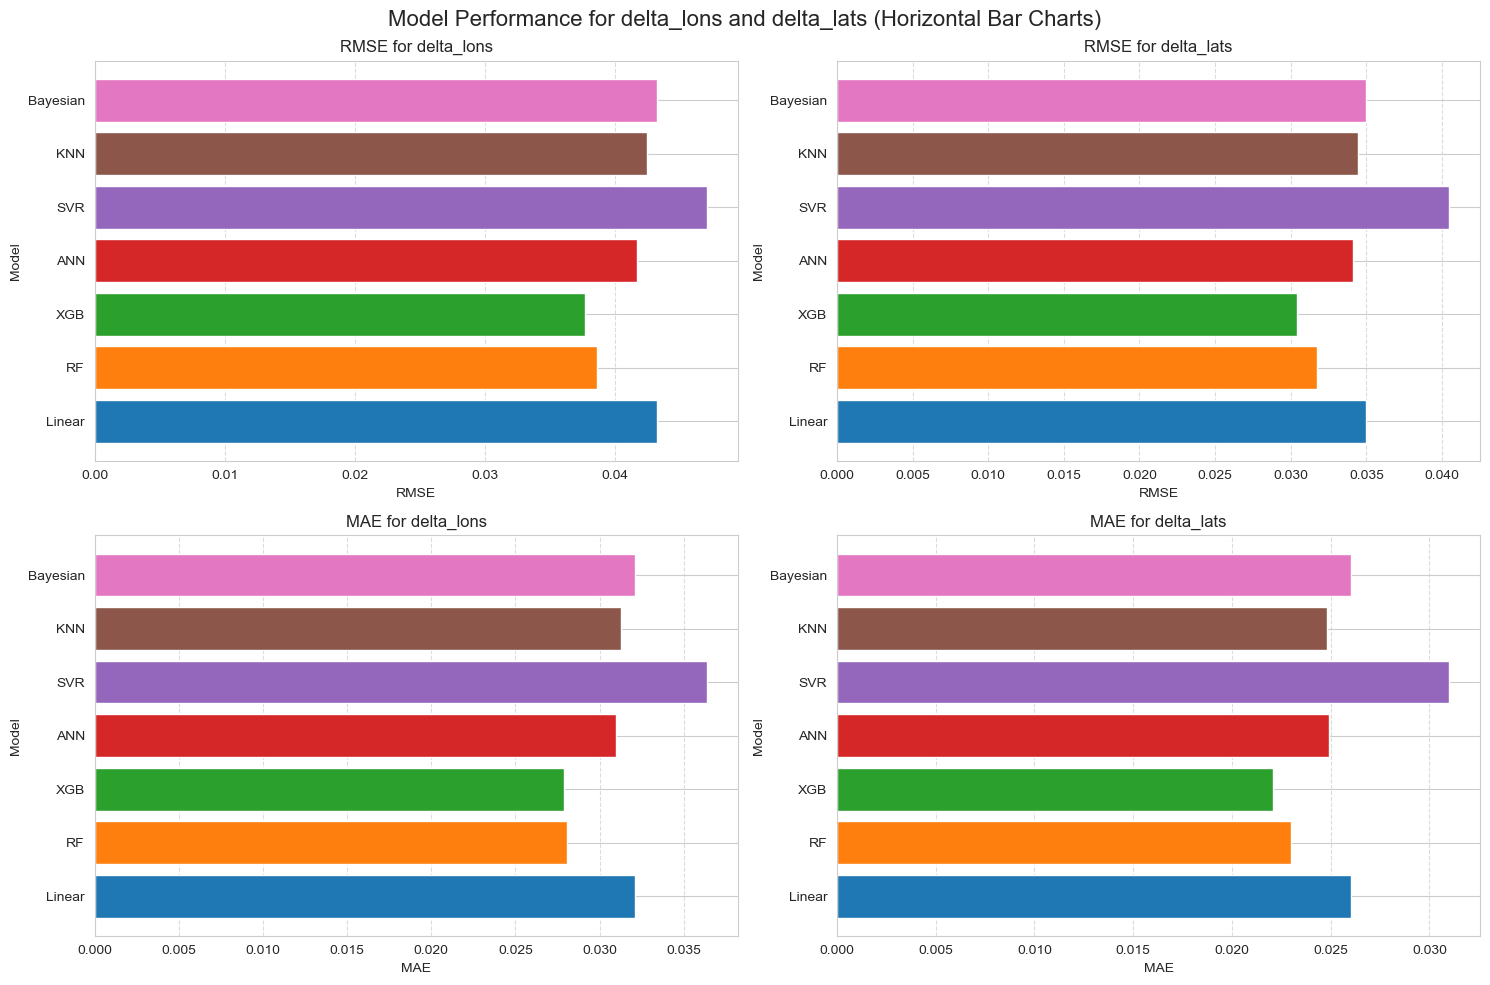

In [70]:
# Prepare data for drawing graphs
models = ["Linear", "RF", "XGB", "ANN", "SVR", "KNN", "Bayesian"]
metrics = ["RMSE", "MAE"]
delta_types = ["delta_lons", "delta_lats"]

# Define colors
colors = {
    "Linear": "#1f77b4",
    "RF": "#ff7f0e",
    "XGB": "#2ca02c",
    "ANN": "#d62728",
    "SVR": "#9467bd",
    "KNN": "#8c564b",
    "Bayesian": "#e377c2"
}

# Create horizontal bar charts
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Model Performance for delta_lons and delta_lats (Horizontal Bar Charts)', fontsize=16)

for i, metric in enumerate(metrics):
    for j, delta_type in enumerate(delta_types):
        ax = axes[i, j]
        values = [performance_comparison_df[f"{delta_type}_{model}"].values[i] for model in models]
        bar_colors = [colors[model] for model in models]
        ax.barh(models, values, color=bar_colors)
        ax.set_title(f'{metric} for {delta_type}')
        ax.set_xlabel(metric)
        ax.set_ylabel('Model')
        ax.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.grid(True)
plt.tight_layout()

# Save the file
save_path = output_dir + "/evaluation_non_op.png"
plt.savefig(save_path, dpi=300)

plt.show()


# RF optimization

In [71]:
# # Defining the hyperparameter distribution
# param_distributions = {
#     'n_estimators': [50, 100, 200, 300],
#     'max_depth': [None, 10, 20, 30, 40],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt']
# }

# # Defining the model
# rf = RandomForestRegressor()

# # Defining scoring using RMSE
# neg_rmse = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

# # Creating a RandomizedSearchCV object
# random_search = RandomizedSearchCV(
#     rf, param_distributions=param_distributions, n_iter=100,
#     scoring=neg_rmse, cv=5, verbose=2, random_state=42, n_jobs=-1
# )

# # Hyperparameter tuning for delta_lons
# random_search.fit(X_train_scaled, y_train['delta_lons'])
# best_rf_lons = random_search.best_estimator_

# # Hyperparameter tuning for delta_lats
# random_search.fit(X_train_scaled, y_train['delta_lats'])
# best_rf_lats = random_search.best_estimator_


In [72]:
# # Printing the optimized hyperparameters for delta_lons
# print("Optimized rf parameters for delta_lons:")
# optimized_rf_params_lons = best_rf_lons.get_params()
# print(optimized_rf_params_lons)

# # Printing the optimized hyperparameters for delta_lats
# print("\nOptimized rf parameters for delta_lats:")
# optimized_rf_params_lats = best_rf_lats.get_params()
# print(optimized_rf_params_lats)


In [73]:
# # Saving the optimized hyperparameters for delta_lons
# with open("./params/optimized_params_lons_rf.pkl", "wb") as f:
#     pickle.dump(optimized_rf_params_lons, f)

# # Saving the optimized hyperparameters for delta_lats
# with open("./params/optimized_params_lats_rf.pkl", "wb") as f:
#     pickle.dump(optimized_rf_params_lats, f)


In [74]:
# Load the best hyperparameters for delta_lons
with open("./params/optimized_params_lons_rf.pkl", "rb") as f:
    loaded_params_lons = pickle.load(f)

# Load the best hyperparameters for delta_lats
with open("./params/optimized_params_lats_rf.pkl", "rb") as f:
    loaded_params_lats = pickle.load(f)
loaded_params_lats

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [75]:
loaded_params_lons = {'bootstrap': True,
                     'ccp_alpha': 0.0,
                     'criterion': 'squared_error',
                     'max_depth': None,
                     'max_features': 'sqrt',
                     'max_leaf_nodes': None,
                     'max_samples': None,
                     'min_impurity_decrease': 0.0,
                     'min_samples_leaf': 1,
                     'min_samples_split': 2,
                     'min_weight_fraction_leaf': 0.0,
                     'n_estimators': 300,
                     'n_jobs': None,
                     'oob_score': False,
                     'random_state': 42, #fix random state
                     'verbose': 0,
                     'warm_start': False}
loaded_params_lats = {'bootstrap': True,
                     'ccp_alpha': 0.0,
                     'criterion': 'squared_error',
                     'max_depth': None,
                     'max_features': 'sqrt',
                     'max_leaf_nodes': None,
                     'max_samples': None,
                     'min_impurity_decrease': 0.0,
                     'min_samples_leaf': 1,
                     'min_samples_split': 2,
                     'min_weight_fraction_leaf': 0.0,
                     'n_estimators': 300,
                     'n_jobs': None,
                     'oob_score': False, 
                     'random_state': 42, #fix ramdeom state
                     'verbose': 0,
                     'warm_start': False}


# Creating a model for delta_lons with optimized hyperparameters
optimized_rf_lons = RandomForestRegressor(**loaded_params_lons)

# Creating a model for delta_lats with optimized hyperparameters
optimized_rf_lats = RandomForestRegressor(**loaded_params_lats)


In [76]:
# Training the model for delta_lons
optimized_rf_lons.fit(X_train_scaled, y_train['delta_lons'])

# Training the model for delta_lats
optimized_rf_lats.fit(X_train_scaled, y_train['delta_lats'])

# Performing predictions on the validation dataset with the optimized model
predictions_lons_rf_optimized = optimized_rf_lons.predict(X_val_scaled)
predictions_lats_rf_optimized = optimized_rf_lats.predict(X_val_scaled)

# Calculating performance metrics
rmse_lons_rf_optimized = mean_squared_error(y_val['delta_lons'], predictions_lons_rf_optimized, squared=False)
mae_lons_rf_optimized = mean_absolute_error(y_val['delta_lons'], predictions_lons_rf_optimized)

rmse_lats_rf_optimized = mean_squared_error(y_val['delta_lats'], predictions_lats_rf_optimized, squared=False)
mae_lats_rf_optimized = mean_absolute_error(y_val['delta_lats'], predictions_lats_rf_optimized)

# Printing performance metrics
performance_metrics_rf_optimized = {
    "Metrics": ["RMSE", "MAE"],
    "delta_lons_RF_optimized": [rmse_lons_rf_optimized, mae_lons_rf_optimized],
    "delta_lats_RF_optimized": [rmse_lats_rf_optimized, mae_lats_rf_optimized]
}
performance_df_rf_optimized = pd.DataFrame(performance_metrics_rf_optimized)
performance_df_rf_optimized


Metrics  delta_lons_RF_optimized  delta_lats_RF_optimized
0    RMSE                 0.037216                 0.030177
1     MAE                 0.027151                 0.021718

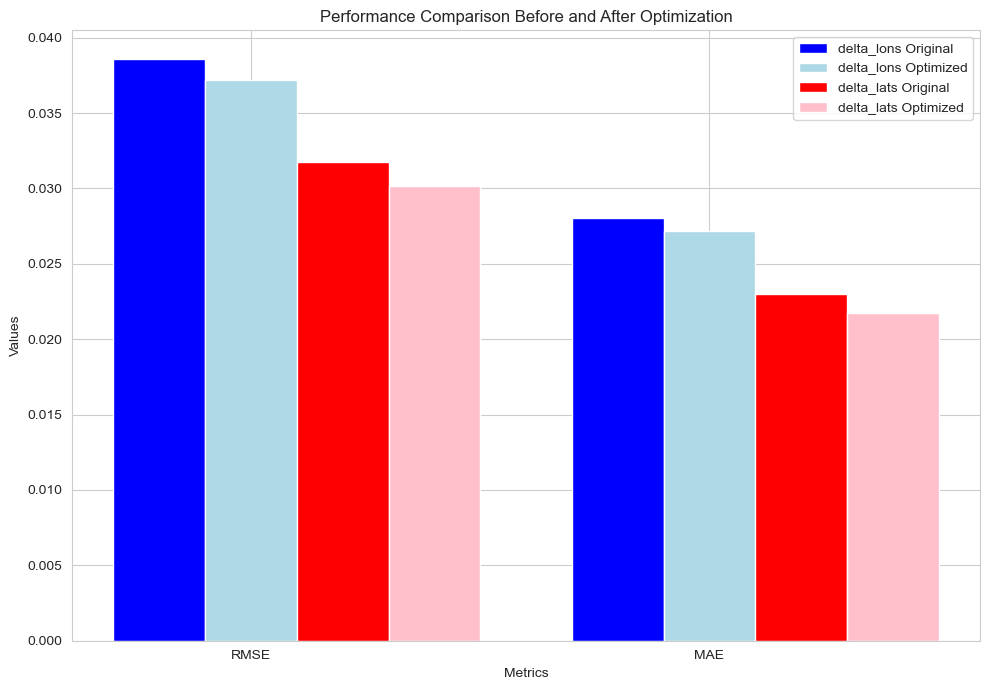

In [77]:
# Organizing data for the plot
labels = ['RMSE', 'MAE']
lons_values_original = performance_df_rf["delta_lons_RF"].values
lats_values_original = performance_df_rf["delta_lats_RF"].values
lons_values_optimized = [rmse_lons_rf_optimized, mae_lons_rf_optimized]
lats_values_optimized = [rmse_lats_rf_optimized, mae_lats_rf_optimized]

x = range(len(labels))

# Plotting the graph
plt.figure(figsize=(10, 7))
plt.bar([i-0.2 for i in x], lons_values_original, width=0.2, color='blue', label='delta_lons Original', align='center')
plt.bar(x, lons_values_optimized, width=0.2, color='lightblue', label='delta_lons Optimized', align='center')
plt.bar([i+0.2 for i in x], lats_values_original, width=0.2, color='red', label='delta_lats Original', align='center')
plt.bar([i+0.4 for i in x], lats_values_optimized, width=0.2, color='pink', label='delta_lats Optimized', align='center')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Performance Comparison Before and After Optimization')
plt.xticks(x, labels)
plt.legend()
plt.tight_layout()
plt.show()


# ANN optimization

In [78]:
# # Defining early stopping callback
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # Designing ANN model for delta_lons
# model_lons = keras.Sequential([
#     keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(64, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(32, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(1)  # Single output: delta_lons
# ])

# model_lons.compile(optimizer='adam', loss='mse')
# history_lons = model_lons.fit(X_train_scaled, y_train['delta_lons'], epochs=50, validation_data=(X_val_scaled, y_val['delta_lons']), callbacks=[early_stop])


# # Designing ANN model for delta_lats
# model_lats = keras.Sequential([
#     keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(64, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(32, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(1)  # Single output: delta_lats
# ])

# model_lats.compile(optimizer='adam', loss='mse')
# history_lats = model_lats.fit(X_train_scaled, y_train['delta_lats'], epochs=50, validation_data=(X_val_scaled, y_val['delta_lats']), callbacks=[early_stop])


# # Saving the weights of lon and lat models
# weights_lons = model_lons.get_weights()
# weights_lats = model_lats.get_weights()

# # Saving the weights to an npz file with object dtype
# np.savez('./params/optimized_ann_weights.npz', weights_lons=np.array(weights_lons, dtype=object), weights_lats=np.array(weights_lats, dtype=object))


In [79]:
# # Loading the weights
# loaded = np.load('./params/optimized_ann_weights.npz', allow_pickle=True)
# loaded_weights_lons = loaded['weights_lons'].tolist()
# loaded_weights_lats = loaded['weights_lats'].tolist()

# # Applying the loaded weights to the models
# model_lons.set_weights(loaded_weights_lons)
# model_lats.set_weights(loaded_weights_lats)

# # Saving the entire models (architecture + weights)
# model_lons.save('./params/optimized_ann_lons_complete.h5')
# model_lats.save('./params/optimized_ann_lats_complete.h5')


In [80]:
tf.random.set_seed(42) #fix ramdeom state

optimized_ann_lons = keras.models.load_model('./params/optimized_ann_lons_complete.h5')
optimized_ann_lats = keras.models.load_model('./params/optimized_ann_lats_complete.h5')


In [81]:
# Perform predictions on the validation dataset using the optimized ANN model
predictions_lons_ann_optimized = optimized_ann_lons.predict(X_val_scaled).flatten()
predictions_lats_ann_optimized = optimized_ann_lats.predict(X_val_scaled).flatten()

# Calculate performance metrics
rmse_lons_ann_optimized = mean_squared_error(y_val['delta_lons'], predictions_lons_ann_optimized, squared=False)
mae_lons_ann_optimized = mean_absolute_error(y_val['delta_lons'], predictions_lons_ann_optimized)

rmse_lats_ann_optimized = mean_squared_error(y_val['delta_lats'], predictions_lats_ann_optimized, squared=False)
mae_lats_ann_optimized = mean_absolute_error(y_val['delta_lats'], predictions_lats_ann_optimized)

# Print performance metrics
performance_metrics_ann_optimized = {
    "Metrics": ["RMSE", "MAE"],
    "delta_lons_ANN_optimized": [rmse_lons_ann_optimized, mae_lons_ann_optimized],
    "delta_lats_ANN_optimized": [rmse_lats_ann_optimized, mae_lats_ann_optimized]
}
performance_df_ann_optimized = pd.DataFrame(performance_metrics_ann_optimized)
performance_df_ann_optimized


87/87 [==============================] - 0s 2ms/step


Metrics  delta_lons_ANN_optimized  delta_lats_ANN_optimized
0    RMSE                  0.042812                  0.036175
1     MAE                  0.031779                  0.026650

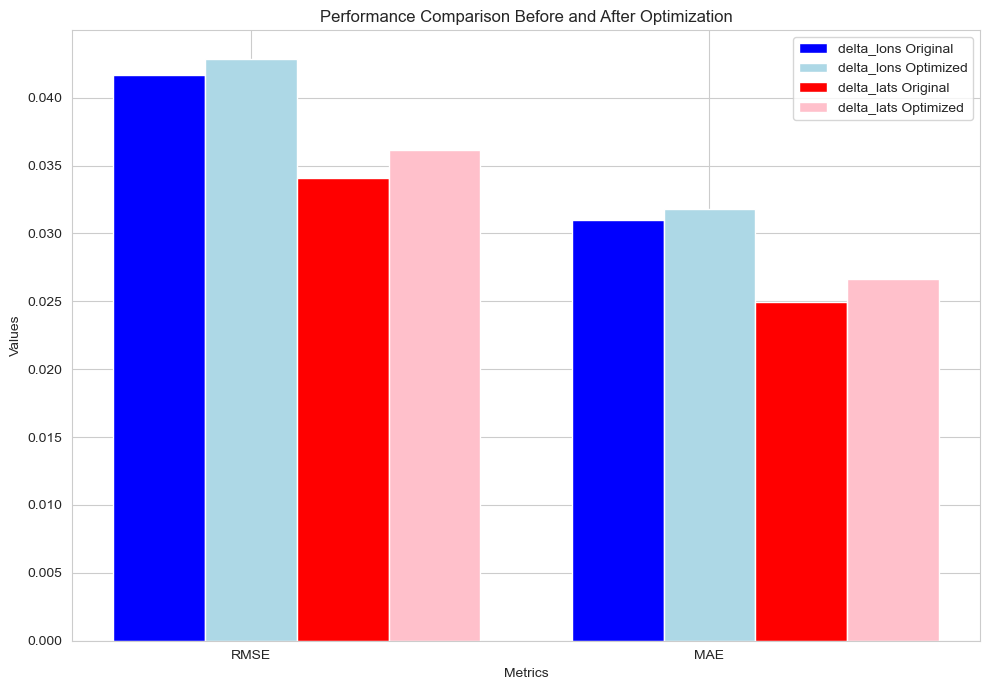

In [82]:
# Organize data for the graph
labels = ['RMSE', 'MAE']
lons_values_original = performance_df_ann["delta_lons_ANN"].values
lats_values_original = performance_df_ann["delta_lats_ANN"].values
lons_values_optimized = [rmse_lons_ann_optimized, mae_lons_ann_optimized]
lats_values_optimized = [rmse_lats_ann_optimized, mae_lats_ann_optimized]

x = range(len(labels))

# Draw the graph
plt.figure(figsize=(10, 7))
plt.bar([i-0.2 for i in x], lons_values_original, width=0.2, color='blue', label='delta_lons Original', align='center')
plt.bar(x, lons_values_optimized, width=0.2, color='lightblue', label='delta_lons Optimized', align='center')
plt.bar([i+0.2 for i in x], lats_values_original, width=0.2, color='red', label='delta_lats Original', align='center')
plt.bar([i+0.4 for i in x], lats_values_optimized, width=0.2, color='pink', label='delta_lats Optimized', align='center')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Performance Comparison Before and After Optimization')
plt.xticks(x, labels)
plt.legend()
plt.tight_layout()
plt.show()


# XGBoost optimization

In [83]:
# # Define the parameter distribution
# param_dist = {
#     'n_estimators': [50, 100, 150, 200, 250],
#     'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
#     'max_depth': [3, 4, 5, 6, 7, 8],
#     'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
#     'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
# }

# # Initialize the XGBoost Regressor model
# xgb_model = xgb.XGBRegressor()

# # Initialize Randomized Search
# rand_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, 
#                                  n_iter=100, cv=3, n_jobs=-1, verbose=2, 
#                                  scoring='neg_mean_squared_error', random_state=42)

# # Search for the best parameters for delta_lons
# rand_search.fit(X_train_scaled, y_train['delta_lons'])
# best_params_lons_rand = rand_search.best_params_

# # Search for the best parameters for delta_lats
# rand_search.fit(X_train_scaled, y_train['delta_lats'])
# best_params_lats_rand = rand_search.best_params_


In [84]:
# # Save the best hyperparameters for delta_lons
# with open("./params/optimized_params_lons_xgb.pkl", "wb") as f:
#     pickle.dump(best_params_lons_rand, f)

# # Save the best hyperparameters for delta_lats
# with open("./params/optimized_params_lats_xgb.pkl", "wb") as f:
#     pickle.dump(best_params_lats_rand, f)


In [85]:
# Load hyperparameters for delta_lons
with open("./params/optimized_params_lons_xgb.pkl", "rb") as f:
    loaded_params_lons = pickle.load(f)

# Load hyperparameters for delta_lats
with open("./params/optimized_params_lats_xgb.pkl", "rb") as f:
    loaded_params_lats = pickle.load(f)
    

loaded_params_lons = {'subsample': 0.7,
                     'n_estimators': 250,
                     'max_depth': 8,
                     'learning_rate': 0.05,
                     'random_state': 42, #fix ramdeom state
                     'colsample_bytree': 0.9}

loaded_params_lats = {'subsample': 0.7,
                     'n_estimators': 250,
                     'max_depth': 8,
                     'random_state': 42, #fix ramdeom state
                     'learning_rate': 0.05,
                     'colsample_bytree': 0.9}

In [86]:
# Train the optimal model for delta_lons
xgb_lons_optimized = xgb.XGBRegressor(**loaded_params_lons)
xgb_lons_optimized.fit(X_train_scaled, y_train['delta_lons'])

# Train the optimal model for delta_lats
xgb_lats_optimized = xgb.XGBRegressor(**loaded_params_lats)
xgb_lats_optimized.fit(X_train_scaled, y_train['delta_lats'])

# Perform predictions on the validation dataset using the optimized models
predictions_lons_xgb_optimized = xgb_lons_optimized.predict(X_val_scaled)
predictions_lats_xgb_optimized = xgb_lats_optimized.predict(X_val_scaled)

# Calculate performance metrics
rmse_lons_xgb_optimized = mean_squared_error(y_val['delta_lons'], predictions_lons_xgb_optimized, squared=False)
mae_lons_xgb_optimized = mean_absolute_error(y_val['delta_lons'], predictions_lons_xgb_optimized)

rmse_lats_xgb_optimized = mean_squared_error(y_val['delta_lats'], predictions_lats_xgb_optimized, squared=False)
mae_lats_xgb_optimized = mean_absolute_error(y_val['delta_lats'], predictions_lats_xgb_optimized)

# Print performance metrics
performance_metrics_xgb_optimized = {
    "Metrics": ["RMSE", "MAE"],
    "delta_lons_XGB_optimized": [rmse_lons_xgb_optimized, mae_lons_xgb_optimized],
    "delta_lats_XGB_optimized": [rmse_lats_xgb_optimized, mae_lats_xgb_optimized]
}
performance_df_xgb_optimized = pd.DataFrame(performance_metrics_xgb_optimized)
performance_df_xgb_optimized


Metrics  delta_lons_XGB_optimized  delta_lats_XGB_optimized
0    RMSE                  0.036691                  0.029881
1     MAE                  0.026830                  0.021562

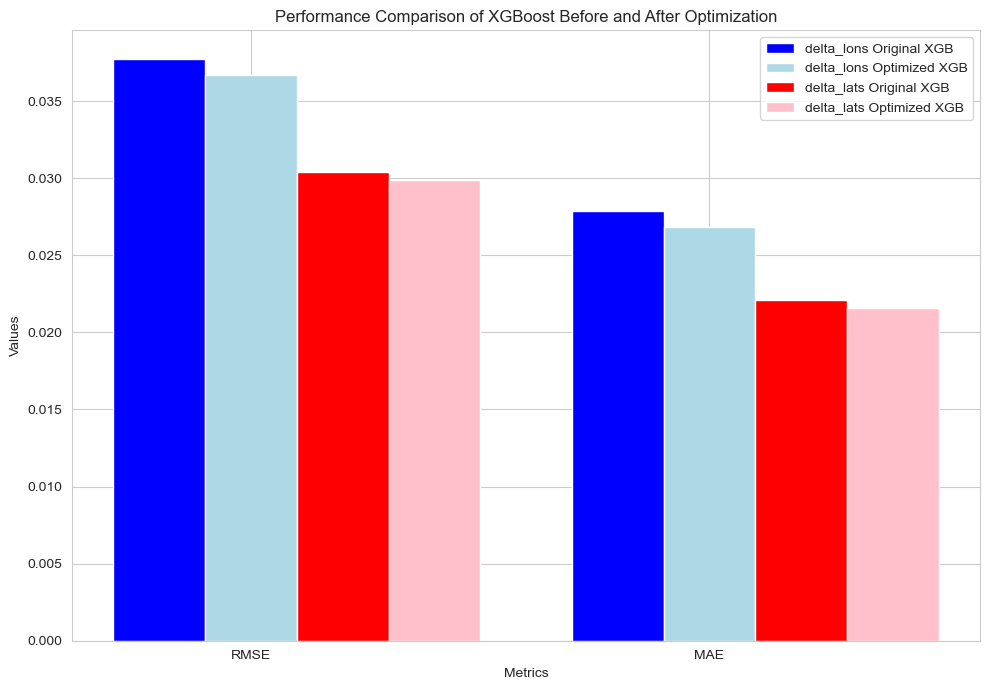

In [87]:
# Organize data for the graph
labels = ['RMSE', 'MAE']
lons_values_original = performance_df_xgb["delta_lons_XGB"].values
lats_values_original = performance_df_xgb["delta_lats_XGB"].values
lons_values_optimized = [rmse_lons_xgb_optimized, mae_lons_xgb_optimized]
lats_values_optimized = [rmse_lats_xgb_optimized, mae_lats_xgb_optimized]

x = range(len(labels))

# Draw the graph
plt.figure(figsize=(10, 7))
plt.bar([i-0.2 for i in x], lons_values_original, width=0.2, color='blue', label='delta_lons Original XGB', align='center')
plt.bar(x, lons_values_optimized, width=0.2, color='lightblue', label='delta_lons Optimized XGB', align='center')
plt.bar([i+0.2 for i in x], lats_values_original, width=0.2, color='red', label='delta_lats Original XGB', align='center')
plt.bar([i+0.4 for i in x], lats_values_optimized, width=0.2, color='pink', label='delta_lats Optimized XGB', align='center')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Performance Comparison of XGBoost Before and After Optimization')
plt.xticks(x, labels)
plt.legend()
plt.tight_layout()
plt.show()


# SVR optimization

In [88]:
# param_dist_svr_reduced_further = {
#     'C': [1, 10, 100],
#     'epsilon': [0.01, 0.1],
#     'kernel': ['rbf'],  # Use only RBF kernel
#     'gamma': ['scale', 'auto']  # Use only scale and auto
# }

# svr_model = SVR()

# # Search for the best parameters for delta_lons (set n_iter to 20)
# rand_search_svr_lons_reduced_further = RandomizedSearchCV(estimator=svr_model, param_distributions=param_dist_svr_reduced_further, 
#                                                           n_iter=20, cv=3, n_jobs=-1, verbose=2, 
#                                                           scoring='neg_mean_squared_error', random_state=42)
# rand_search_svr_lons_reduced_further.fit(X_train_scaled, y_train['delta_lons'])
# best_params_svr_lons_rand_reduced_further = rand_search_svr_lons_reduced_further.best_params_

# # Search for the best parameters for delta_lats (set n_iter to 20)
# rand_search_svr_lats_reduced_further = RandomizedSearchCV(estimator=svr_model, param_distributions=param_dist_svr_reduced_further, 
#                                                           n_iter=20, cv=3, n_jobs=-1, verbose=2, 
#                                                           scoring='neg_mean_squared_error', random_state=42)
# rand_search_svr_lats_reduced_further.fit(X_train_scaled, y_train['delta_lats'])
# best_params_svr_lats_rand_reduced_further = rand_search_svr_lats_reduced_further.best_params_


In [89]:
# # Save the best hyperparameters for delta_lons
# with open("./params/optimized_params_svr_lons_reduced.pkl", "wb") as f:
#     pickle.dump(best_params_svr_lons_rand_reduced_further, f)

# # Save the best hyperparameters for delta_lats
# with open("./params/optimized_params_svr_lats_reduced.pkl", "wb") as f:
#     pickle.dump(best_params_svr_lats_rand_reduced_further, f)


In [90]:
# Load hyperparameters for delta_lons
with open("./params/optimized_params_svr_lons_reduced.pkl", "rb") as f:
    loaded_params_svr_lons = pickle.load(f)

# Load hyperparameters for delta_lats
with open("./params/optimized_params_svr_lats_reduced.pkl", "rb") as f:
    loaded_params_svr_lats = pickle.load(f)


In [91]:
# Train the optimal model for delta_lons
svr_lons_optimized = SVR(**loaded_params_svr_lons).fit(X_train_scaled, y_train['delta_lons'])
predictions_lons_svr_optimized = svr_lons_optimized.predict(X_val_scaled)
rmse_lons_svr_optimized = mean_squared_error(y_val['delta_lons'], predictions_lons_svr_optimized, squared=False)
mae_lons_svr_optimized = mean_absolute_error(y_val['delta_lons'], predictions_lons_svr_optimized)

# Train the optimal model for delta_lats
svr_lats_optimized = SVR(**loaded_params_svr_lats).fit(X_train_scaled, y_train['delta_lats'])
predictions_lats_svr_optimized = svr_lats_optimized.predict(X_val_scaled)
rmse_lats_svr_optimized = mean_squared_error(y_val['delta_lats'], predictions_lats_svr_optimized, squared=False)
mae_lats_svr_optimized = mean_absolute_error(y_val['delta_lats'], predictions_lats_svr_optimized)

# Print performance metrics
performance_metrics_svr_optimized = {
    "Metrics": ["RMSE", "MAE"],
    "delta_lons_SVR_optimized": [rmse_lons_svr_optimized, mae_lons_svr_optimized],
    "delta_lats_SVR_optimized": [rmse_lats_svr_optimized, mae_lats_svr_optimized]
}
performance_df_svr_optimized = pd.DataFrame(performance_metrics_svr_optimized)
performance_df_svr_optimized


Metrics  delta_lons_SVR_optimized  delta_lats_SVR_optimized
0    RMSE                  0.040494                  0.033130
1     MAE                  0.029818                  0.023969

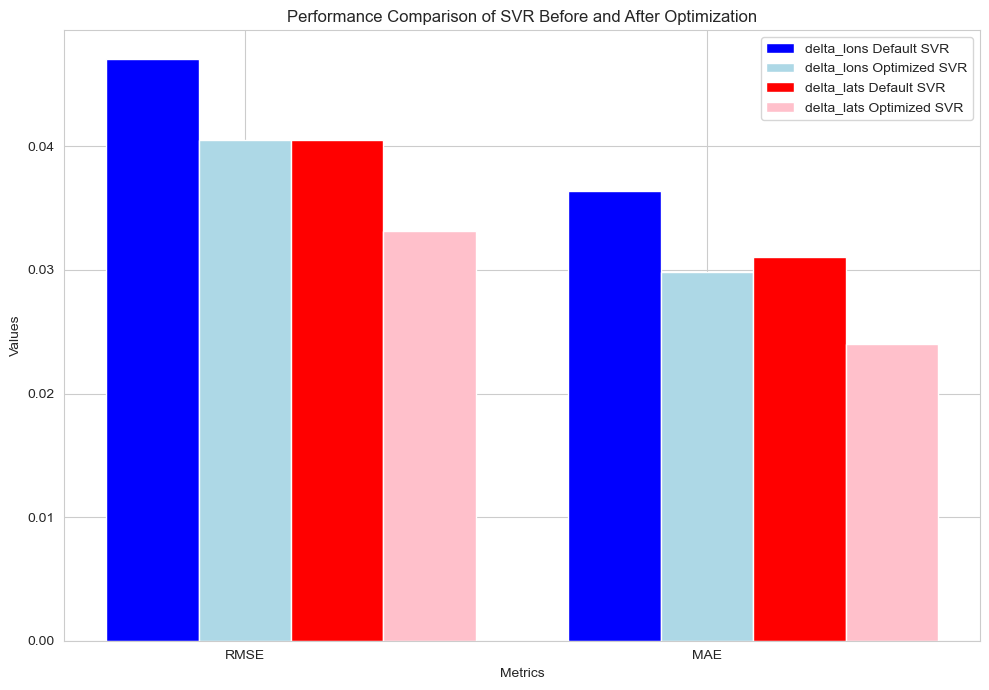

In [92]:
labels = ['RMSE', 'MAE']
lons_values_default = performance_df_svr["delta_lons_SVR"].values
lats_values_default = performance_df_svr["delta_lats_SVR"].values
lons_values_optimized = [rmse_lons_svr_optimized, mae_lons_svr_optimized]
lats_values_optimized = [rmse_lats_svr_optimized, mae_lats_svr_optimized]

x = range(len(labels))


plt.figure(figsize=(10, 7))
plt.bar([i-0.2 for i in x], lons_values_default, width=0.2, color='blue', label='delta_lons Default SVR', align='center')
plt.bar(x, lons_values_optimized, width=0.2, color='lightblue', label='delta_lons Optimized SVR', align='center')
plt.bar([i+0.2 for i in x], lats_values_default, width=0.2, color='red', label='delta_lats Default SVR', align='center')
plt.bar([i+0.4 for i in x], lats_values_optimized, width=0.2, color='pink', label='delta_lats Optimized SVR', align='center')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Performance Comparison of SVR Before and After Optimization')
plt.xticks(x, labels)
plt.legend()
plt.tight_layout()
plt.show()


# K-NN optimization

In [93]:
# # Define the distribution of hyperparameters
# param_dist = {'n_neighbors': randint(1, 31), 'metric': ['euclidean', 'manhattan']}

# # Create a KNN regression model object
# knn = KNeighborsRegressor()

# # Create a RandomizedSearchCV object
# random_search = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=42)

# # Train the model for delta_lons
# random_search.fit(X_train_scaled, y_train['delta_lons'])
# best_knn_lons = random_search.best_estimator_

# # Train the model for delta_lats
# random_search.fit(X_train_scaled, y_train['delta_lats'])
# best_knn_lats = random_search.best_estimator_


In [94]:
# # Save the optimal hyperparameters of the delta_lons model
# with open('./params/optimized_params_knn_lons_model.pkl', 'wb') as f:
#     pickle.dump(best_knn_lons, f)

# # Save the optimal hyperparameters of the delta_lats model
# with open('./params/optimized_params_knn_lats_model.pkl', 'wb') as f:
#     pickle.dump(best_knn_lats, f)


In [95]:
# Load the optimal hyperparameters of the delta_lons model
with open('./params/optimized_params_knn_lons_model.pkl', 'rb') as f:
    knn_lons_model = pickle.load(f)
    loaded_params_knn_lons = knn_lons_model.get_params()

# Load the optimal hyperparameters of the delta_lats model
with open('./params/optimized_params_knn_lats_model.pkl', 'rb') as f:
    knn_lats_model = pickle.load(f)
    loaded_params_knn_lats = knn_lats_model.get_params()


In [96]:
# Initialize and train the model
knn_lons_optimized = KNeighborsRegressor(**loaded_params_knn_lons).fit(X_train_scaled, y_train['delta_lons'])
predictions_lons_knn_optimized = knn_lons_optimized.predict(X_val_scaled)
rmse_lons_knn_optimized = mean_squared_error(y_val['delta_lons'], predictions_lons_knn_optimized, squared=False)
mae_lons_knn_optimized = mean_absolute_error(y_val['delta_lons'], predictions_lons_knn_optimized)

# Train the optimal model for delta_lats
knn_lats_optimized = KNeighborsRegressor(**loaded_params_knn_lats).fit(X_train_scaled, y_train['delta_lats'])
predictions_lats_knn_optimized = knn_lats_optimized.predict(X_val_scaled)
rmse_lats_knn_optimized = mean_squared_error(y_val['delta_lats'], predictions_lats_knn_optimized, squared=False)
mae_lats_knn_optimized = mean_absolute_error(y_val['delta_lats'], predictions_lats_knn_optimized)

# Print the performance metrics
performance_metrics_knn_optimized = {
    "Metrics": ["RMSE", "MAE"],
    "delta_lons_KNN_optimized": [rmse_lons_knn_optimized, mae_lons_knn_optimized],
    "delta_lats_KNN_optimized": [rmse_lats_knn_optimized, mae_lats_knn_optimized]
}
performance_df_knn_optimized = pd.DataFrame(performance_metrics_knn_optimized)
performance_df_knn_optimized


Metrics  delta_lons_KNN_optimized  delta_lats_KNN_optimized
0    RMSE                  0.040742                  0.033429
1     MAE                  0.029892                  0.024236

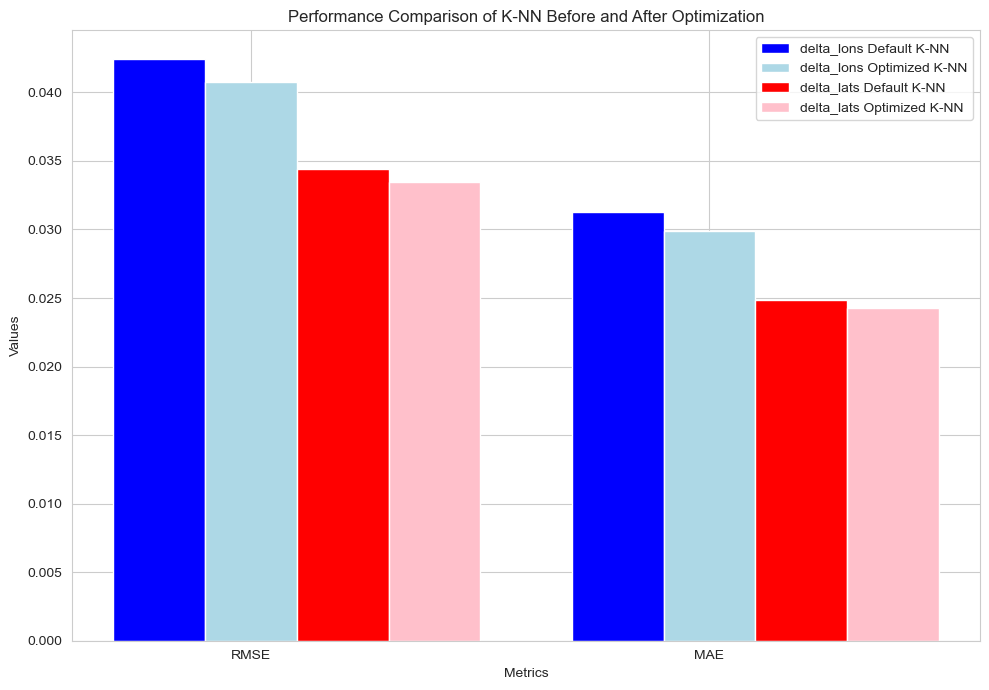

In [97]:
# Set labels and values
labels = ['RMSE', 'MAE']
lons_values_default = performance_df_knn["delta_lons_KNN"].values
lats_values_default = performance_df_knn["delta_lats_KNN"].values
lons_values_optimized = performance_df_knn_optimized["delta_lons_KNN_optimized"].values
lats_values_optimized = performance_df_knn_optimized["delta_lats_KNN_optimized"].values

# Set x-axis positions
x = range(len(labels))

# Draw the graph
plt.figure(figsize=(10, 7))
plt.bar([i-0.2 for i in x], lons_values_default, width=0.2, color='blue', label='delta_lons Default K-NN', align='center')
plt.bar([i for i in x], lons_values_optimized, width=0.2, color='lightblue', label='delta_lons Optimized K-NN', align='center')
plt.bar([i+0.2 for i in x], lats_values_default, width=0.2, color='red', label='delta_lats Default K-NN', align='center')
plt.bar([i+0.4 for i in x], lats_values_optimized, width=0.2, color='pink', label='delta_lats Optimized K-NN', align='center')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Performance Comparison of K-NN Before and After Optimization')
plt.xticks(x, labels)
plt.legend()
plt.tight_layout()
plt.show()


# Bayesian Ridge Regression optimization

In [98]:
# # Set the hyperparameter range for Bayesian Ridge Regression
# param_dist = {
#     'alpha_1': np.logspace(-6, 6, 13),
#     'alpha_2': np.logspace(-6, 6, 13),
#     'lambda_1': np.logspace(-6, 6, 13),
#     'lambda_2': np.logspace(-6, 6, 13),
#     'tol': [1e-4, 1e-3, 1e-2, 1e-1]
# }

# # Use RandomizedSearchCV to find the best hyperparameters
# # For delta_lons
# bayes_lons = BayesianRidge()
# random_search_lons = RandomizedSearchCV(bayes_lons, param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
# random_search_lons.fit(X_train_scaled, y_train['delta_lons'])
# best_params_lons = random_search_lons.best_params_

# # Save the best hyperparameters (using pickle)
# with open('./params/optimized_params_bayes_lons_model.pkl', 'wb') as f:
#     pickle.dump(best_params_lons, f)

# # For delta_lats
# bayes_lats = BayesianRidge()
# random_search_lats = RandomizedSearchCV(bayes_lats, param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
# random_search_lats.fit(X_train_scaled, y_train['delta_lats'])
# best_params_lats = random_search_lats.best_params_

# # Save the best hyperparameters (using pickle)
# with open('./params/optimized_params_bayes_lats_model.pkl', 'wb') as f:
#     pickle.dump(best_params_lats, f)

# best_params_lons, best_params_lats


In [99]:
# Load the optimal hyperparameters for the delta_lons model
with open('./params/optimized_params_bayes_lons_model.pkl', 'rb') as f:
    loaded_params_bayes_lons = pickle.load(f)

# Load the optimal hyperparameters for the delta_lats model
with open('./params/optimized_params_bayes_lats_model.pkl', 'rb') as f:
    loaded_params_bayes_lats = pickle.load(f)

# Train and evaluate the optimal model for delta_lons
bayes_lons_optimized = BayesianRidge(**loaded_params_bayes_lons).fit(X_train_scaled, y_train['delta_lons'])
predictions_lons_bayes_optimized = bayes_lons_optimized.predict(X_val_scaled)
rmse_lons_bayes_optimized = mean_squared_error(y_val['delta_lons'], predictions_lons_bayes_optimized, squared=False)
mae_lons_bayes_optimized = mean_absolute_error(y_val['delta_lons'], predictions_lons_bayes_optimized)

# Train and evaluate the optimal model for delta_lats
bayes_lats_optimized = BayesianRidge(**loaded_params_bayes_lats).fit(X_train_scaled, y_train['delta_lats'])
predictions_lats_bayes_optimized = bayes_lats_optimized.predict(X_val_scaled)
rmse_lats_bayes_optimized = mean_squared_error(y_val['delta_lats'], predictions_lats_bayes_optimized, squared=False)
mae_lats_bayes_optimized = mean_absolute_error(y_val['delta_lats'], predictions_lats_bayes_optimized)

# Print the performance metrics
performance_metrics_bayes_optimized = {
    "Metrics": ["RMSE", "MAE"],
    "delta_lons_Bayesian_optimized": [rmse_lons_bayes_optimized, mae_lons_bayes_optimized],
    "delta_lats_Bayesian_optimized": [rmse_lats_bayes_optimized, mae_lats_bayes_optimized]
}
performance_df_bayes_optimized = pd.DataFrame(performance_metrics_bayes_optimized)
performance_df_bayes_optimized


Metrics  delta_lons_Bayesian_optimized  delta_lats_Bayesian_optimized
0    RMSE                       0.043200                       0.034997
1     MAE                       0.032089                       0.026040

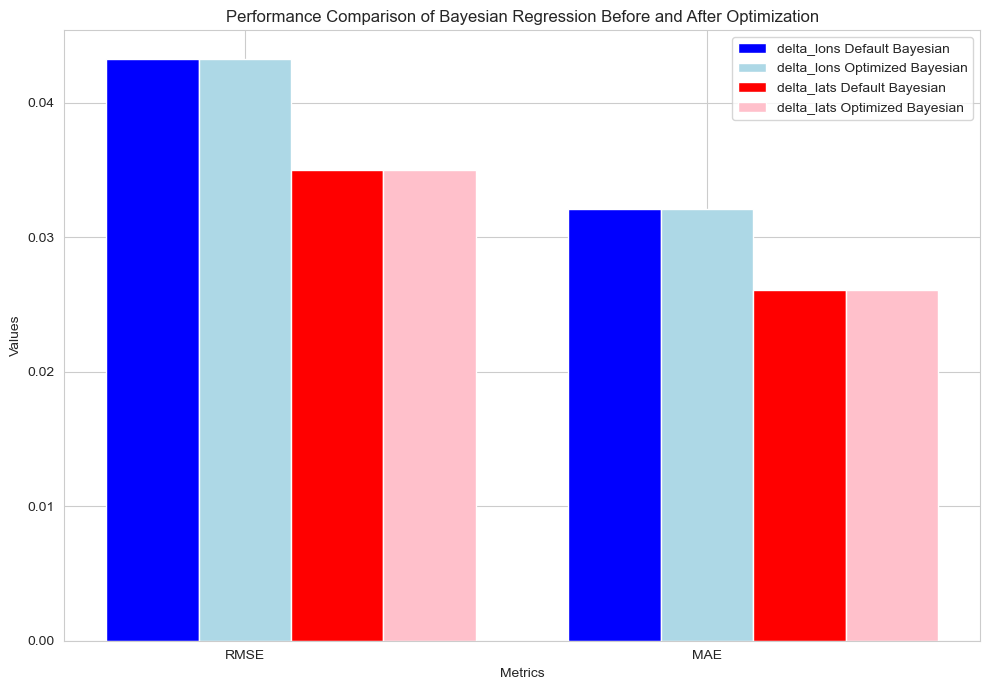

In [100]:
# Set labels and values
labels = ['RMSE', 'MAE']
lons_values_default = performance_df_bayes["delta_lons_Bayesian"].values
lats_values_default = performance_df_bayes["delta_lats_Bayesian"].values
lons_values_optimized = performance_df_bayes_optimized["delta_lons_Bayesian_optimized"].values
lats_values_optimized = performance_df_bayes_optimized["delta_lats_Bayesian_optimized"].values

# Set x-axis positions
x = range(len(labels))

# Draw the graph
plt.figure(figsize=(10, 7))
plt.bar([i-0.2 for i in x], lons_values_default, width=0.2, color='blue', label='delta_lons Default Bayesian', align='center')
plt.bar([i for i in x], lons_values_optimized, width=0.2, color='lightblue', label='delta_lons Optimized Bayesian', align='center')
plt.bar([i+0.2 for i in x], lats_values_default, width=0.2, color='red', label='delta_lats Default Bayesian', align='center')
plt.bar([i+0.4 for i in x], lats_values_optimized, width=0.2, color='pink', label='delta_lats Optimized Bayesian', align='center')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Performance Comparison of Bayesian Regression Before and After Optimization')
plt.xticks(x, labels)
plt.legend()
plt.tight_layout()
plt.show()


# Metric Comparison

In [101]:
import numpy as np

# Consolidating all performance metrics into a single dataframe for comparison
all_optimized_performance_metrics = {
    "Metrics": ["RMSE", "MAE"],
    
    "delta_lons_RF_optimized": performance_df_rf_optimized["delta_lons_RF_optimized"].values,
    "delta_lats_RF_optimized": performance_df_rf_optimized["delta_lats_RF_optimized"].values,
    
    "delta_lons_XGB_optimized": performance_df_xgb_optimized["delta_lons_XGB_optimized"].values,
    "delta_lats_XGB_optimized": performance_df_xgb_optimized["delta_lats_XGB_optimized"].values,    
    
    
    "delta_lons_ANN_optimized": performance_df_ann_optimized["delta_lons_ANN_optimized"].values, 
    "delta_lats_ANN_optimized": performance_df_ann_optimized["delta_lats_ANN_optimized"].values,
    
    "delta_lons_SVR_optimized": performance_df_svr_optimized["delta_lons_SVR_optimized"].values,
    "delta_lats_SVR_optimized": performance_df_svr_optimized["delta_lats_SVR_optimized"].values,
    
    "delta_lons_KNN_optimized": performance_df_knn_optimized["delta_lons_KNN_optimized"].values,
    "delta_lats_KNN_optimized": performance_df_knn_optimized["delta_lats_KNN_optimized"].values,
    
    "delta_lons_Bayesian": performance_df_bayes["delta_lons_Bayesian"].values,
    "delta_lats_Bayesian": performance_df_bayes["delta_lats_Bayesian"].values
}

optimized_performance_comparison_df = pd.DataFrame(all_optimized_performance_metrics)
optimized_performance_comparison_df


Metrics  delta_lons_RF_optimized  delta_lats_RF_optimized  \
0    RMSE                 0.037216                 0.030177   
1     MAE                 0.027151                 0.021718   

   delta_lons_XGB_optimized  delta_lats_XGB_optimized  \
0                  0.036691                  0.029881   
1                  0.026830                  0.021562   

   delta_lons_ANN_optimized  delta_lats_ANN_optimized  \
0                  0.042812                  0.036175   
1                  0.031779                  0.026650   

   delta_lons_SVR_optimized  delta_lats_SVR_optimized  \
0                  0.040494                  0.033130   
1                  0.029818                  0.023969   

   delta_lons_KNN_optimized  delta_lats_KNN_optimized  delta_lons_Bayesian  \
0                  0.040742                  0.033429             0.043201   
1                  0.029892                  0.024236             0.032088   

   delta_lats_Bayesian  
0             0.034997  
1             0.026040

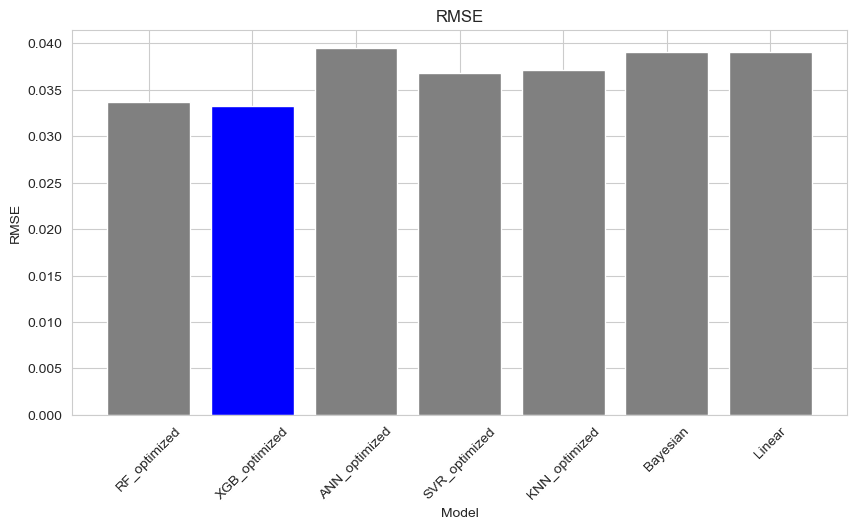

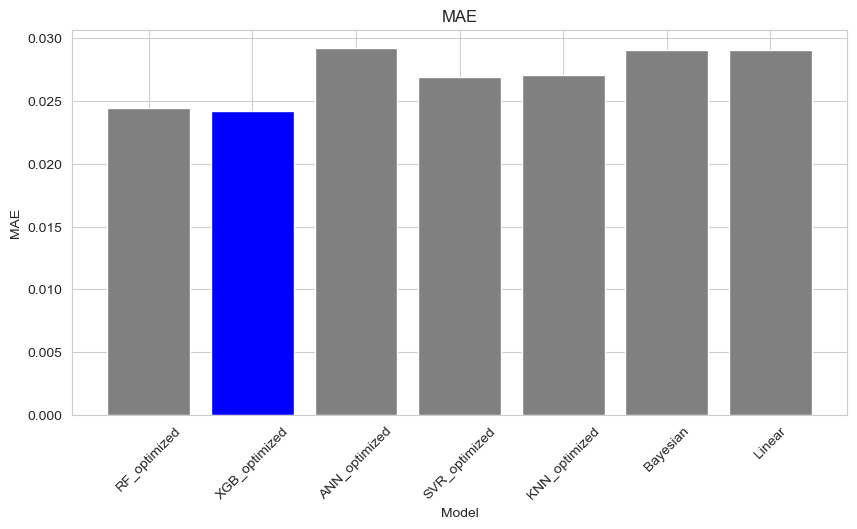

In [102]:
# Create a DataFrame
total1 = performance_comparison_df[['delta_lons_Linear', 'delta_lats_Linear']]
total_performance = pd.concat([performance_comparison_df, optimized_performance_comparison_df], axis=1)



# Calculate the average of delta_lons and delta_lats for each model
total_performance['RF_optimized'] = total_performance[['delta_lons_RF_optimized', 'delta_lats_RF_optimized']].mean(axis=1)
total_performance['XGB_optimized'] = total_performance[['delta_lons_XGB_optimized', 'delta_lats_XGB_optimized']].mean(axis=1)
total_performance['ANN_optimized'] = total_performance[['delta_lons_ANN_optimized', 'delta_lats_ANN_optimized']].mean(axis=1)
total_performance['SVR_optimized'] = total_performance[['delta_lons_SVR_optimized', 'delta_lats_SVR_optimized']].mean(axis=1)
total_performance['KNN_optimized'] = total_performance[['delta_lons_KNN_optimized', 'delta_lats_KNN_optimized']].mean(axis=1)
total_performance['Bayesian'] = total_performance[['delta_lons_Bayesian', 'delta_lats_Bayesian']].mean(axis=1)
total_performance['Linear'] = total_performance[['delta_lons_Linear', 'delta_lats_Linear']].mean(axis=1)

# Remove columns with 'delta_lons' and 'delta_lats' in their names
total_performance = total_performance.drop(columns=[col for col in total_performance if 'delta_lons' in col or 'delta_lats' in col])

total_performance
total_performance = total_performance.drop(['Metrics'], axis = 1)

total_performance['Metrics'] = ['RMSE', 'MAE']



# Function to plot bar graph
def plot_bar_graph(data, title, ylabel, xlabel):
    plt.figure(figsize=(10, 5))
    min_value_idx = np.argmin(data.iloc[0, :])  # Index of the minimum value
    colors = ['grey' if i != min_value_idx else 'blue' for i in range(len(data.columns))]  # Color settings
    plt.bar(data.columns, data.iloc[0, :], color=colors)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xticks(rotation=45)
    plt.show()

# Extracting RMSE data
rmse_data = total_performance[total_performance['Metrics'] == 'RMSE'].drop(['Metrics'], axis=1)

# Plotting RMSE bar graph
plot_bar_graph(rmse_data, 'RMSE', 'RMSE', 'Model')

# Extracting MAE data
mae_data = total_performance[total_performance['Metrics'] == 'MAE'].drop(['Metrics'], axis=1)

# Plotting MAE bar graph
plot_bar_graph(mae_data, 'MAE', 'MAE', 'Model')

# 100_days test

# Comparison of 100-day trajectory predictions for floats 5, 14, and 20 in the test set

Pick a starting point, add delta values to the current lat and lon based on the starting point, and interpolate ocean current and wind data from the next point.


In [136]:
# Initial starting point data

test_data = {
    'Number': [5, 14, 20],
    'year': [2005, 2005, 2005],
    'month': [4, 8, 11],
    'day': [4, 28, 10],
    'hour': [12, 12, 12],
    'lons': [129.332001, 129.440994, 129.399002],
    'lats': [34.98, 35.106998, 35.134998]
}

test_df = pd.DataFrame(test_data)

# Convert Year, Month, Day, Hour to datetime format
test_df["datetime"] = pd.to_datetime(test_df[['year', 'month', 'day', 'hour']])

test_df


Number  year  month  day  hour        lons       lats            datetime
0       5  2005      4    4    12  129.332001  34.980000 2005-04-04 12:00:00
1      14  2005      8   28    12  129.440994  35.106998 2005-08-28 12:00:00
2      20  2005     11   10    12  129.399002  35.134998 2005-11-10 12:00:00

In [137]:
# Collecting fitted ocean current and wind data (every 3 hours)
current_ds_5 = xr.open_dataset('./data/current_test_5.nc') 
current_ds_14 = xr.open_dataset('./data/current_test_14.nc')
current_ds_20 = xr.open_dataset('./data/current_test_20.nc')

wind_ds_5 = xr.open_dataset('./data/wind_test_5.nc')
wind_ds_14 = xr.open_dataset('./data/wind_test_14.nc')
wind_ds_20 = xr.open_dataset('./data/wind_test_20.nc')


In [138]:
# Training train + val set with the optimized RF model

# Removing these rows from the original data to get the rest of the dataset
train_set = data[~data['drifter'].isin([5, 14, 20])]
selected_columns = ['delta_lons', 'delta_lats', 'lons', 'lats', 'year', 'month', 'day', 'hour', 'current_u0_interpolated', 'current_v0_interpolated','wind_u_interpolated', 'wind_v_interpolated']
new_train = train_set[selected_columns]
X = new_train.drop(['delta_lons', 'delta_lats'], axis = 1)
delta_lons = new_train['delta_lons']
delta_lats = new_train['delta_lats']

# Train the model for delta_lon
xgb_lons_optimized.fit(X , delta_lons)

# Train the model for delta_lats
xgb_lats_optimized.fit(X , delta_lats)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=250, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [139]:
# Predicting for drifters 15 ,14, 20 for the next 100 days

for i in tqdm(range(1, 32), desc="Processing datasets"):  # Looping from 1 to 31
    
    for idx, drifter_num in enumerate([5, 14, 20]):

        # Defining column names
        columns = [
            'lons', 'lats', 'year', 'month', 'day', 'hour',
            'current_u0_interpolated', 'current_v0_interpolated','wind_u_interpolated', 'wind_v_interpolated',
            'delta_lons', 'delta_lats'
        ]

        total_step = 400

        # Creating a DataFrame with all values set to 0 (11 rows)
        drifter_new = pd.DataFrame(0, index=range(int(total_step + 1)), columns=columns)

        # Assigning values to the first row
        drifter_new.loc[0, 'lons'] = test_df.loc[idx, 'lons']
        drifter_new.loc[0, 'lats'] = test_df.loc[idx, 'lats']
        drifter_new.loc[0, 'year'] = test_df.loc[idx, 'year']
        drifter_new.loc[0, 'month'] = test_df.loc[idx, 'month']
        drifter_new.loc[0, 'day'] = test_df.loc[idx, 'day']
        drifter_new.loc[0, 'hour'] = test_df.loc[idx, 'hour']

        # Converting the date and time information of the first row to a datetime object
        initial_datetime = datetime(
            year=int(drifter_new.loc[0, 'year']), 
            month=int(drifter_new.loc[0, 'month']), 
            day=int(drifter_new.loc[0, 'day']), 
            hour=int(drifter_new.loc[0, 'hour'])
        )

        # Filling in the rest of the rows with date and time information incremented by 6 hours
        for i in range(1, len(drifter_new)):
            # Adding 6 hours
            new_datetime = initial_datetime + timedelta(hours=6 * i)

            # Assigning the new date and time information to the DataFrame
            drifter_new.loc[i, 'year'] = new_datetime.year
            drifter_new.loc[i, 'month'] = new_datetime.month
            drifter_new.loc[i, 'day'] = new_datetime.day
            drifter_new.loc[i, 'hour'] = new_datetime.hour

        # Creating a 'date_time' column and storing the date and time information as string
        drifter_new['date_time'] = pd.to_datetime(drifter_new[['year', 'month', 'day', 'hour']]).dt.strftime('%Y-%m-%d %H:%M:%S')

        current_ds = eval(f'current_ds_{drifter_num}')
        wind_ds = eval(f'wind_ds_{drifter_num}')
        
        # Predicting for the next 100 days (400 steps)
        for step in range(0, total_step):
            
            row = drifter_new.loc[step, ['lons', 'lats', 'date_time']]
            lon, lat, time = row['lons'], row['lats'], row['date_time']

            # Selecting data at depth 0
            current_0_ds = current_ds.sel(depth=0)

            # Selecting data for a specific time
            time_data_0_ds = current_0_ds.sel(time=time)

            # Converting the result to a DataFrame
            time_data_0 = time_data_0_ds.to_dataframe().reset_index()

            points_0 = get_neighboring_points(lon, lat, time_data_0)

            values_uo = []
            values_vo = []

            for point in points_0:
                matching_rows_uo = time_data_0[(time_data_0['longitude'] == point[0]) & (time_data_0['latitude'] == point[1])]['uo']
                matching_rows_vo = time_data_0[(time_data_0['longitude'] == point[0]) & (time_data_0['latitude'] == point[1])]['vo']

                if matching_rows_uo.empty:
                    values_uo.append(np.nan)
                else:
                    values_uo.append(matching_rows_uo.values[0])

                if matching_rows_vo.empty:
                    values_vo.append(np.nan)
                else:
                    values_vo.append(matching_rows_vo.values[0])

            points_uo = [(point[0], point[1], value) for point, value in zip(points_0, values_uo)]
            points_vo = [(point[0], point[1], value) for point, value in zip(points_0, values_vo)]

            if len([p for p in points_uo if not np.isnan(p[1])]) < 4 or len([p for p in points_vo if not np.isnan(p[1])]) < 4 or len([p for p in points_uo if not np.isnan(p[2])]) < 4 or len([p for p in points_vo if not np.isnan(p[2])]) < 4:

                uo_nearest_value = find_nearest_point_value(lon, lat, time_data_0, 'uo')
                vo_nearest_value = find_nearest_point_value(lon, lat, time_data_0, 'vo')
                drifter_new.at[step, 'current_u0_interpolated'] = uo_nearest_value
                drifter_new.at[step, 'current_v0_interpolated'] = vo_nearest_value
            else:
                drifter_new.at[step, 'current_u0_interpolated'] = bilinear_interpolation(lon, lat, points_uo)
                drifter_new.at[step, 'current_v0_interpolated'] = bilinear_interpolation(lon, lat, points_vo)

                
         
            row = drifter_new.loc[step, ['lons', 'lats', 'date_time']]
            lon, lat, time = row['lons'], row['lats'], row['date_time']

            # Selecting data for a specific time
            time_data_ds = wind_ds.sel(time=time)

            # Converting the result to a DataFrame
            time_data = time_data_ds.to_dataframe().reset_index()
            
            points_10 = get_neighboring_points(lon, lat, time_data) 
            
            values_u10 = []
            values_v10 = []
            
            for point in points_10:
                matching_rows_u10 = time_data[(time_data['longitude'] == point[0]) & (time_data['latitude'] == point[1])]['u10']
                matching_rows_v10 = time_data[(time_data['longitude'] == point[0]) & (time_data['latitude'] == point[1])]['v10']

                if matching_rows_u10.empty:
                    values_u10.append(np.nan)
                else:
                    values_u10.append(matching_rows_u10.values[0])

                if matching_rows_v10.empty:
                    values_v10.append(np.nan)
                else:
                    values_v10.append(matching_rows_v10.values[0])

            points_u10 = [(point[0], point[1], value) for point, value in zip(points_10, values_u10)]
            points_v10 = [(point[0], point[1], value) for point, value in zip(points_10, values_v10)]

            if len([p for p in points_u10 if not np.isnan(p[2])]) < 4 or len([p for p in points_v10 if not np.isnan(p[2])]) < 4:

                u10_nearest_value = find_nearest_point_value(lon, lat, time_data, 'u10')
                v10_nearest_value = find_nearest_point_value(lon, lat, time_data, 'v10')
                drifter_new.at[step, 'wind_u_interpolated'] = u10_nearest_value
                drifter_new.at[step, 'wind_v_interpolated'] = v10_nearest_value
            else:
                drifter_new.at[step, 'wind_u_interpolated'] = bilinear_interpolation(lon, lat, points_u10)
                drifter_new.at[step, 'wind_v_interpolated'] = bilinear_interpolation(lon, lat, points_v10)

                

                
            # Predicting the next step
            drifter_new.at[step, 'delta_lons'] = xgb_lons_optimized.predict(pd.DataFrame([drifter_new.loc[step, ['lons', 'lats', 'year', 'month', 'day', 'hour', 'current_u0_interpolated', 'current_v0_interpolated',
                                                  'wind_u_interpolated', 'wind_v_interpolated']]]))
            drifter_new.at[step, 'delta_lats'] = xgb_lats_optimized.predict(pd.DataFrame([drifter_new.loc[step, ['lons', 'lats', 'year', 'month', 'day', 'hour', 'current_u0_interpolated', 'current_v0_interpolated',
                                                  'wind_u_interpolated', 'wind_v_interpolated']]]))    

            drifter_new.at[int(step + 1), 'lons'] = drifter_new.at[step, 'lons'] + drifter_new.at[step, 'delta_lons']
            drifter_new.at[int(step + 1), 'lats'] = drifter_new.at[step, 'lats'] + drifter_new.at[step, 'delta_lats']

        globals()[f'test_{drifter_num}'] = drifter_new


Processing datasets: 100%|█████████████████████████████████████████████████████████████| 31/31 [35:22<00:00, 68.46s/it]


In [140]:
# Adding a column to each DataFrame to indicate the drifter number

test_frames = [test_5, test_14, test_20]

test_5['drifter'] = 5
test_14['drifter'] = 14
test_20['drifter'] = 20

# Concatenating all DataFrames vertically
test_drifter = pd.concat(test_frames, ignore_index=True)

# Moving the 'drifter' column to the front
test_drifter = test_drifter[['drifter'] + [col for col in test_drifter.columns if col != 'drifter']]

test_drifter


drifter        lons       lats  year  month  day  hour  \
0           5  129.332001  34.980000  2005      4    4    12   
1           5  129.418819  34.995060  2005      4    4    18   
2           5  129.445346  34.992220  2005      4    5     0   
3           5  129.539007  35.041633  2005      4    5     6   
4           5  129.609930  35.064312  2005      4    5    12   
...       ...         ...        ...   ...    ...  ...   ...   
1198       20  133.968021  34.377467  2006      2   17    12   
1199       20  133.955216  34.381907  2006      2   17    18   
1200       20  133.948469  34.379539  2006      2   18     0   
1201       20  133.918824  34.370196  2006      2   18     6   
1202       20  133.904779  34.365950  2006      2   18    12   

      current_u0_interpolated  current_v0_interpolated  wind_u_interpolated  \
0                    0.307683                 0.106753             8.810894   
1                    0.319829                 0.088588            10.298629   
2                    0.326242                 0.070216             9.255000   
3                    0.348906                 0.099835             8.770357   
4                    0.310953                 0.084194             7.587540   
...                       ...                      ...                  ...   
1198                -0.133896                -0.208850             2.629432   
1199                -0.073900                -0.161771             0.203456   
1200                -0.068008                -0.119853             0.945328   
1201                -0.054801                -0.115014             1.010543   
1202                 0.000000                 0.000000             0.000000   

      wind_v_interpolated  delta_lons  delta_lats            date_time  
0                5.194895    0.086818    0.015060  2005-04-04 12:00:00  
1                3.721857    0.026528   -0.002840  2005-04-04 18:00:00  
2                5.700052    0.093661    0.049413  2005-04-05 00:00:00  
3                8.302242    0.070922    0.022679  2005-04-05 06:00:00  
4                8.369139    0.059512    0.014475  2005-04-05 12:00:00  
...                   ...         ...         ...                  ...  
1198            -3.951062   -0.012806    0.004440  2006-02-17 12:00:00  
1199            -2.135626   -0.006747   -0.002368  2006-02-17 18:00:00  
1200            -0.621946   -0.029645   -0.009343  2006-02-18 00:00:00  
1201            -0.488058   -0.014045   -0.004247  2006-02-18 06:00:00  
1202             0.000000    0.000000    0.000000  2006-02-18 12:00:00  

[1203 rows x 14 columns]

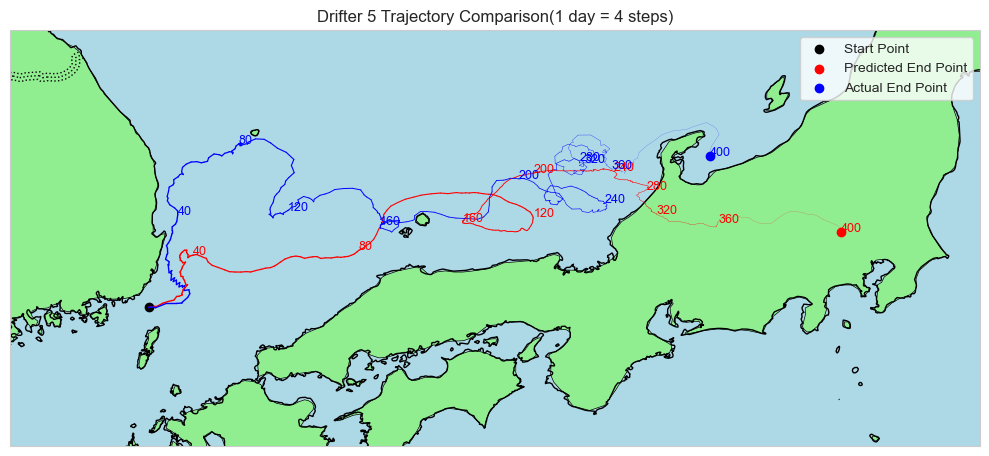

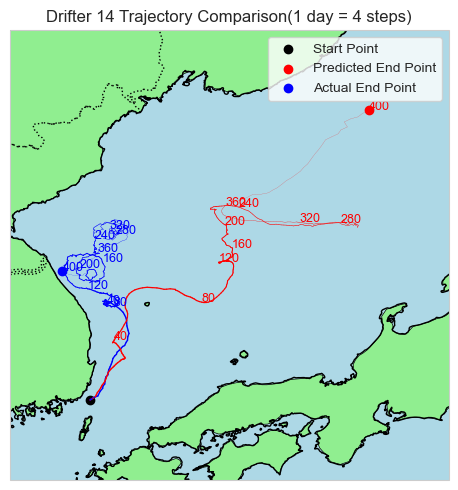

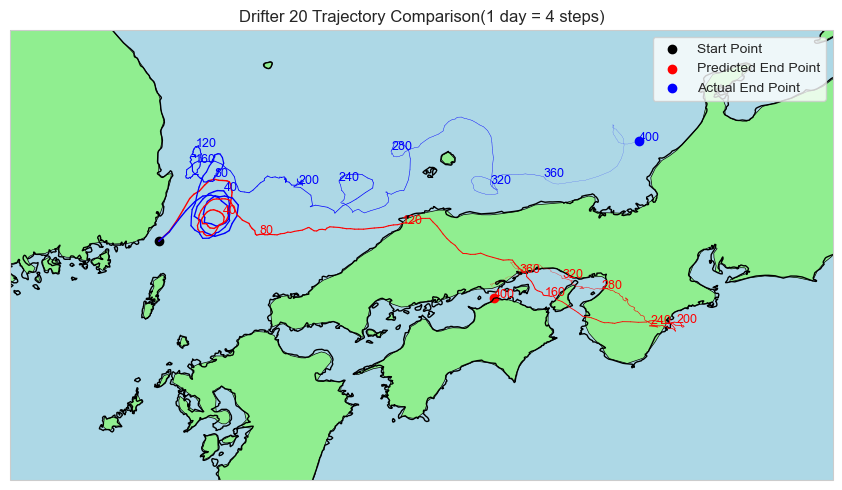

In [141]:
def plot_drifter_trajectory_final_english(drifter_num, drifter_data, test_data):
    # Extracting the actual trajectory data of the specified drifter
    drifter_trajectory = drifter_data[drifter_data['drifter'] == drifter_num].copy()
    drifter_trajectory['time'] = pd.to_datetime(drifter_trajectory['time'])
    test_data['date_time'] = pd.to_datetime(test_data['date_time'])
    
    # Merging data based on time
    merged_data = pd.merge_asof(test_data.sort_values('date_time'), 
                                drifter_trajectory.sort_values('time'), 
                                left_on='date_time', 
                                right_on='time', 
                                direction='nearest', 
                                tolerance=pd.Timedelta('6 hours'))
    
    # Checking for any missing data
    if merged_data.isnull().any().any():
        print(f"Drifter {drifter_num} has missing data. Please check the merging process.")
        return
    
    # Setting up the map
    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Adding colors and details to the map
    land = cfeature.LAND.with_scale('50m')
    ax.add_feature(land, edgecolor='black', facecolor='lightgreen')

    ocean = cfeature.OCEAN.with_scale('50m')
    ax.add_feature(ocean, facecolor='lightblue')
    
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    # Adjusting the map area based on the drifter's trajectory
    lon_min, lon_max = merged_data['lons_x'].min() - 2, merged_data['lons_x'].max() + 2
    lat_min, lat_max = merged_data['lats_x'].min() - 2, merged_data['lats_x'].max() + 2
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    
    linewidth_factor = 0.1  # Adjusting the increase in thickness
    n = len(merged_data)
    for i in range(1, n):
        linewidth = linewidth_factor * ((n - i) // 40 + 1)
        plt.plot([merged_data['lons_x'].iloc[i-1], merged_data['lons_x'].iloc[i]], 
                 [merged_data['lats_x'].iloc[i-1], merged_data['lats_x'].iloc[i]], 
                 'r-', linewidth=linewidth, transform=ccrs.Geodetic())
        plt.plot([merged_data['lons_y'].iloc[i-1], merged_data['lons_y'].iloc[i]], 
                 [merged_data['lats_y'].iloc[i-1], merged_data['lats_y'].iloc[i]], 
                 'b-', linewidth=linewidth, transform=ccrs.Geodetic())
        
        if (i % 40 == 0) or (i == n-1):
            step_number = i // 40 * 40
            plt.text(merged_data['lons_x'].iloc[i], merged_data['lats_x'].iloc[i], str(step_number), color='red', fontsize=9, transform=ccrs.Geodetic())
            plt.text(merged_data['lons_y'].iloc[i], merged_data['lats_y'].iloc[i], str(step_number), color='blue', fontsize=9, transform=ccrs.Geodetic())
    
    plt.scatter(merged_data['lons_x'].iloc[0], merged_data['lats_x'].iloc[0], color='black', marker='o', label='Start Point', transform=ccrs.Geodetic())
    plt.scatter(merged_data['lons_x'].iloc[-1], merged_data['lats_x'].iloc[-1], color='red', marker='o', label='Predicted End Point', transform=ccrs.Geodetic())
    plt.scatter(merged_data['lons_y'].iloc[-1], merged_data['lats_y'].iloc[-1], color='blue', marker='o', label='Actual End Point', transform=ccrs.Geodetic())
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Drifter {drifter_num} Trajectory Comparison(1 day = 4 steps)')
    plt.legend()
    
    # Adjust layout
    plt.tight_layout()
    # Save the file (if needed)
    save_path = f"./output/drifter_test_{drifter_num}.png"
    plt.savefig(save_path, dpi=300)
    
    plt.grid(True)
    plt.show()

# Comparing the trajectory of drifter 5
plot_drifter_trajectory_final_english(5, data, test_5)
# Comparing the trajectory of drifter 14
plot_drifter_trajectory_final_english(14, data, test_14)
# Comparing the trajectory of drifter 20
plot_drifter_trajectory_final_english(20, data, test_20)


# Drifter Prediction in 2016


Since we have only one start point, ocean current and wind data are interpolated from the starting point.

In [142]:
# Initial starting point data
predict_data = {
    'Number': [1, 2, 3, 4, 5, 6, 7],
    'year': [2016, 2016, 2016, 2016, 2016, 2016, 2016],
    'month': [3, 3, 3, 3, 7, 7, 7],
    'day': [13, 15, 19, 19, 15, 18, 20],
    'hour': [11, 20, 12, 12, 15, 12, 1],
    'minute': [49, 15, 1, 38, 40, 48, 49],
    'Longitude (E) Degree': [127, 126, 129, 129, 127, 129, 129],
    'Longitude (E) Minute': [4.310, 36.949, 16.916, 12.744, 4.468, 17.834, 23.897],
    'Latitude (N) Degree': [32, 33, 34, 34, 32, 34, 37],
    'Latitude (N) Minute': [30.442, 45.559, 56.978, 59.200, 30.976, 55.305, 33.155]
}

predict_df = pd.DataFrame(predict_data)


In [143]:
# Create the 'Rounded_Hour' column
predict_df['Rounded_Hour'] = predict_df['hour'] + (predict_df['minute'] >= 30)
predict_df['Rounded_Hour'] = predict_df['Rounded_Hour'] % 24

# Drop the 'hour' and 'minute' columns
predict_df = predict_df.drop(columns=['hour', 'minute'])

# Adjust the position of the 'Rounded_Hour' column
cols = predict_df.columns.tolist()
cols = cols[:4] + [cols[-1]] + cols[4:-1]
predict_df = predict_df[cols]

# Convert the degree and minute columns to decimal degrees
predict_df['lons'] = predict_df['Longitude (E) Degree'] + predict_df['Longitude (E) Minute'] / 60.0
predict_df['lats'] = predict_df['Latitude (N) Degree'] + predict_df['Latitude (N) Minute'] / 60.0

# Drop the original degree and minute columns
predict_df = predict_df.drop(columns=['Longitude (E) Degree', 'Longitude (E) Minute', 'Latitude (N) Degree', 'Latitude (N) Minute'])

# Rename 'Rounded_Hour' to 'Hour' for compatibility with pd.to_datetime
predict_df = predict_df.rename(columns={"Rounded_Hour": "hour"})

# Round the hour to 3-hour intervals
predict_df['hour'] = [12, 21, 12, 12, 15, 12, 3]

# Convert Year, Month, Day, Hour to datetime format
predict_df["datetime"] = pd.to_datetime(predict_df[['year', 'month', 'day', 'hour']])

predict_df


Number  year  month  day  hour        lons       lats            datetime
0       1  2016      3   13    12  127.071833  32.507367 2016-03-13 12:00:00
1       2  2016      3   15    21  126.615817  33.759317 2016-03-15 21:00:00
2       3  2016      3   19    12  129.281933  34.949633 2016-03-19 12:00:00
3       4  2016      3   19    12  129.212400  34.986667 2016-03-19 12:00:00
4       5  2016      7   15    15  127.074467  32.516267 2016-07-15 15:00:00
5       6  2016      7   18    12  129.297233  34.921750 2016-07-18 12:00:00
6       7  2016      7   20     3  129.398283  37.552583 2016-07-20 03:00:00

In [144]:
# Collecting current data
current_ds = xr.open_dataset('./data/current.nc')

# Selecting data at depth = 0
current_ds.sel(depth=0)

# Collecting wind data
wind_ds = xr.open_dataset('./data/wind.nc')


In [145]:

total_train_set = data
selected_columns = ['delta_lons', 'delta_lats', 'lons', 'lats', 'year', 'month', 'day', 'hour', 'current_u0_interpolated', 'current_v0_interpolated','wind_u_interpolated', 'wind_v_interpolated']
total_new_train = total_train_set[selected_columns]
X = total_new_train.drop(['delta_lons', 'delta_lats'], axis = 1)
delta_lons = total_new_train['delta_lons']
delta_lats = total_new_train['delta_lats']


# Train the model for delta_lons
xgb_lons_optimized.fit(X, delta_lons)

# Train the model for delta_lats
xgb_lons_optimized.fit(X, delta_lats)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=250, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [149]:
# Predicting for 100 days
for i in tqdm(range(1, 32), desc="Processing datasets"):  # Looping from 1 to 32

    for drifter_num in range(0, 7):

        # Define column names
        columns = [
            'lons', 'lats', 'year', 'month', 'day', 'hour',
            'current_u0_interpolated', 'current_v0_interpolated','wind_u_interpolated', 'wind_v_interpolated',
            'delta_lons', 'delta_lats'
        ]

        total_step = 400

        # Create a DataFrame with all values initialized to 0 (11 rows)
        drifter_new = pd.DataFrame(0, index=range(int(total_step + 1)), columns=columns)

        # Assign values to the first row
        drifter_new.loc[0, 'lons'] = predict_df.loc[drifter_num, 'lons']
        drifter_new.loc[0, 'lats'] = predict_df.loc[drifter_num, 'lats']
        drifter_new.loc[0, 'year'] = predict_df.loc[drifter_num, 'year']
        drifter_new.loc[0, 'month'] = predict_df.loc[drifter_num, 'month']
        drifter_new.loc[0, 'day'] = predict_df.loc[drifter_num, 'day']
        drifter_new.loc[0, 'hour'] = predict_df.loc[drifter_num, 'hour']

        # Convert the date and time information of the first row into a datetime object
        initial_datetime = datetime(
            year=int(drifter_new.loc[0, 'year']), 
            month=int(drifter_new.loc[0, 'month']), 
            day=int(drifter_new.loc[0, 'day']), 
            hour=int(drifter_new.loc[0, 'hour'])
        )

        # Fill in the remaining rows with date and time information, increasing by 6 hours each time
        for i in range(1, len(drifter_new)):
            # Add 6 hours
            new_datetime = initial_datetime + timedelta(hours=6 * i)

            # Assign the new date and time information to the DataFrame
            drifter_new.loc[i, 'year'] = new_datetime.year
            drifter_new.loc[i, 'month'] = new_datetime.month
            drifter_new.loc[i, 'day'] = new_datetime.day
            drifter_new.loc[i, 'hour'] = new_datetime.hour

        # Create a 'date_time' column and generate a datetime object using 'year', 'month', 'day', and 'hour' information,
        # then convert it to a string and store it
        drifter_new['date_time'] = pd.to_datetime(drifter_new[['year', 'month', 'day', 'hour']]).dt.strftime('%Y-%m-%d %H:%M:%S')






        for step in range(0, total_step):


            row = drifter_new.loc[step, ['lons', 'lats', 'date_time']]
            lon, lat, time = row['lons'], row['lats'], row['date_time']

            # Select data with depth equal to 0.
            current_0_ds = current_ds.sel(depth=0)

            # Select data for a specific time.
            time_data_0_ds = current_0_ds.sel(time=time)

            # Convert the result into a DataFrame.

            time_data_0 = time_data_0_ds.to_dataframe().reset_index()


            points_0 = get_neighboring_points(lon, lat, time_data_0)

            values_uo = []
            values_vo = []

            for point in points_0:
                matching_rows_uo = time_data_0[(time_data_0['longitude'] == point[0]) & (time_data_0['latitude'] == point[1])]['uo']
                matching_rows_vo = time_data_0[(time_data_0['longitude'] == point[0]) & (time_data_0['latitude'] == point[1])]['vo']

                if matching_rows_uo.empty:
                    values_uo.append(np.nan)
                else:
                    values_uo.append(matching_rows_uo.values[0])

                if matching_rows_vo.empty:
                    values_vo.append(np.nan)
                else:
                    values_vo.append(matching_rows_vo.values[0])

            points_uo = [(point[0], point[1], value) for point, value in zip(points_0, values_uo)]
            points_vo = [(point[0], point[1], value) for point, value in zip(points_0, values_vo)]

            if len([p for p in points_uo if not np.isnan(p[1])]) < 4 or len([p for p in points_vo if not np.isnan(p[1])]) < 4 or len([p for p in points_uo if not np.isnan(p[2])]) < 4 or len([p for p in points_vo if not np.isnan(p[2])]) < 4:

                uo_nearest_value = find_nearest_point_value(lon, lat, time_data_0, 'uo')
                vo_nearest_value = find_nearest_point_value(lon, lat, time_data_0, 'vo')
                drifter_new.at[step, 'current_u0_interpolated'] = uo_nearest_value
                drifter_new.at[step, 'current_v0_interpolated'] = vo_nearest_value
            else:
                drifter_new.at[step, 'current_u0_interpolated'] = bilinear_interpolation(lon, lat, points_uo)
                drifter_new.at[step, 'current_v0_interpolated'] = bilinear_interpolation(lon, lat, points_vo)



            

            row = drifter_new.loc[step, ['lons', 'lats', 'date_time']]
            lon, lat, time = row['lons'], row['lats'], row['date_time']

            # Select data for a specific time.
            time_data_ds = wind_ds.sel(time=time)

            # Convert the results into a DataFrame.
            time_data = time_data_ds.to_dataframe().reset_index()

            points_10 = get_neighboring_points(lon, lat, time_data)   
            
            values_u10 = []
            values_v10 = []

            for point in points_10:
                matching_rows_u10 = time_data[(time_data['longitude'] == point[0]) & (time_data['latitude'] == point[1])]['u10']
                matching_rows_v10 = time_data[(time_data['longitude'] == point[0]) & (time_data['latitude'] == point[1])]['v10']

                if matching_rows_u10.empty:
                    values_u10.append(np.nan)
                else:
                    values_u10.append(matching_rows_u10.values[0])

                if matching_rows_v10.empty:
                    values_v10.append(np.nan)
                else:
                    values_v10.append(matching_rows_v10.values[0])

            points_u10 = [(point[0], point[1], value) for point, value in zip(points_10, values_u10)]
            points_v10 = [(point[0], point[1], value) for point, value in zip(points_10, values_v10)]

            if len([p for p in points_u10 if not np.isnan(p[2])]) < 4 or len([p for p in points_v10 if not np.isnan(p[2])]) < 4:

                u10_nearest_value = find_nearest_point_value(lon, lat, time_data, 'u10')
                v10_nearest_value = find_nearest_point_value(lon, lat, time_data, 'v10')
                drifter_new.at[step, 'wind_u_interpolated'] = u10_nearest_value
                drifter_new.at[step, 'wind_v_interpolated'] = v10_nearest_value
            else:
                drifter_new.at[step, 'wind_u_interpolated'] = bilinear_interpolation(lon, lat, points_u10)
                drifter_new.at[step, 'wind_v_interpolated'] = bilinear_interpolation(lon, lat, points_v10)

            drifter_new.at[step, 'delta_lons'] = xgb_lons_optimized.predict(pd.DataFrame([drifter_new.loc[step, ['lons', 'lats', 'year', 'month', 'day', 'hour', 'current_u0_interpolated', 'current_v0_interpolated',
                                                  'wind_u_interpolated', 'wind_v_interpolated']]]))
            drifter_new.at[step, 'delta_lats'] = xgb_lats_optimized.predict(pd.DataFrame([drifter_new.loc[step, ['lons', 'lats', 'year', 'month', 'day', 'hour', 'current_u0_interpolated', 'current_v0_interpolated',
                                                  'wind_u_interpolated', 'wind_v_interpolated']]]))    

            drifter_new.at[int(step + 1), 'lons'] = drifter_new.at[step, 'lons'] + drifter_new.at[step, 'delta_lons']
            drifter_new.at[int(step + 1), 'lats'] = drifter_new.at[step, 'lats'] + drifter_new.at[step, 'delta_lats']

        globals()[f'drifter_{drifter_num}'] = drifter_new
                                                                        
                                                                        

Processing datasets:   3%|█▉                                                         | 1/31 [03:45<1:52:36, 225.22s/it]


KeyboardInterrupt: 

In [ ]:
# Add a column to each DataFrame to indicate the drifter number


data_frames = [drifter_0, drifter_1, drifter_2, drifter_3, drifter_4, drifter_5, drifter_6]

for i, df in enumerate(data_frames):
    df['Number'] = i+1

# Concatenate all DataFrames vertically
predict_drifter = pd.concat(data_frames, ignore_index=True)

# Move the 'Number' column to the front
predict_drifter = predict_drifter[['Number'] + [col for col in predict_drifter.columns if col != 'Number']]

# Get unique drifter numbers
unique_drifters = predict_drifter['Number'].unique()


In [ ]:
predict_drifter.to_csv('./output/predict_drifter.csv')

In [ ]:

# Unique drifters
unique_drifters = predict_drifter['Number'].unique()

# Setting up colormap for rainbow representation
cmap = plt.cm.jet
colors = cmap(np.linspace(1, 0, len(unique_drifters)))

# Setting up the plot
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Adding land, coastlines, and borders to the map
# Setting the color of land to green and the color of ocean to light blue
land = cfeature.LAND.with_scale('50m')
ax.add_feature(land, edgecolor='black', facecolor='lightgreen')

ocean = cfeature.OCEAN.with_scale('50m')
ax.add_feature(ocean, facecolor='lightblue')

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Displaying the trajectories of each drifter on the map
for drifter, color in zip(unique_drifters, colors):
    subset = predict_drifter[predict_drifter["Number"] == drifter]
    ax.plot(subset["lons"], subset["lats"], label=f"Drifter {int(drifter)}", color=color, transform=ccrs.Geodetic())
    
    # Adding 'X' marker at the starting point of each trajectory
    start_lon, start_lat = subset.iloc[0]['lons'], subset.iloc[0]['lats']
    ax.plot(start_lon, start_lat, 'x', color=color, markersize=10, transform=ccrs.Geodetic())

plt.title("Drifter's Trajectories", fontsize=35, weight='bold')
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1), fontsize=12)

plt.xlabel('Longitude', fontsize=30)
plt.ylabel('Latitude', fontsize=30)

# Setting the xticks and yticks
min_lat, max_lat = predict_drifter['lats'].min()-1, predict_drifter['lats'].max()+1
min_lon, max_lon = predict_drifter['lons'].min()-1, predict_drifter['lons'].max()+1
ax.set_xticks(np.arange(round(min_lon), round(max_lon) + 1, 2))
ax.set_yticks(np.arange(round(min_lat), round(max_lat) + 1, 2))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

ax.plot(start_lon, start_lat, 'x', color=color, markersize=12, markeredgewidth=2, transform=ccrs.Geodetic())

# Adjust layout
plt.tight_layout()

# Save the file (if needed)
save_path = "./output/drifter_2016.png"
plt.savefig(save_path, dpi=300)

plt.grid(True)
plt.show()
